In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import datetime
import random
import time
import csv
import os

In [4]:
# sprawdzenie dostępnych urządzeń
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
class Colors:
    GREEN = "green"
    RED = "red"
    BLACK = "black"

def get_color_from_number(number: int) -> str:
    if number == 0:
        return Colors.GREEN
    if 0 < number <= 7:
        return Colors.RED
    if 8 <= number <= 14:
        return Colors.BLACK
    else:
        raise Exception("Number not in accepted range")

def get_color_number_from_color(color: str) -> int:
    if color == Colors.GREEN:
        return 0
    if color == Colors.RED:
        return 1
    if color == Colors.BLACK:
        return 2
    else:
        raise Exception(f"Color '{color}' not handled")

def split_list(lst, chunk_size) -> tuple[list[int], list[int]]:
    data = []
    labels = []
    for i in range(len(lst) - chunk_size):
        data.append(lst[i:i+chunk_size])
        labels.append(lst[i+chunk_size])
    return data, labels

def read_file(file_path: str) -> list[list[str]]:
    with open(file_path, newline='') as file:
        colors = []
        for line in file.readlines():
            numbers = line.strip().split(",")
            # reverse array as values are stored from newest to oldest
            numbers.reverse()
            try:
                parsed_numbers = list(map(lambda x: int(x), numbers))
                colors.append(list(map(get_color_from_number, parsed_numbers)))
            except Exception as e:
                # parsing numbers failed - that means numbers list contains color strings
                colors.append(numbers)
        return colors

def count_color_sequences(data):
    distinct_colors = list({item for lst in data for item in lst})
    color_sequence_counts = {color: Counter() for color in distinct_colors}

    for sequence in data:
        current_counts = {color: 0 for color in distinct_colors}
        
        for i, color in enumerate(sequence):
            if i == 0 or color == sequence[i - 1]:
                current_counts[color] += 1
            else:
                if current_counts[sequence[i - 1]] > 0:
                    color_sequence_counts[sequence[i - 1]][current_counts[sequence[i - 1]]] += 1
                    current_counts[sequence[i - 1]] = 0
                current_counts[color] = 1
        
        for color in distinct_colors:
            if current_counts[color] > 0:
                color_sequence_counts[color][current_counts[color]] += 1

    return color_sequence_counts

def prepare_data_and_labels(colors: list[list[str]], chunk_size) -> tuple[list[list[int]], list[int]]:
    combined_data = []
    combined_labels = []
    for lst in colors:
        colors_parsed_to_numbers = list(map(get_color_number_from_color,lst))
        data, labels = split_list(colors_parsed_to_numbers, chunk_size)
        combined_data.extend(data)
        combined_labels.extend(labels)
    return combined_data, combined_labels

def show(*args):
    print(f"\n{args}\n")

In [14]:
def plot_color_sequence_histograms(color_sequence_counts):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    fig.suptitle('Frequency of Consecutive Color Occurrences')
    bar_width = 0.5
    for ax, (color, counts) in zip(axes, color_sequence_counts.items()):
        labels = list(counts.keys())
        values = list(counts.values())
        ax.bar(labels, values, color=color, width=bar_width)
        ax.set_title(f'Color: {color}')
        ax.set_xlabel('Number of Consecutive Occurrences')
        ax.set_ylabel('Count')
        ax.set_xticks(labels)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_color_distribution(colors_sequences):
    colors = []
    for sequence in colors_sequences:
        colors.extend(sequence)
    color_counts = {}
    for color in colors:
        if color in color_counts:
            color_counts[color] += 1
        else:
            color_counts[color] = 1

    labels = color_counts.keys()
    sizes = color_counts.values()

    color_map = {'red': 'red', 'green': 'green', 'black': 'black'}
    colors = [color_map[label] for label in labels]
    plt.figure(figsize=(8, 6))
    wedges, texts, autotexts = plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140,
                                       textprops={'color':"black", 'fontsize':14})
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_size(14)
    plt.axis('equal')
    plt.title('Procentowy udział kolorów')
    plt.show()

def plot_data_distribution(y_train, y_test):
    all_labels = [*y_train, *y_test]
    distinct_labels = list(set(all_labels))
    distinct_labels_counts = [all_labels.count(label) for label in distinct_labels]
    
    y_pos = np.arange(len(distinct_labels))
    plt.bar(y_pos, distinct_labels_counts, align='center', alpha=1)
    plt.xticks(y_pos, distinct_labels)
    plt.ylabel('Amount')
    plt.title('Full distribution')
    plt.show()
        
        
    y_train_distinct_labels_counts = [list(y_train).count(label) for label in distinct_labels]
    y_pos = np.arange(len(distinct_labels))
    plt.bar(y_pos, y_train_distinct_labels_counts, align='center')
    plt.xticks(y_pos, distinct_labels)
    plt.ylabel('Amount')
    plt.title('Distribution in training set')
    plt.show()
    
    y_test_distinct_labels_counts = [list(y_test).count(label) for label in distinct_labels]
    y_pos = np.arange(len(distinct_labels))
    plt.bar(y_pos, y_test_distinct_labels_counts, align='center')
    plt.xticks(y_pos, distinct_labels)
    plt.ylabel('Amount')
    plt.title('Distribution in test set')
    plt.show()

    plt.figure(figsize=(16,8))
    train_labels_data = y_train_distinct_labels_counts
    test_labels_data = y_test_distinct_labels_counts
    width = 0.3
    y_pos = np.arange(len(distinct_labels))
    plt.xticks(y_pos, distinct_labels)
    plt.ylabel('Amount')
    plt.title('Distribution')
    plt.bar(np.arange(len(train_labels_data)), train_labels_data, width=width, label="Training data")
    plt.bar(np.arange(len(test_labels_data))+ width, test_labels_data, width=width, label="Test data")
    plt.legend()
    plt.show()

def model_fit(model, X_train, y_train, X_test, y_test, epochs):
    with tf.device('/device:GPU:0'):
        history = model.fit(X_train,y_train, epochs=epochs, validation_data=(X_test, y_test))
        return history

def display_accuracy_and_loss_graphs(history):
    plt.figure(figsize=(14,7))
    plt.plot(history.history['accuracy'], label= 'train')
    plt.plot(history.history['val_accuracy'], label= 'test')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(14,7))
    plt.plot(history.history['loss'], label= 'train')
    plt.plot(history.history['val_loss'], label= 'test')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def test_threshold(threshold, predictions, real_labels):
    correct = 0
    wrong = 0
    
    for probability_arr, label in zip(predictions,real_labels):
        max_probability = max(probability_arr)
        if max_probability < threshold:
            continue
        predicted_label = list(probability_arr).index(max_probability)
        if predicted_label == label:
            correct += 1
        else:
            wrong += 1
    if correct == 0 and wrong == 0:
        print(f"No data reaching {threshold:.2f} threshold")
        return 
    print(f"For threshold set to {threshold:.2f}, correctness is: {correct*100/max(1, correct+wrong):.2f}%")

In [15]:
def build_model_and_test(X_train, X_test, y_train, y_test, chunk_size, epochs) -> float:
    # from sklearn.metrics import precision_score, recall_score, f1_score
    # from sklearn.metrics import accuracy_score
    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(chunk_size,)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax'),
        tf.keras.layers.Dense(3)
    ])
    
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    history = model_fit(model, X_train, y_train, X_test, y_test, epochs)
    display_accuracy_and_loss_graphs(history)
    
    probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
    y_probabilities = probability_model.predict(X_test)
    y_predictions = np.argmax(y_probabilities, axis=1)
    
    # precision = precision_score(y_test, y_predictions, average='macro', zero_division=0)  # 'micro', 'macro', 'weighted'
    # recall = recall_score(y_test, y_predictions, average='macro', zero_division=0)
    # f1 = f1_score(y_test, y_predictions, average='macro', zero_division=0)
    
    # print(f"Precision: {precision * 100:.2f}%")
    # print(f"Recall: {recall * 100:.2f}%")
    # print(f"F1 Score: {f1 * 100:.2f}%")
    
    accuracy = accuracy_score(y_test, y_predictions)
    print(f"Modal accuracy on test set: {accuracy * 100:.2f}%")
    print("\n")

    THRESHOLDS_TO_TEST = np.arange(0.4, 0.9, 0.05)
    for threshold  in THRESHOLDS_TO_TEST:
        test_threshold(threshold, y_probabilities, y_test)
    print("\n")
    
    return accuracy

In [16]:
def analize_dataset(colors_sequences, chunk_sizes, epochs):
    print(f"\nExample sequence: {colors_sequences[0][:12]}\n")
    color_counts = count_color_sequences(colors_sequences)
    for color, count in color_counts.items():
        print(f"{color}: {count}")
    print("\n")
    plot_color_sequence_histograms(color_counts)
    plot_color_distribution(colors_sequences)

    results = []
    for chunk_size in chunk_sizes:
        show(chunk_size)
        data, labels = prepare_data_and_labels(colors, chunk_size)
    
        data_zip = list(zip(data, labels))
        random.shuffle(data_zip)
        data = [list(el[0]) for el in data_zip]
        labels = [int(el[1]) for el in data_zip]
        X_train, X_test, y_train, y_test = train_test_split(np.asarray(data), np.asarray(labels), test_size=0.33)
        plot_data_distribution(y_train, y_test)
    
        print(f"\nExample sequence from training set: {X_train[0]} and its label: {y_train[0]}")
        print(f"\nExample sequence from test set: {X_test[0]} and its label: {y_test[0]}")
        print("\n")
        
        gnb = GaussianNB()
        gnb.fit(X_train, y_train)
        y_pred = gnb.predict(X_test)
        
        gnb_accuracy = accuracy_score(y_test, y_pred)
        print(f"Gaussian Naive Bayes accuracy: {gnb_accuracy * 100:.2f}%")

        rfc = RandomForestClassifier()
        rfc.fit(X_train, y_train)
        y_pred = rfc.predict(X_test)
        
        rfc_accuracy = accuracy_score(y_test, y_pred)
        print(f"Random forest classifier accuracy: {rfc_accuracy * 100:.2f}%")
        print("\n")

        for epoch in epochs:
            accuracy = build_model_and_test(X_train, X_test, y_train, y_test, chunk_size, epoch)
            results.append((chunk_size, epoch, accuracy))
    results.sort(key=lambda x: x[2], reverse=True)
    print("Top 3 results:")
    for i in range(min(3, len(results))):
        chunk_size, epoch, accuracy = results[i]
        print(f"Chunk size: {chunk_size}, Epoch: {epoch}, Accuracy: {accuracy * 100:.2f}%")
    return results[0]


Data from file: csgo500com.csv


Example sequence: ['green', 'green', 'red', 'red', 'red', 'red', 'red', 'black', 'red', 'red', 'black', 'black']

black: Counter({1: 630, 2: 277, 3: 140, 4: 65, 5: 24, 6: 11, 7: 11, 8: 2, 11: 1})
green: Counter({1: 266, 2: 16, 3: 1})
red: Counter({1: 601, 2: 300, 3: 129, 4: 61, 5: 29, 6: 21, 8: 4, 7: 3, 10: 2})




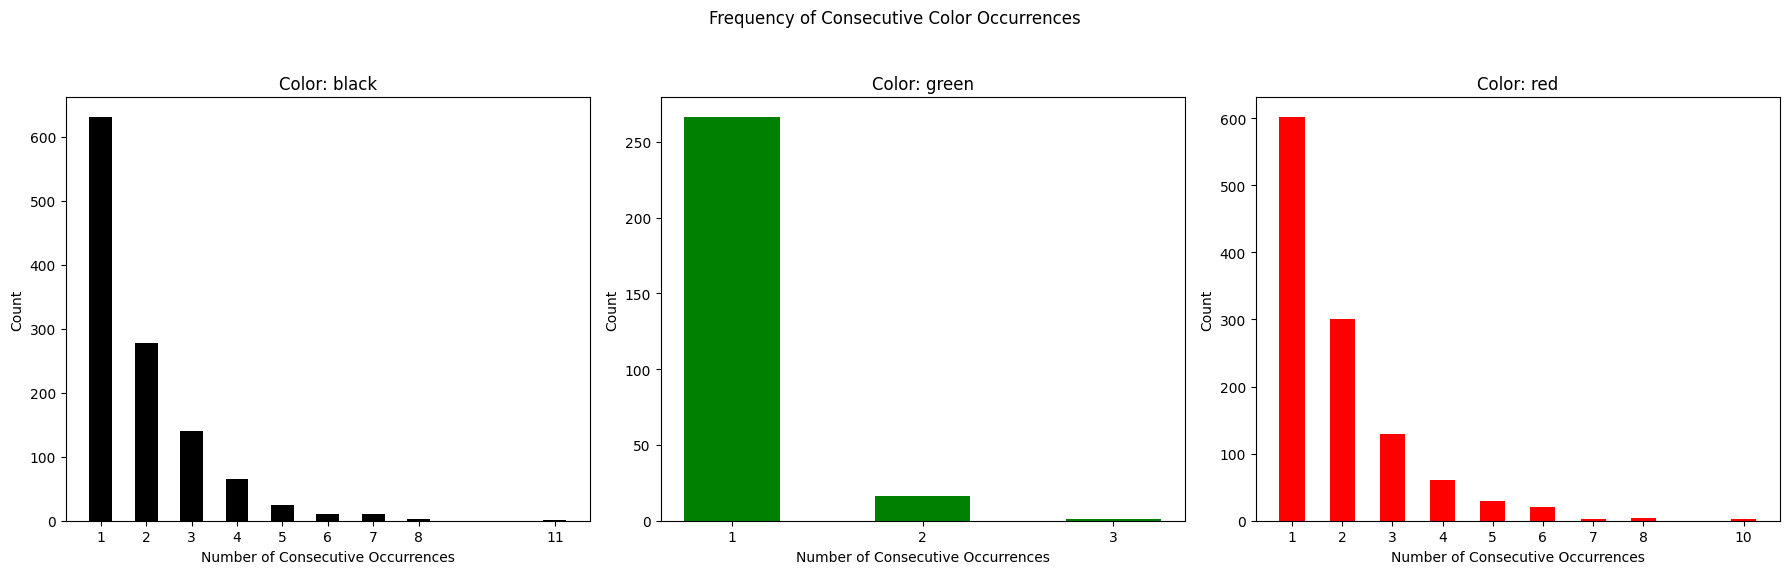

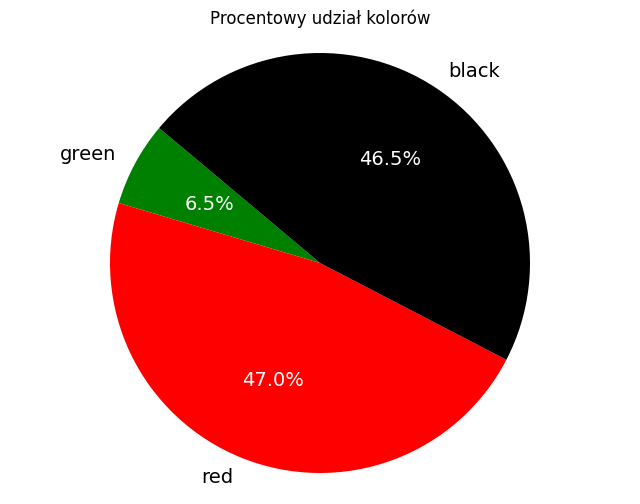


(2,)



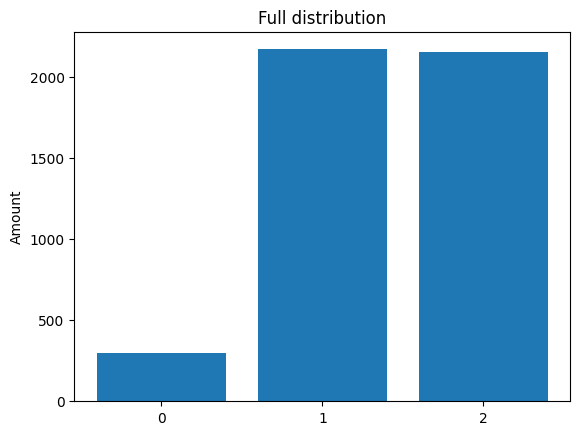

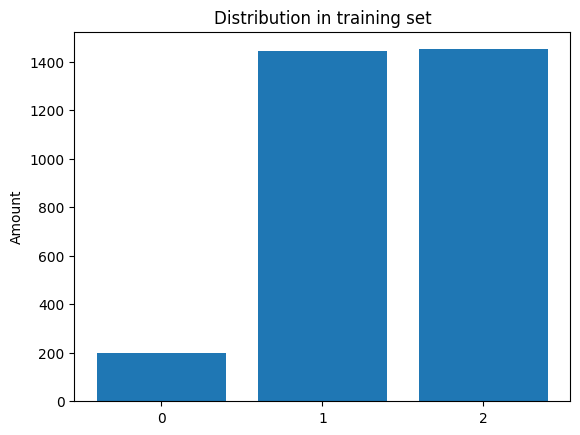

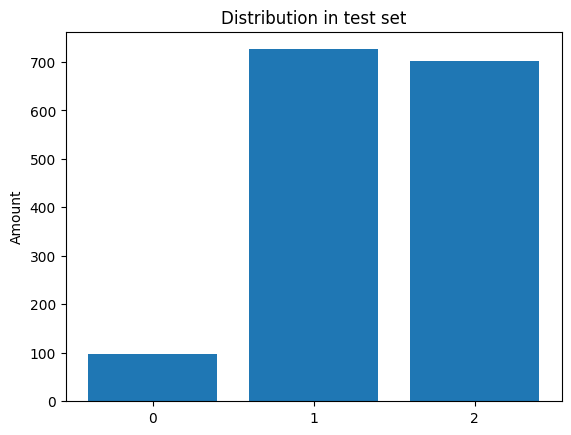

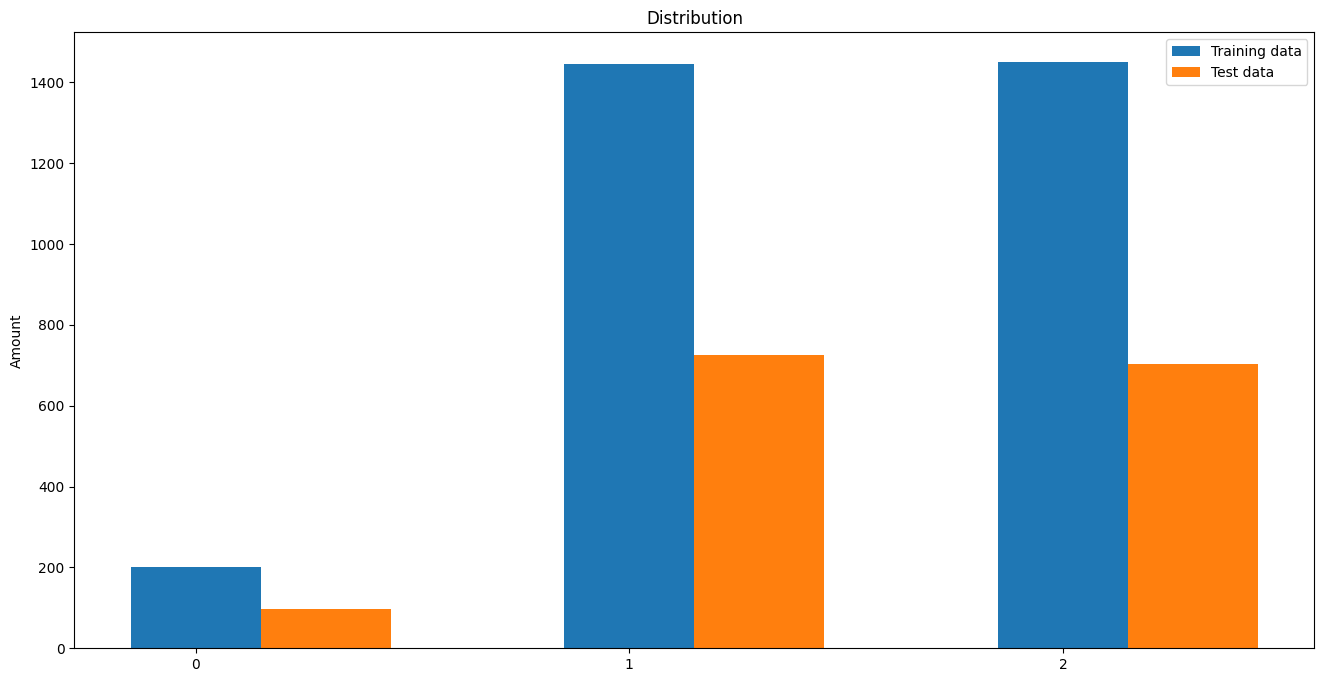


Example sequence from training set: [1 1] and its label: 1

Example sequence from test set: [1 2] and its label: 1


Gaussian Naive Bayes accuracy: 46.13%
Random forest classifier accuracy: 46.40%


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4793 - loss: 1.0172 - val_accuracy: 0.4620 - val_loss: 0.9668
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4681 - loss: 0.9555 - val_accuracy: 0.4620 - val_loss: 0.9349
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4809 - loss: 0.9294 - val_accuracy: 0.4600 - val_loss: 0.9164
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4676 - loss: 0.9215 - val_accuracy: 0.4600 - val_loss: 0.9054
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4693 - loss: 0.8923 - val_accuracy: 0.4600 - val_loss: 0.8987
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4574 - loss: 0.8983 - val_accuracy: 0.4600 - val_loss: 0.8944
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

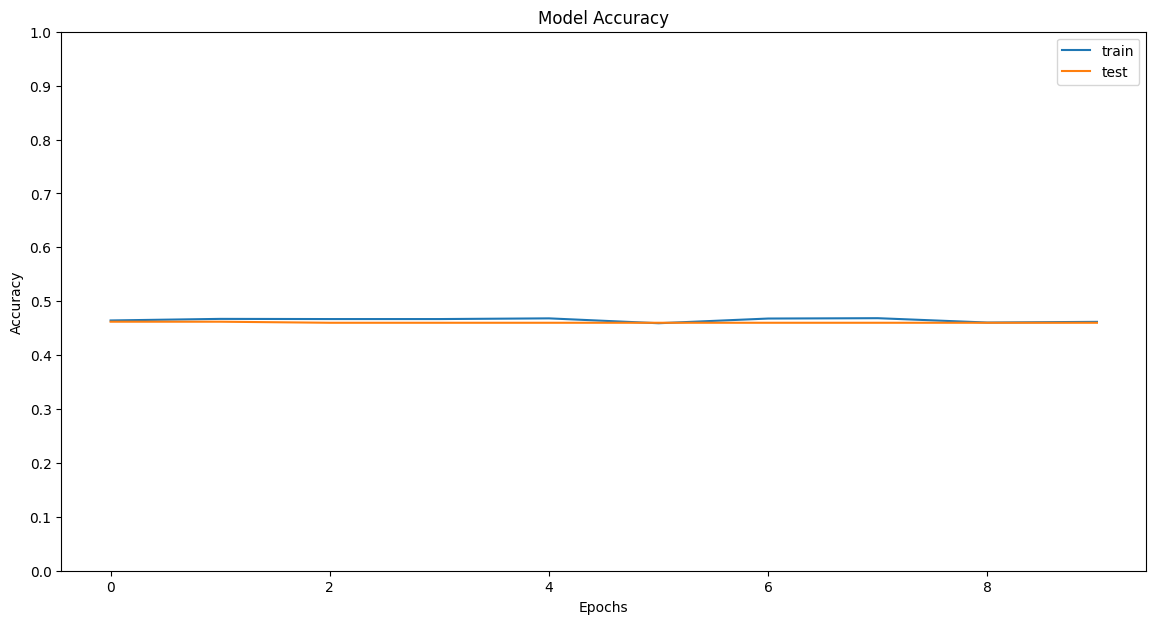

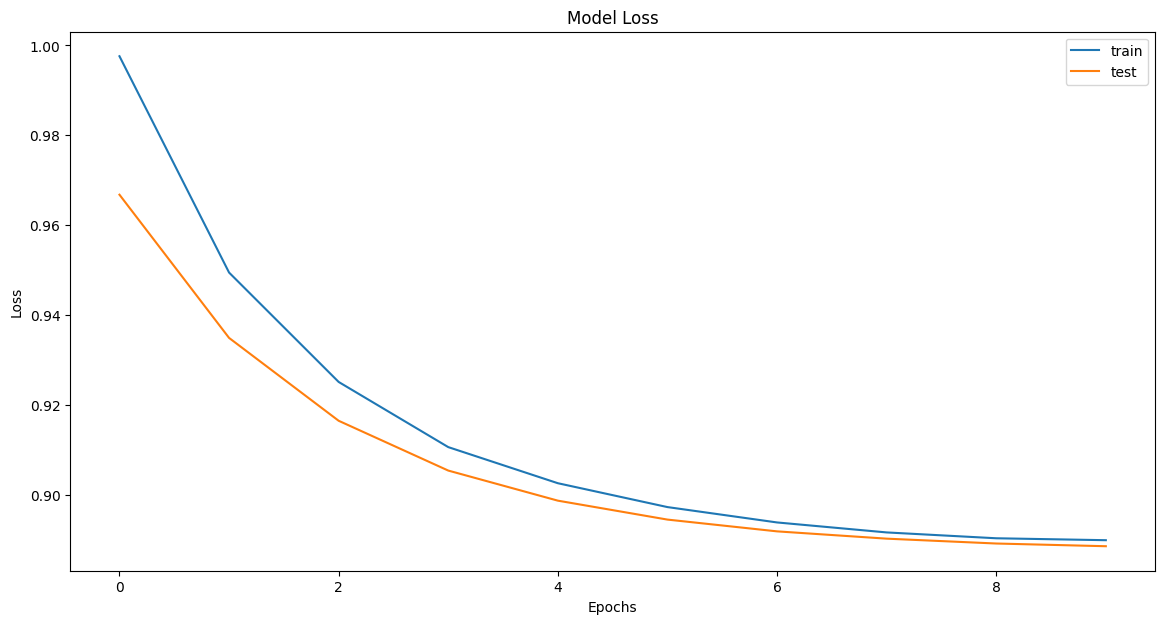

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
Modal accuracy on test set: 46.00%


For threshold set to 0.40, correctness is: 46.00%
For threshold set to 0.45, correctness is: 46.00%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.4647 - loss: 1.0922 - val_accuracy: 0.4758 - val_loss: 1.0200
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4767 - loss: 1.0029 - val_accuracy: 0.4758 - val_loss: 0.9622
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4670 - loss: 0.9583 - val_accuracy: 0.4758 - val_loss: 0.9205
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4894 - loss: 0.9059 - val_accuracy: 0.4758 - val_loss: 0.9030
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

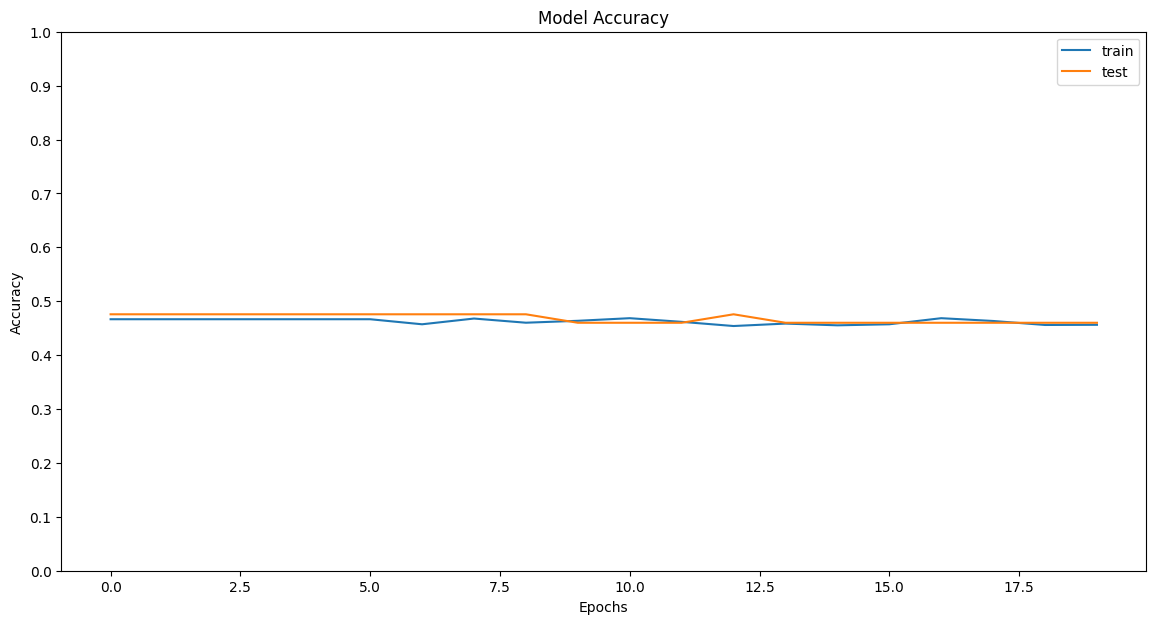

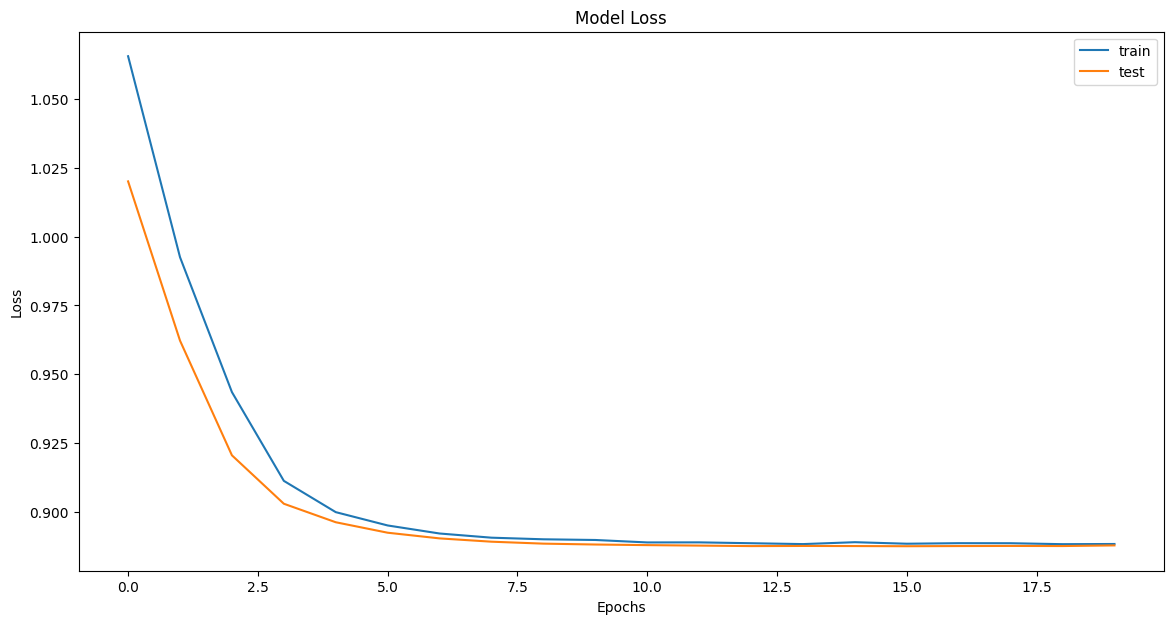

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
Modal accuracy on test set: 46.00%


For threshold set to 0.40, correctness is: 46.00%
For threshold set to 0.45, correctness is: 46.00%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.3279 - loss: 1.0525 - val_accuracy: 0.4758 - val_loss: 0.9540
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4700 - loss: 0.9464 - val_accuracy: 0.4758 - val_loss: 0.9261
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4664 - loss: 0.9218 - val_accuracy: 0.4758 - val_loss: 0.9110
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4525 - loss: 0.9161 - val_accuracy: 0.4738 - val_loss: 0.9020
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

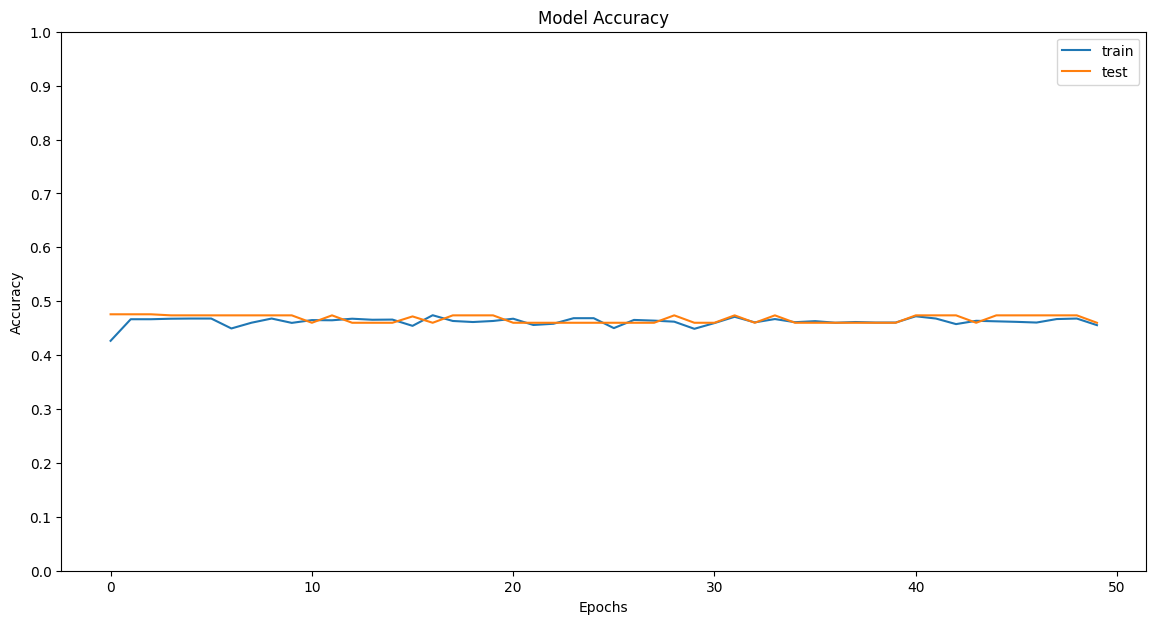

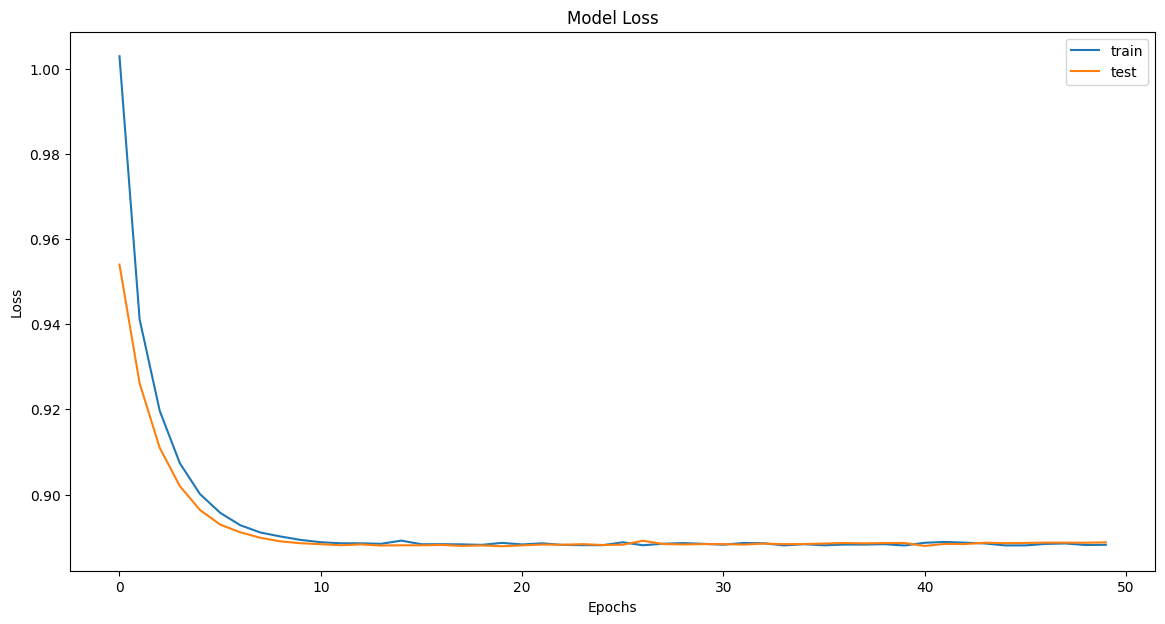

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
Modal accuracy on test set: 46.00%


For threshold set to 0.40, correctness is: 46.00%
For threshold set to 0.45, correctness is: 46.00%
For threshold set to 0.50, correctness is: 33.33%
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(5,)



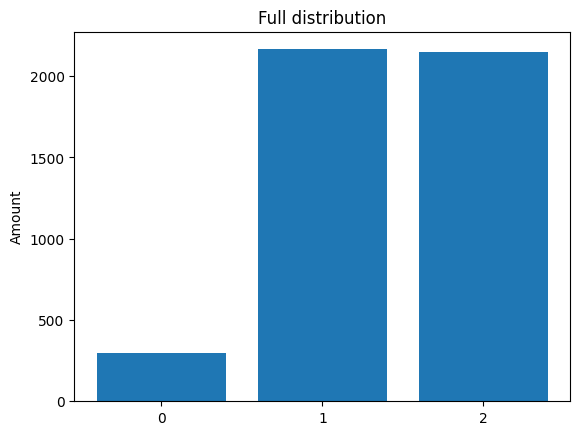

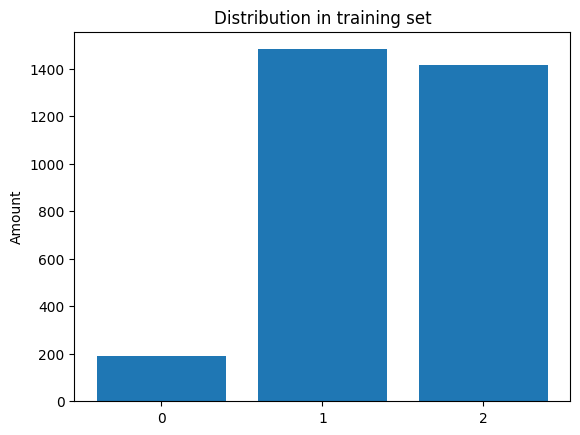

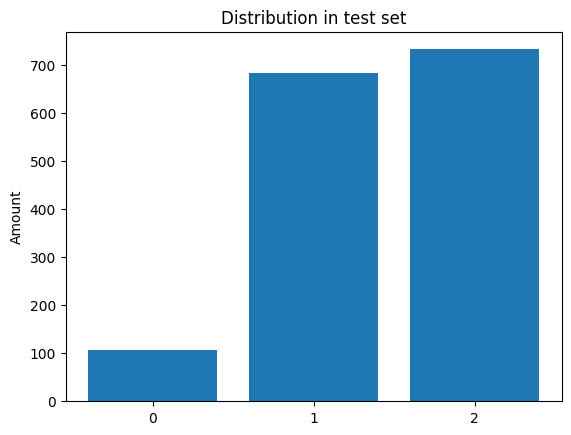

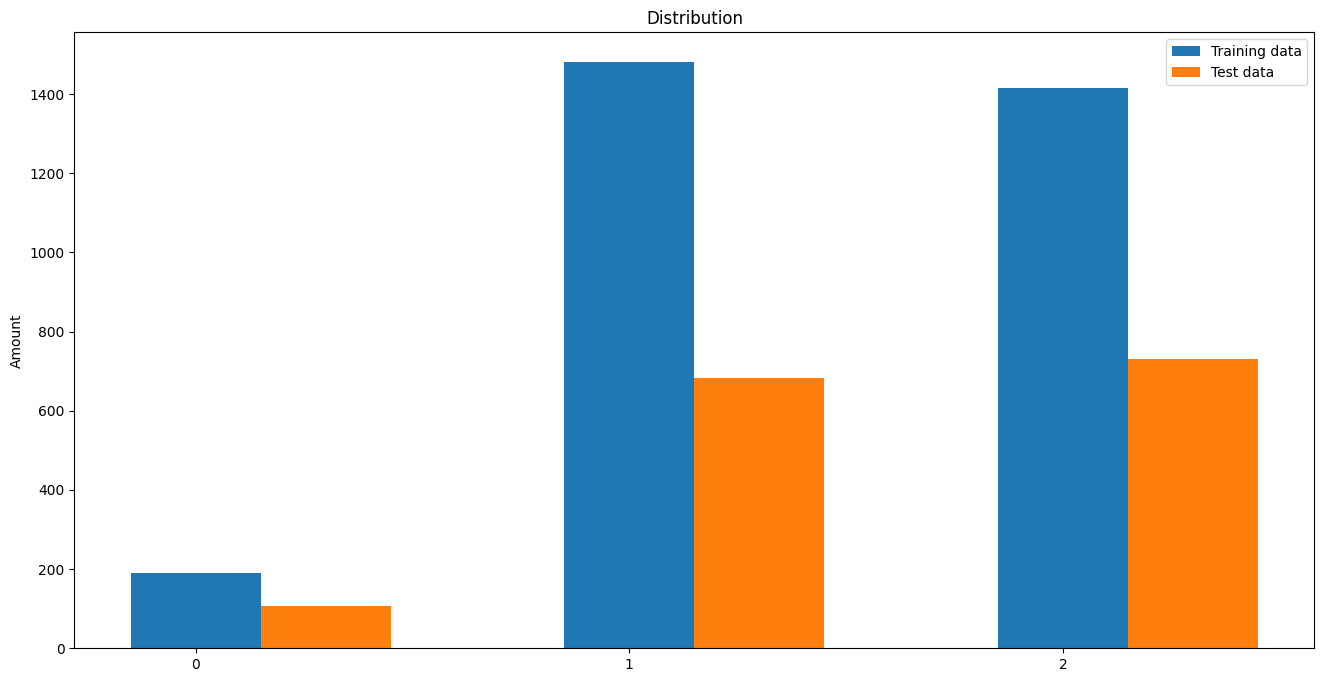


Example sequence from training set: [1 2 1 1 1] and its label: 2

Example sequence from test set: [1 2 1 1 1] and its label: 1


Gaussian Naive Bayes accuracy: 44.68%
Random forest classifier accuracy: 46.52%


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.4438 - loss: 1.0340 - val_accuracy: 0.4869 - val_loss: 0.9248
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4840 - loss: 0.9168 - val_accuracy: 0.4488 - val_loss: 0.9194
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4722 - loss: 0.9041 - val_accuracy: 0.4488 - val_loss: 0.9096
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4666 - loss: 0.8890 - val_accuracy: 0.4488 - val_loss: 0.9098
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4874 - loss: 0.8879 - val_accuracy: 0.4488 - val_loss: 0.9037
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4957 - loss: 0.8855 - val_accuracy: 0.4488 - val_loss: 0.9018
Epoch 7/10
97/97 ━━━━━━━━━━━━━━

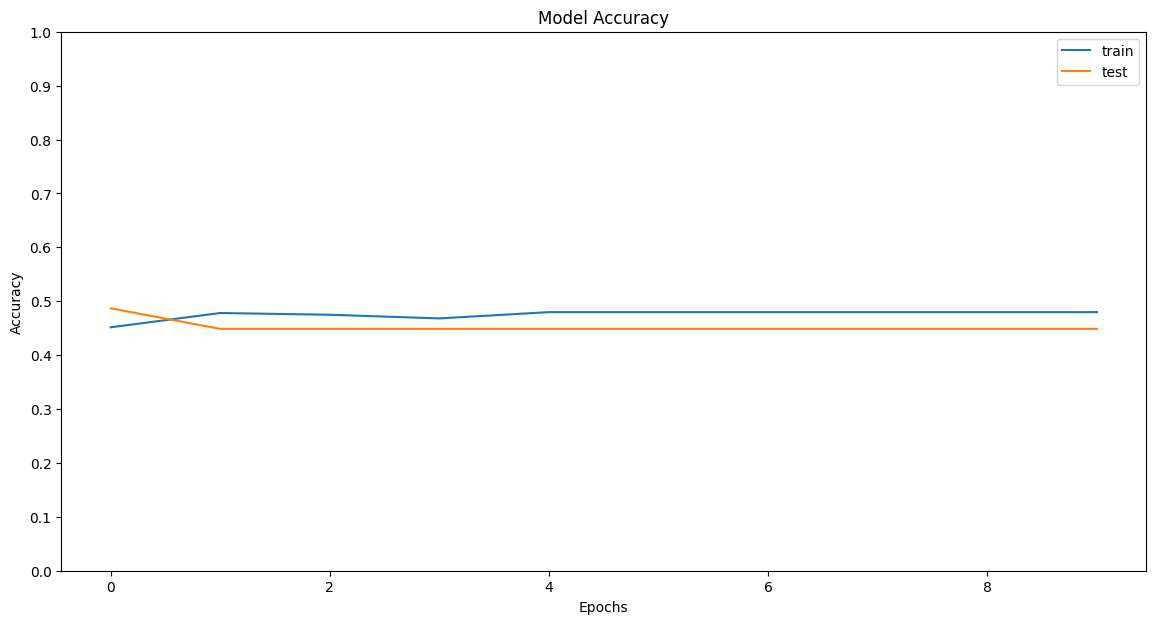

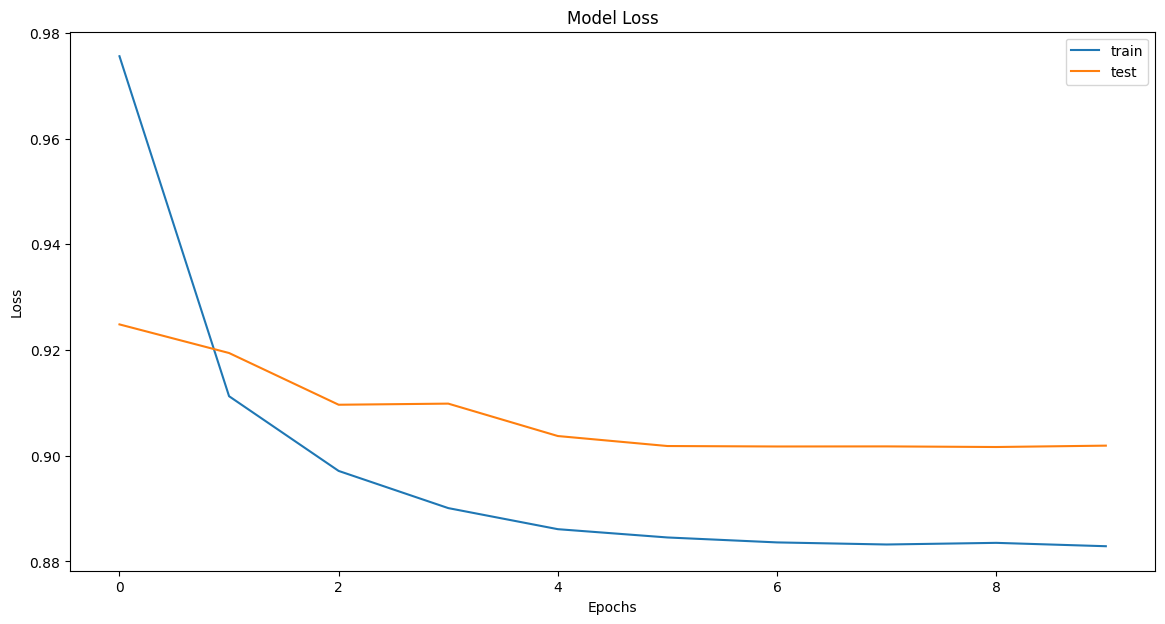

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
Modal accuracy on test set: 44.88%


For threshold set to 0.40, correctness is: 44.88%
For threshold set to 0.45, correctness is: 44.88%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4696 - loss: 0.9928 - val_accuracy: 0.4488 - val_loss: 0.9365
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4794 - loss: 0.9100 - val_accuracy: 0.4488 - val_loss: 0.9182
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4795 - loss: 0.9166 - val_accuracy: 0.4488 - val_loss: 0.9094
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4701 - loss: 0.8893 - val_accuracy: 0.4488 - val_loss: 0.9053
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

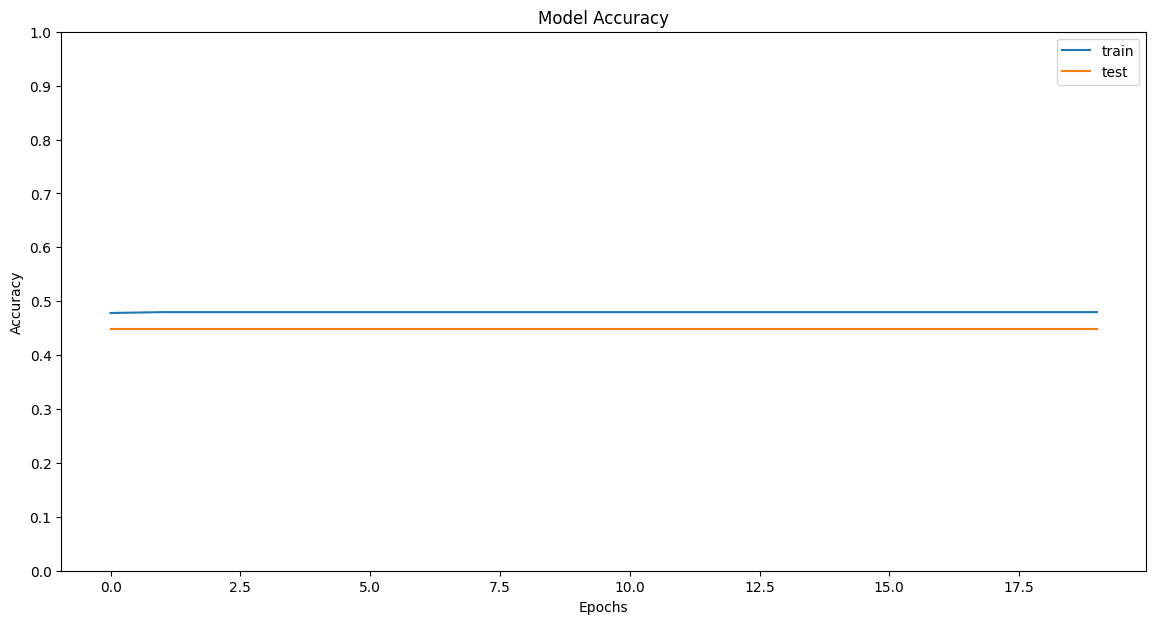

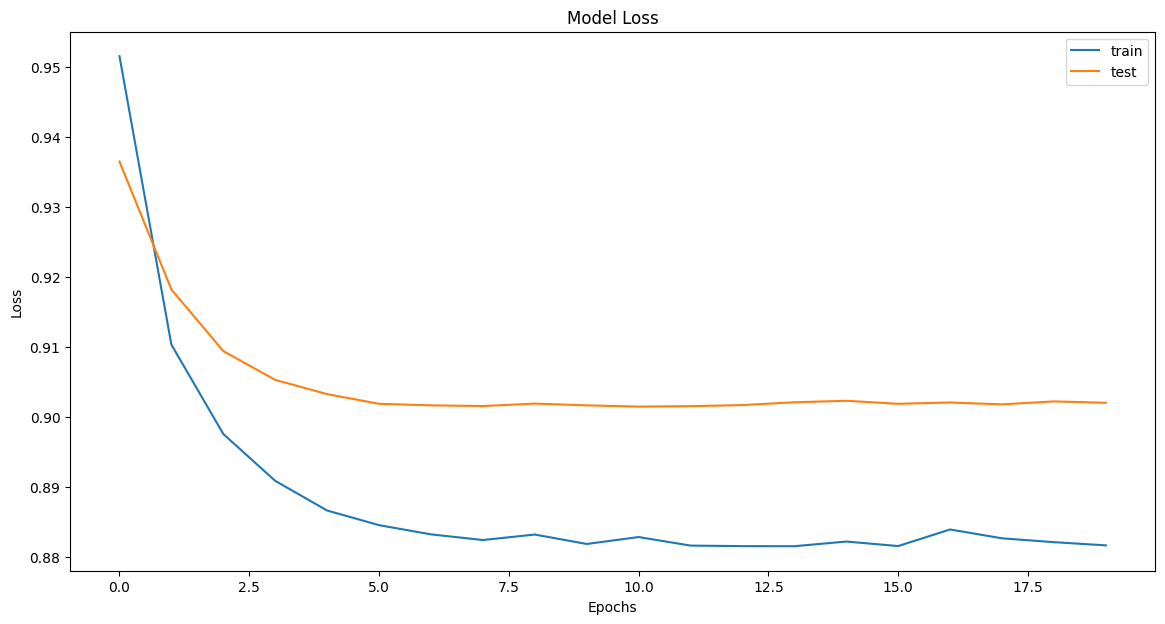

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 
Modal accuracy on test set: 44.88%


For threshold set to 0.40, correctness is: 44.88%
For threshold set to 0.45, correctness is: 44.88%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.4848 - loss: 1.0300 - val_accuracy: 0.4488 - val_loss: 0.9756
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4820 - loss: 0.9596 - val_accuracy: 0.4488 - val_loss: 0.9446
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4819 - loss: 0.9294 - val_accuracy: 0.4488 - val_loss: 0.9263
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4898 - loss: 0.9063 - val_accuracy: 0.4488 - val_loss: 0.9160
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

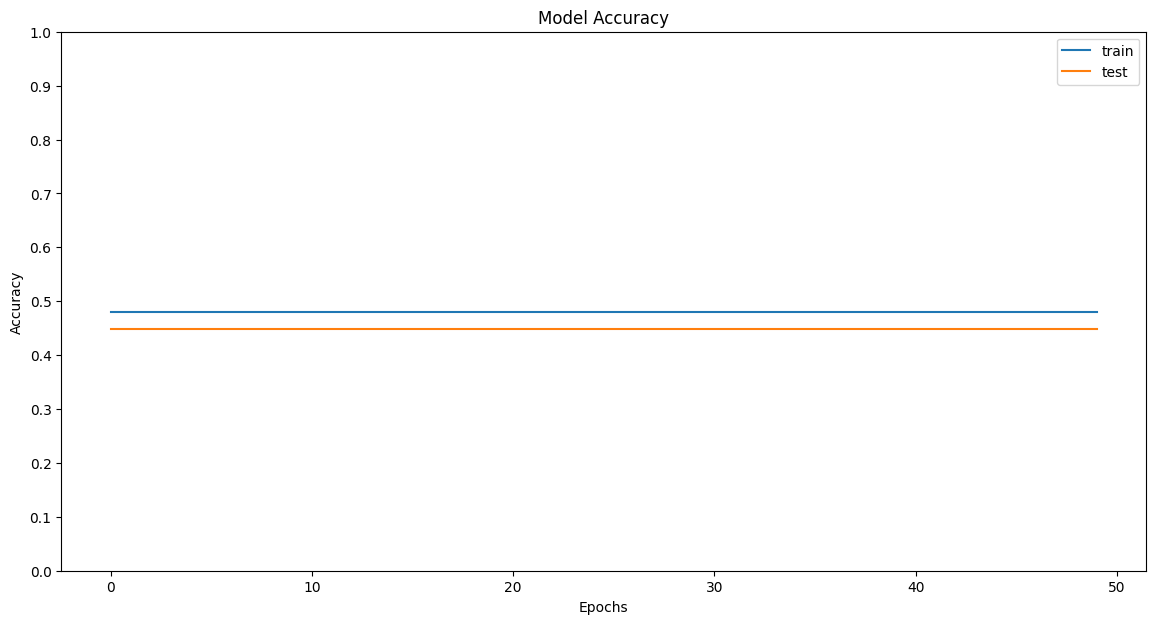

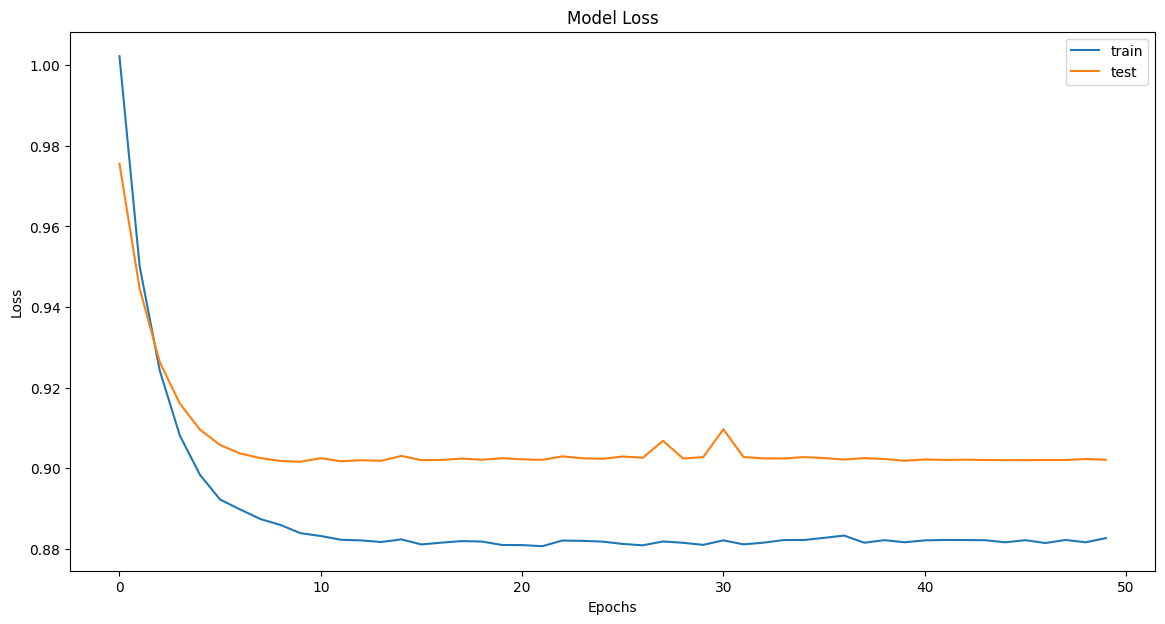

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
Modal accuracy on test set: 44.88%


For threshold set to 0.40, correctness is: 44.88%
For threshold set to 0.45, correctness is: 44.88%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(10,)



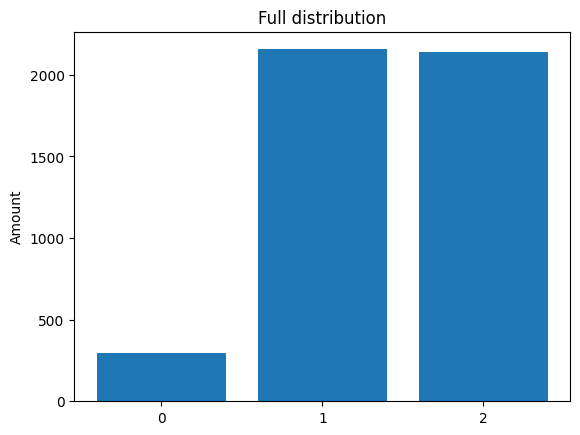

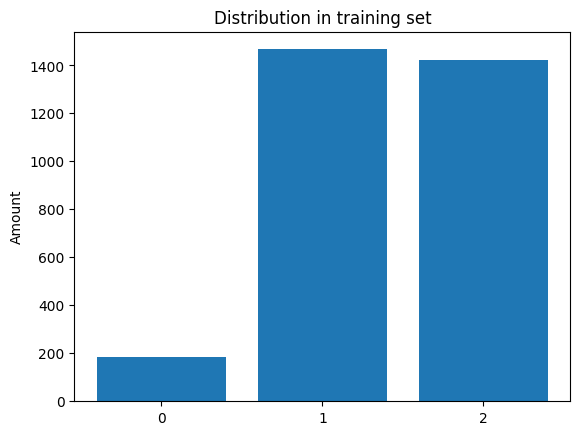

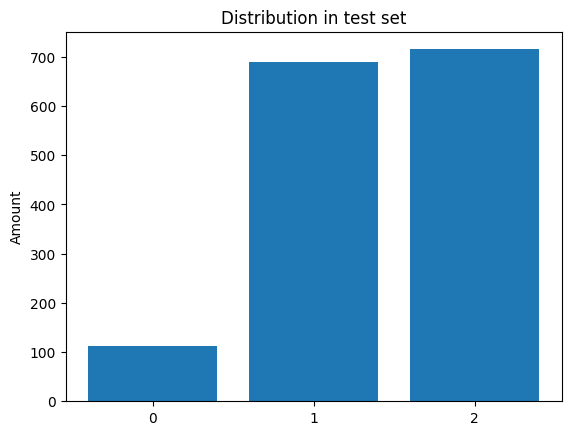

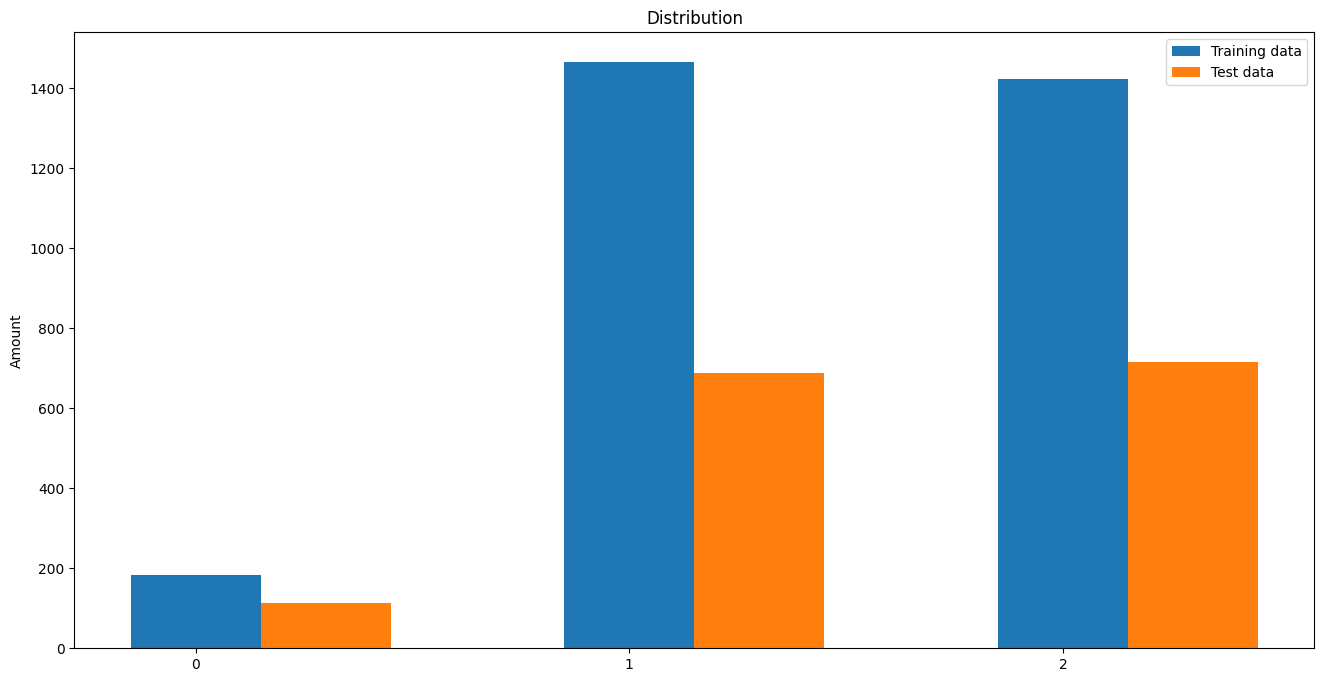


Example sequence from training set: [1 2 1 2 1 1 1 2 1 1] and its label: 1

Example sequence from test set: [2 1 1 1 2 1 1 1 1 1] and its label: 1


Gaussian Naive Bayes accuracy: 45.78%
Random forest classifier accuracy: 48.15%


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.4709 - loss: 0.9940 - val_accuracy: 0.4545 - val_loss: 0.9401
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4715 - loss: 0.9121 - val_accuracy: 0.4545 - val_loss: 0.9171
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4879 - loss: 0.8943 - val_accuracy: 0.4545 - val_loss: 0.9091
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4721 - loss: 0.8959 - val_accuracy: 0.4545 - val_loss: 0.9062
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4744 - loss: 0.8783 - val_accuracy: 0.4545 - val_loss: 0.9047
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4870 - loss: 0.8729 - val_accuracy: 0.4545 - val_loss: 0.9041
Epoch 7/10


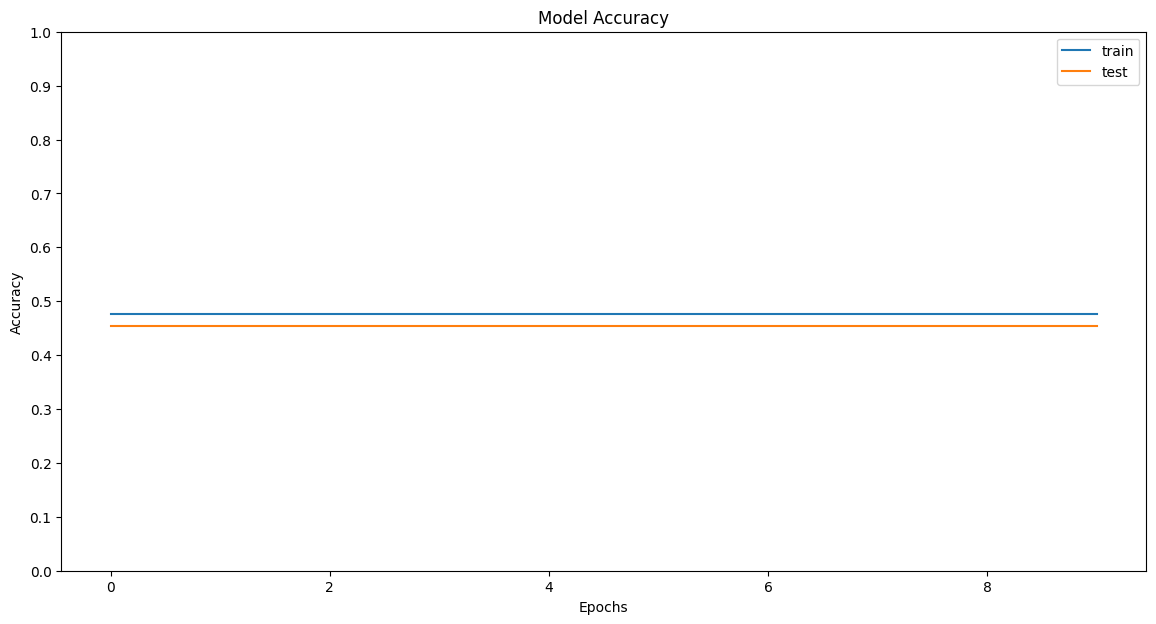

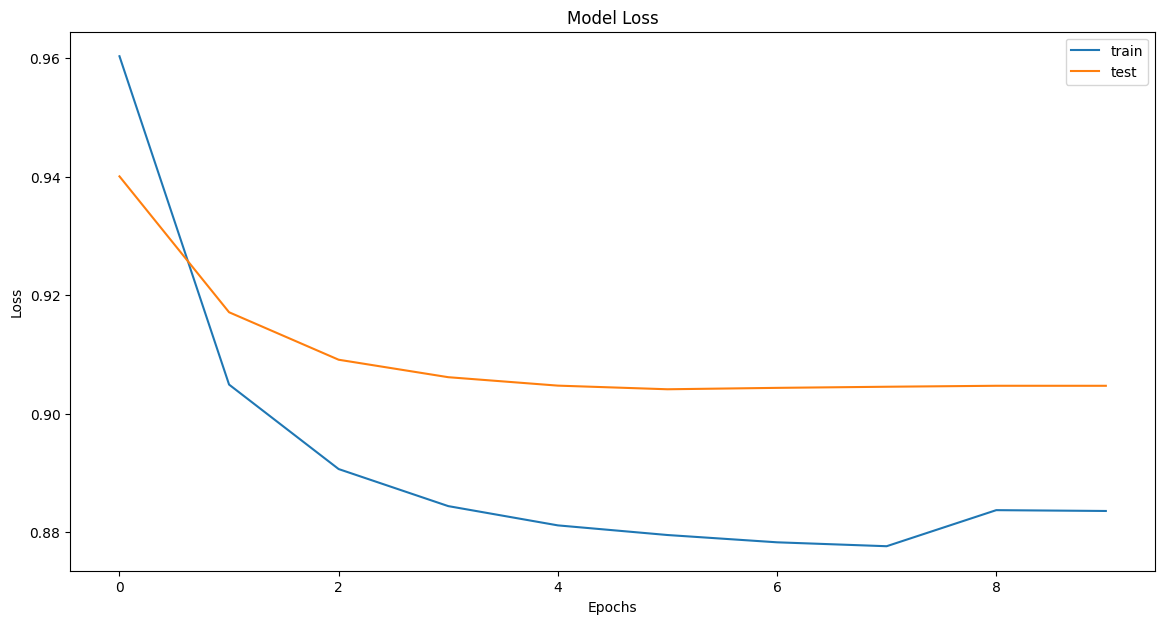

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 
Modal accuracy on test set: 45.45%


For threshold set to 0.40, correctness is: 45.45%
For threshold set to 0.45, correctness is: 45.45%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4663 - loss: 0.9700 - val_accuracy: 0.4716 - val_loss: 0.9251
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4546 - loss: 0.9075 - val_accuracy: 0.4716 - val_loss: 0.9146
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4633 - loss: 0.9041 - val_accuracy: 0.4545 - val_loss: 0.9090
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4768 - loss: 0.8933 - val_accuracy: 0.4545 - val_loss: 0.9064
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

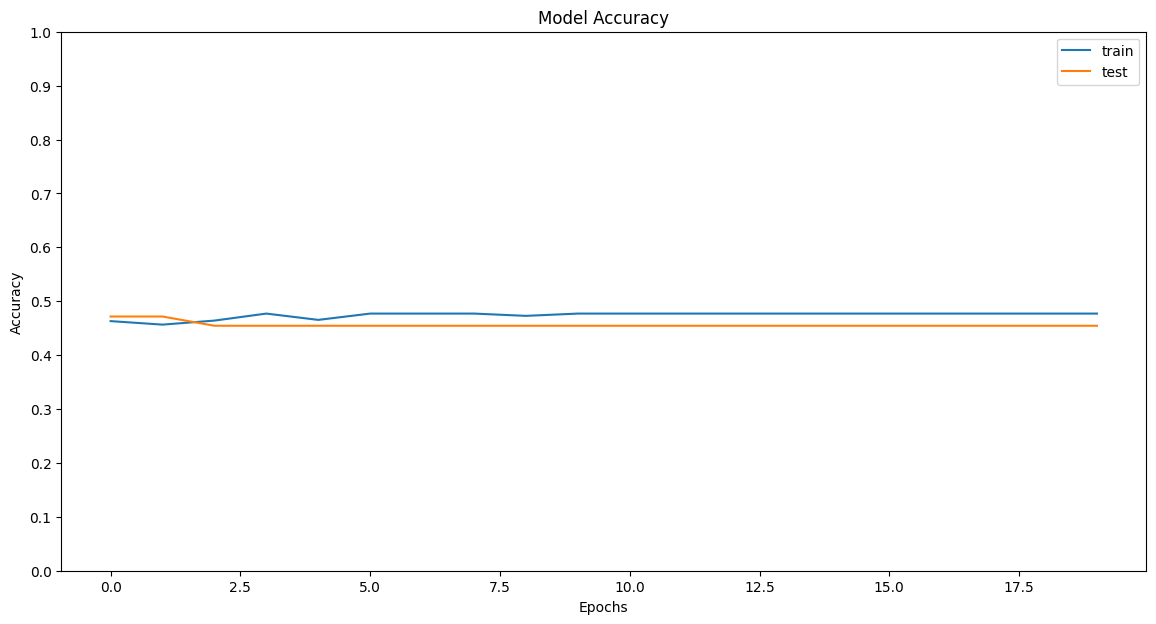

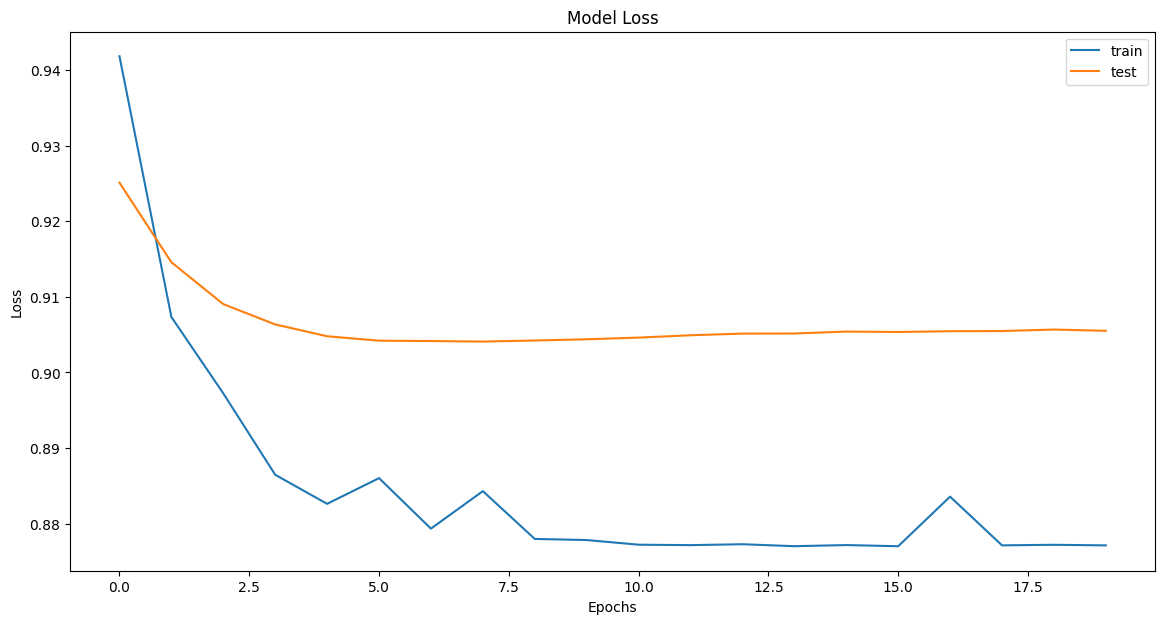

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
Modal accuracy on test set: 45.45%


For threshold set to 0.40, correctness is: 45.45%
For threshold set to 0.45, correctness is: 45.45%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.4699 - loss: 1.0200 - val_accuracy: 0.4545 - val_loss: 0.9295
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4825 - loss: 0.9094 - val_accuracy: 0.4545 - val_loss: 0.9170
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4721 - loss: 0.8994 - val_accuracy: 0.4545 - val_loss: 0.9106
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4897 - loss: 0.9011 - val_accuracy: 0.4545 - val_loss: 0.9070
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

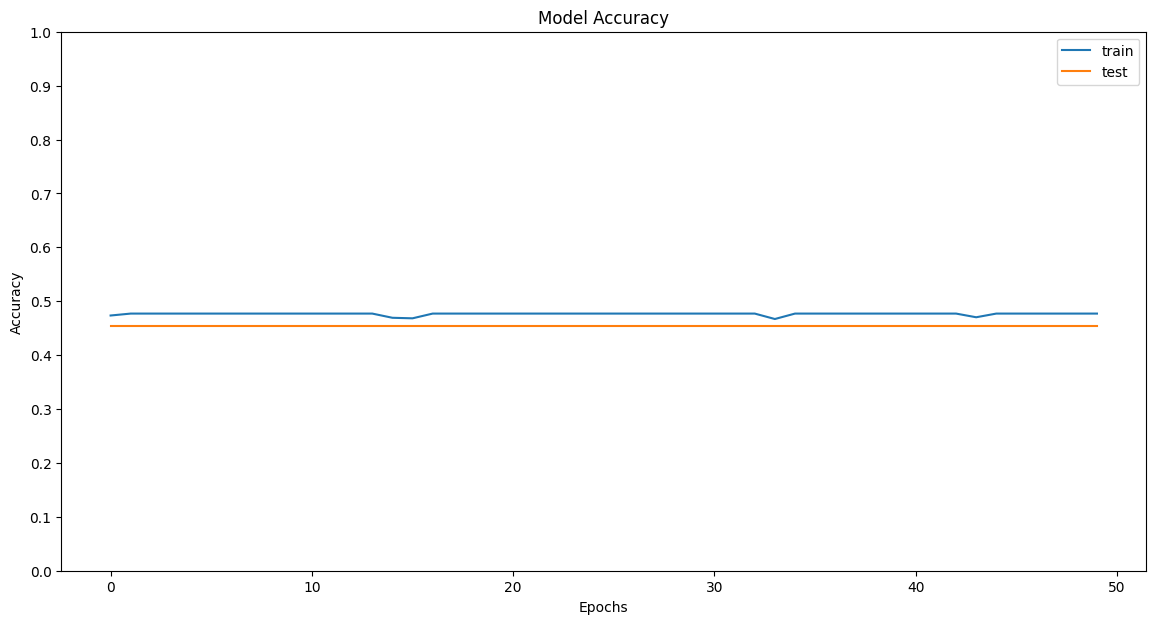

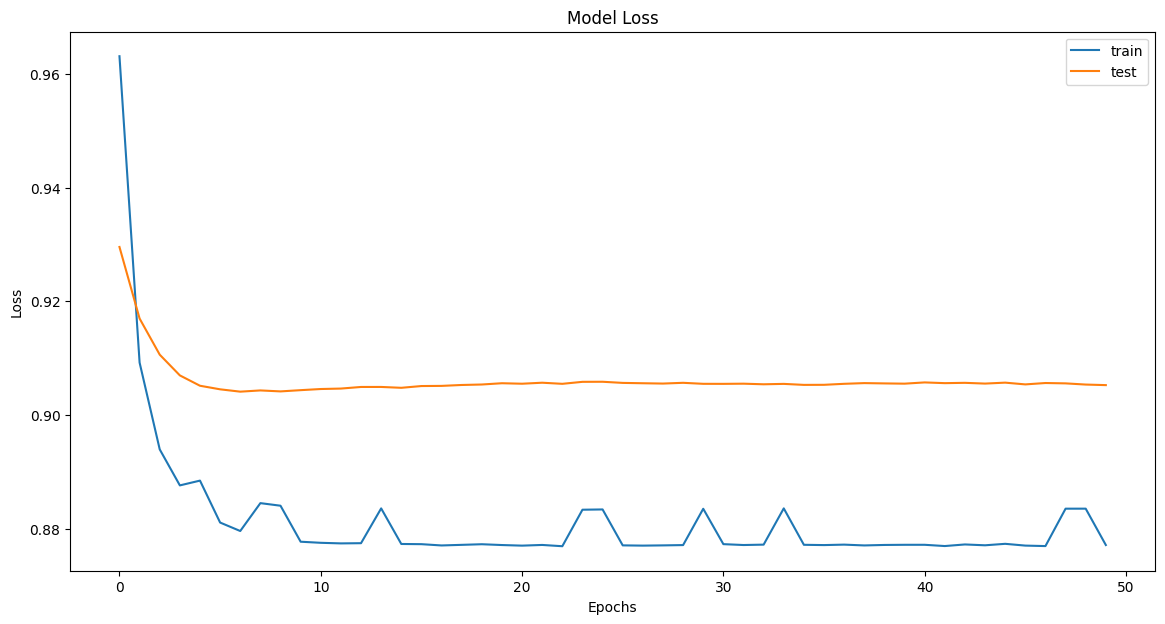

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
Modal accuracy on test set: 45.45%


For threshold set to 0.40, correctness is: 45.45%
For threshold set to 0.45, correctness is: 45.45%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(15,)



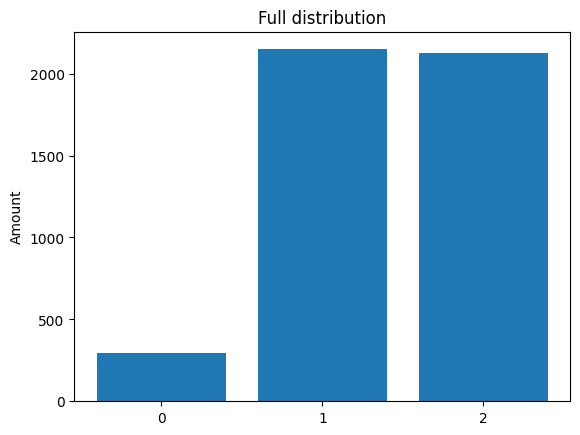

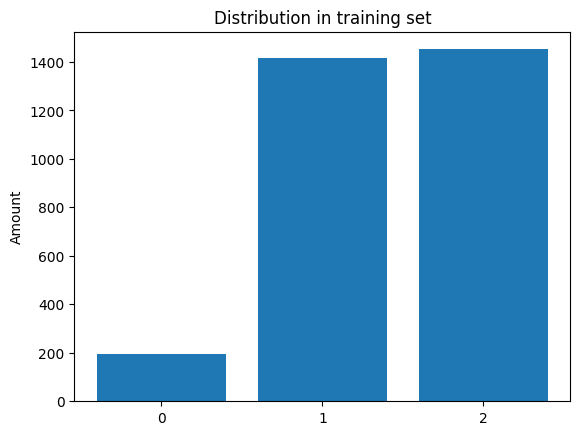

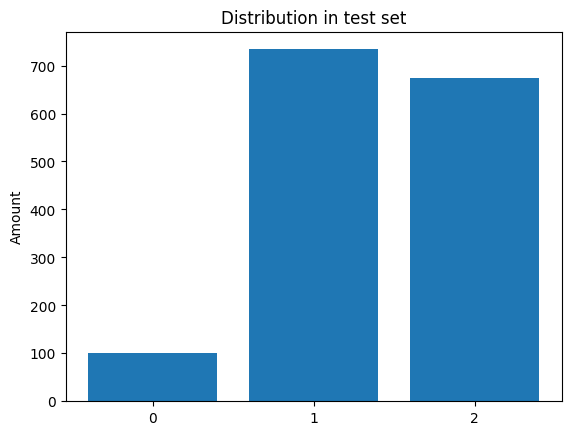

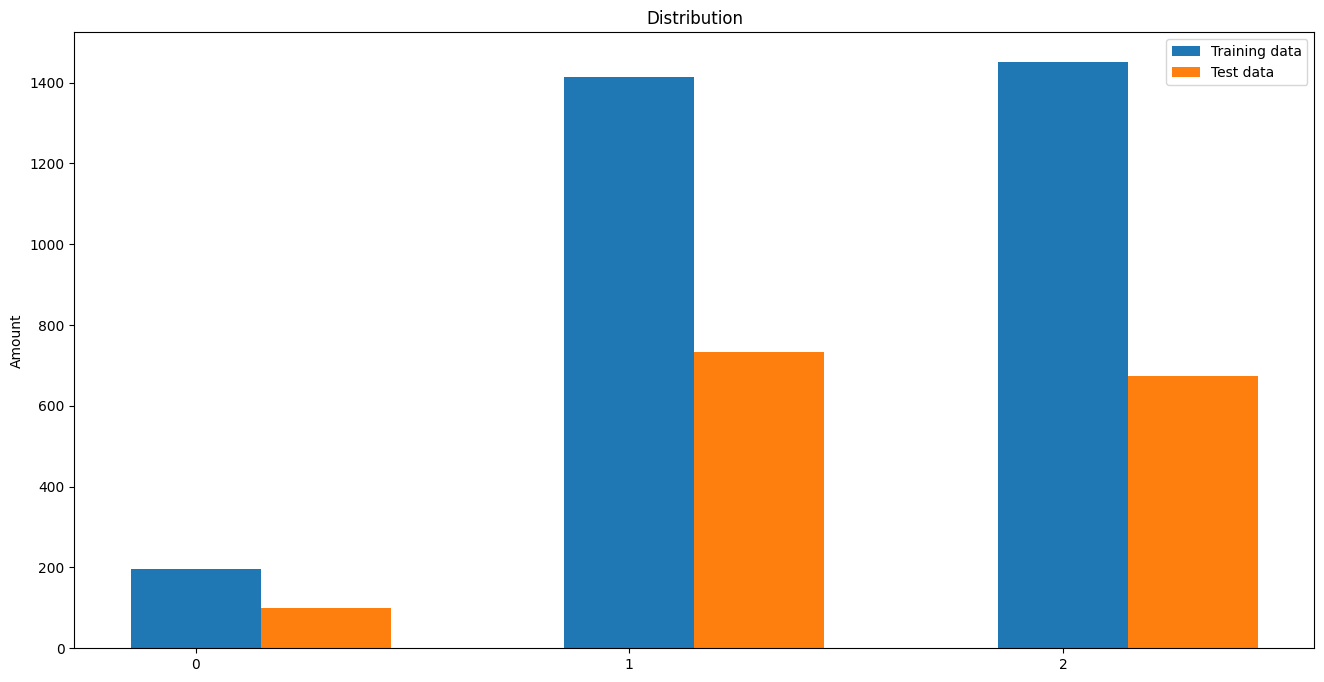


Example sequence from training set: [1 1 1 2 2 2 1 1 0 1 2 2 1 1 2] and its label: 2

Example sequence from test set: [2 2 1 2 1 2 1 2 2 1 2 2 0 1 2] and its label: 2


Gaussian Naive Bayes accuracy: 46.19%
Random forest classifier accuracy: 45.53%


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.4557 - loss: 0.9760 - val_accuracy: 0.4864 - val_loss: 0.9139
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4501 - loss: 0.9145 - val_accuracy: 0.4864 - val_loss: 0.9053
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4686 - loss: 0.8981 - val_accuracy: 0.4864 - val_loss: 0.9005
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4824 - loss: 0.8924 - val_accuracy: 0.4473 - val_loss: 0.8981
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4872 - loss: 0.8832 - val_accuracy: 0.4473 - val_loss: 0.8972
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4699 - loss: 0.8809 - val_accuracy: 0.4473 - val_loss

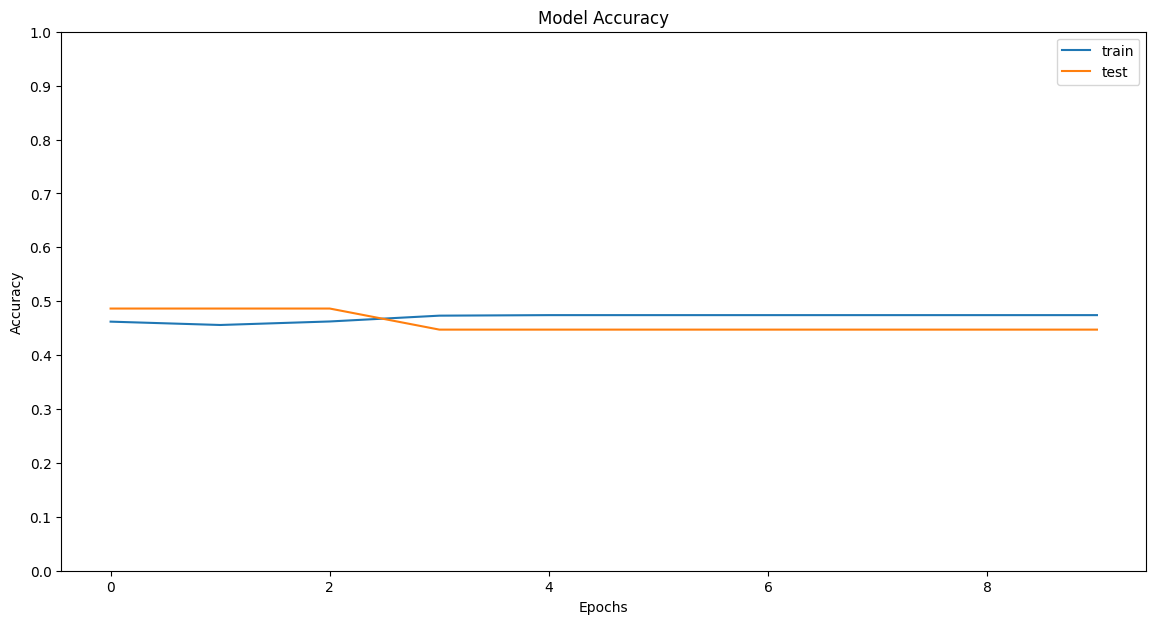

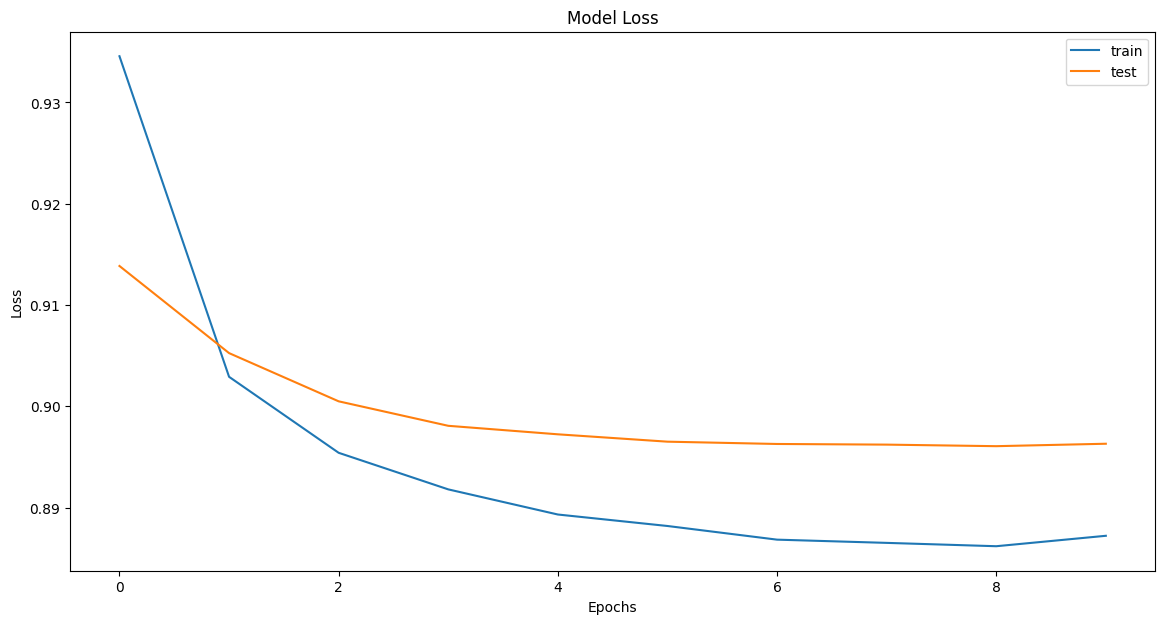

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Modal accuracy on test set: 44.73%


For threshold set to 0.40, correctness is: 44.73%
For threshold set to 0.45, correctness is: 44.73%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4919 - loss: 1.0507 - val_accuracy: 0.4864 - val_loss: 0.9211
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4668 - loss: 0.9138 - val_accuracy: 0.4473 - val_loss: 0.9095
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4921 - loss: 0.8972 - val_accuracy: 0.4473 - val_loss: 0.9033
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4714 - loss: 0.8955 - val_accuracy: 0.4473 - val_loss: 0.8999
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy:

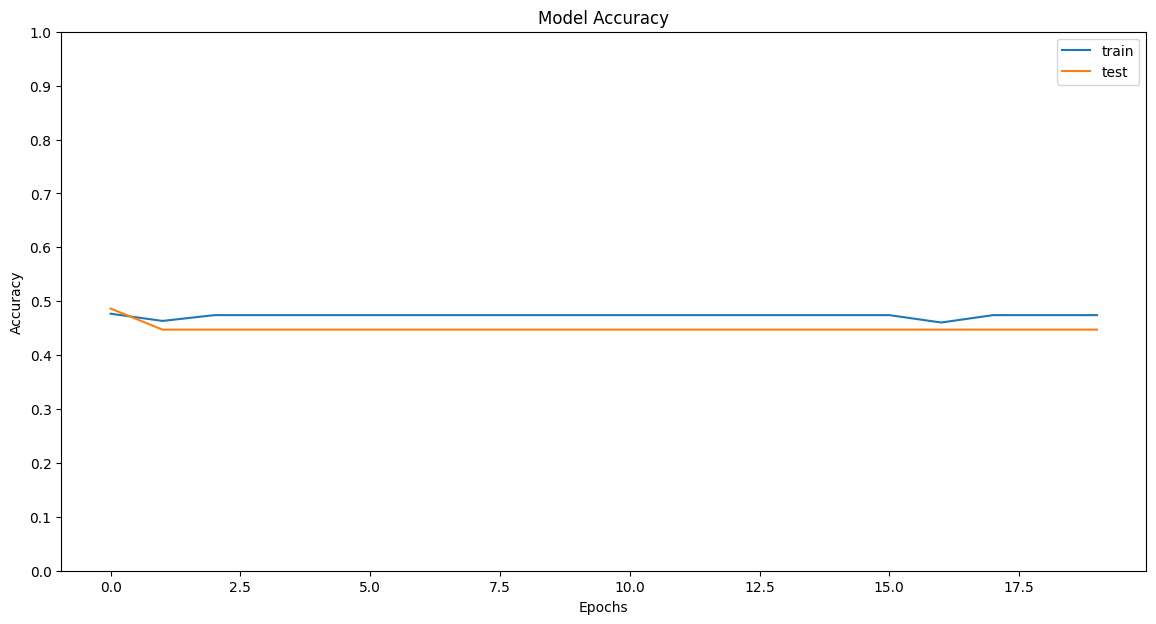

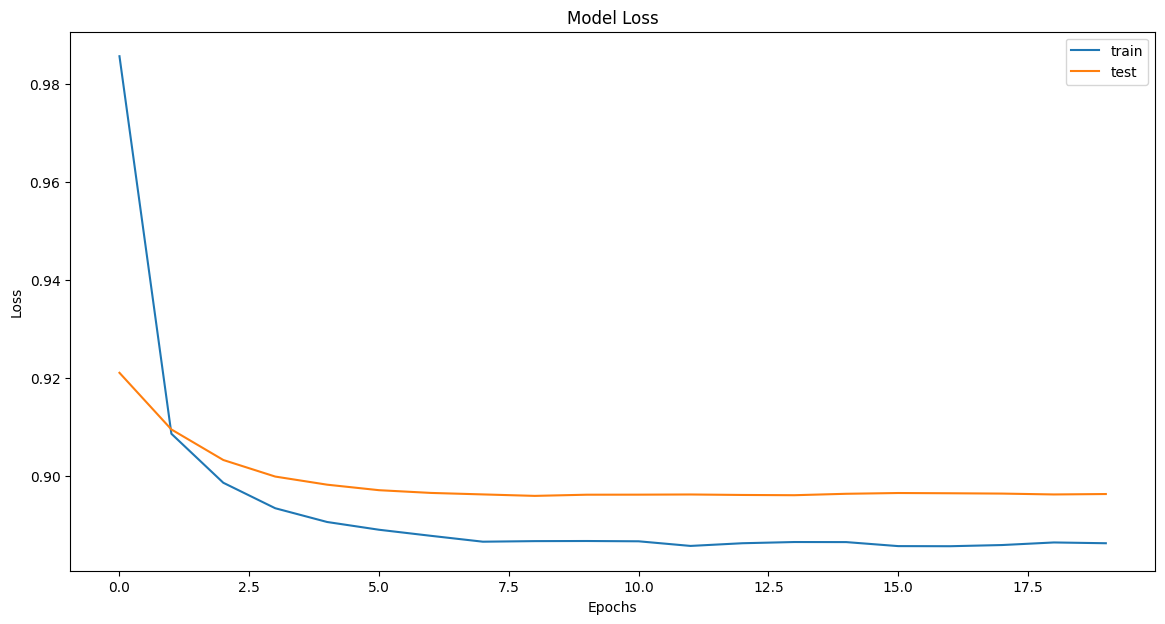

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
Modal accuracy on test set: 44.73%


For threshold set to 0.40, correctness is: 44.73%
For threshold set to 0.45, correctness is: 44.73%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.4763 - loss: 0.9894 - val_accuracy: 0.4473 - val_loss: 0.9327
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4860 - loss: 0.9102 - val_accuracy: 0.4473 - val_loss: 0.9145
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4812 - loss: 0.9050 - val_accuracy: 0.4473 - val_loss: 0.9060
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4763 - loss: 0.8990 - val_accuracy: 0.4473 - val_loss: 0.9011
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

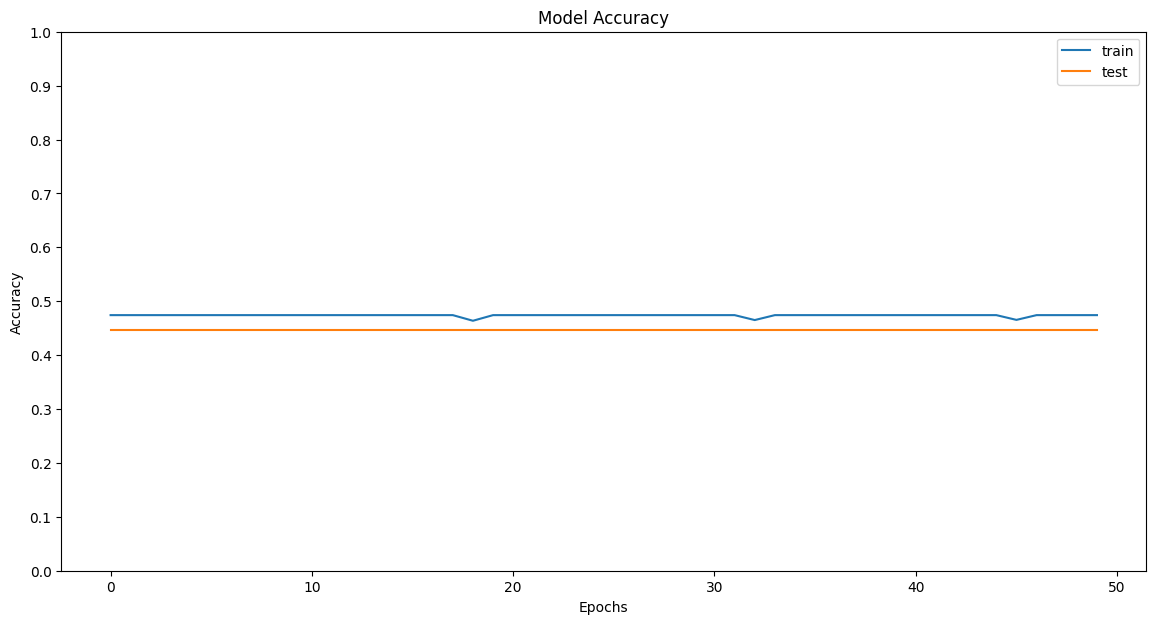

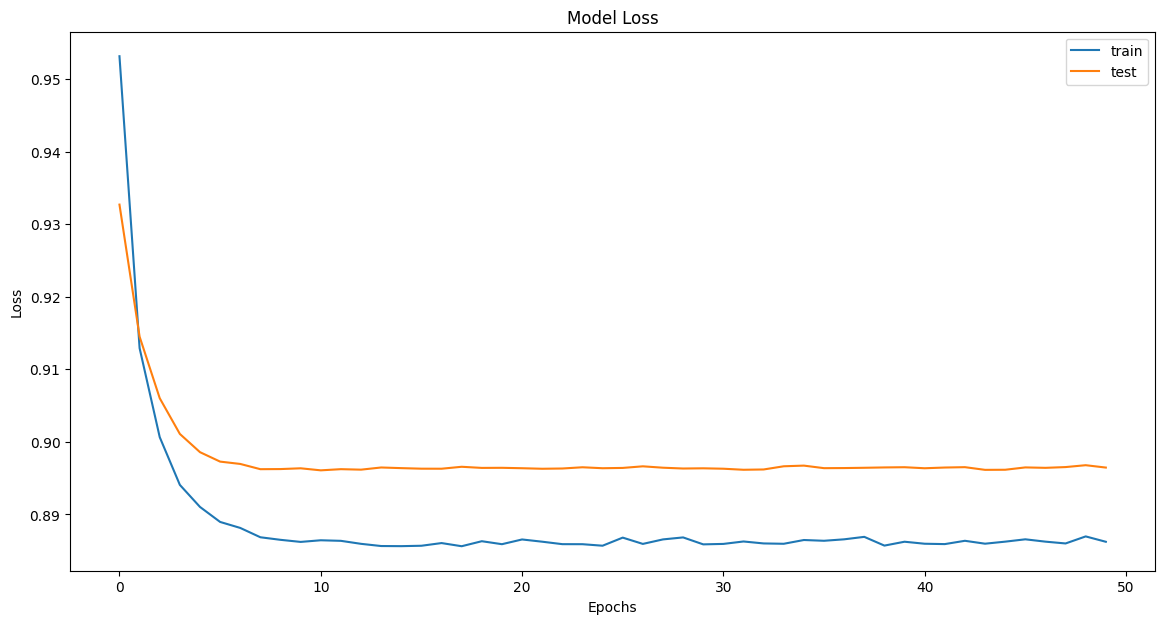

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
Modal accuracy on test set: 44.73%


For threshold set to 0.40, correctness is: 44.73%
For threshold set to 0.45, correctness is: 44.73%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(20,)



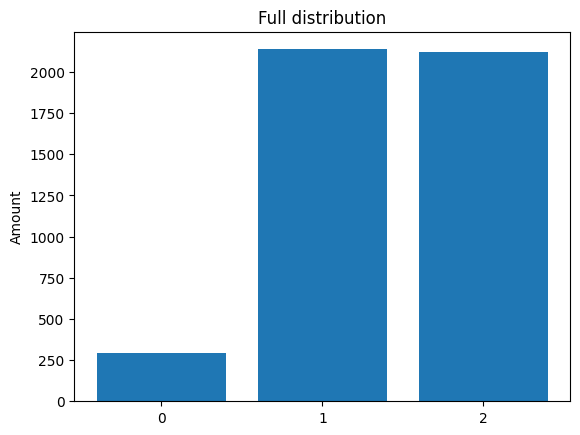

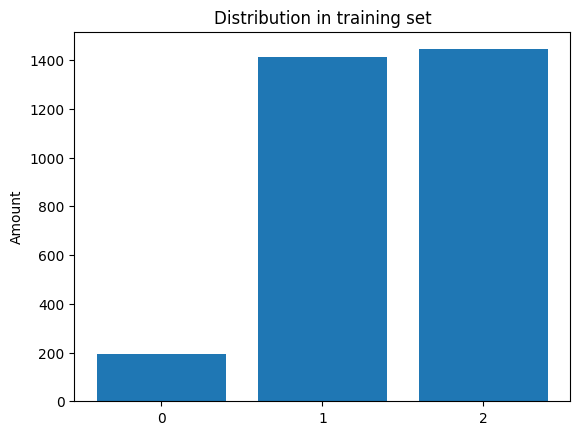

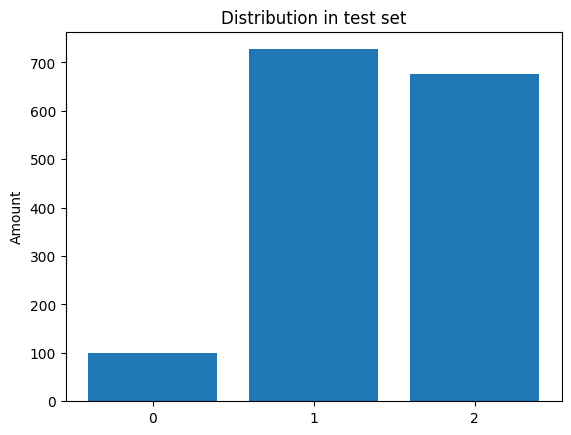

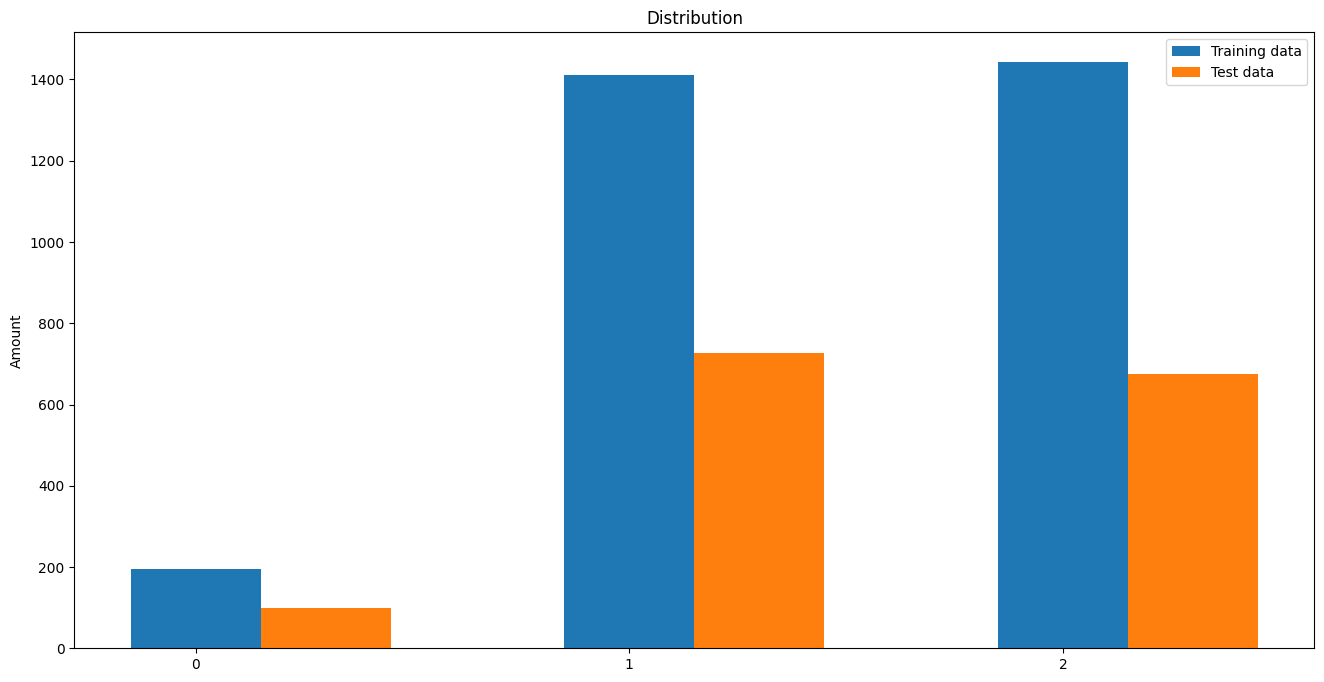


Example sequence from training set: [1 1 1 1 1 1 1 0 2 2 1 1 1 1 1 1 2 1 2 2] and its label: 1

Example sequence from test set: [1 1 1 2 2 2 2 2 1 1 1 2 2 2 1 1 2 0 1 1] and its label: 1


Gaussian Naive Bayes accuracy: 45.54%
Random forest classifier accuracy: 47.87%


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.4654 - loss: 0.9787 - val_accuracy: 0.4501 - val_loss: 0.9201
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4707 - loss: 0.9091 - val_accuracy: 0.4501 - val_loss: 0.9070
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4936 - loss: 0.8977 - val_accuracy: 0.4501 - val_loss: 0.8998
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4704 - loss: 0.9016 - val_accuracy: 0.4501 - val_loss: 0.8959
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4608 - loss: 0.8818 - val_accuracy: 0.4501 - val_loss: 0.8939
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4679 - loss: 0.8904 - val_accurac

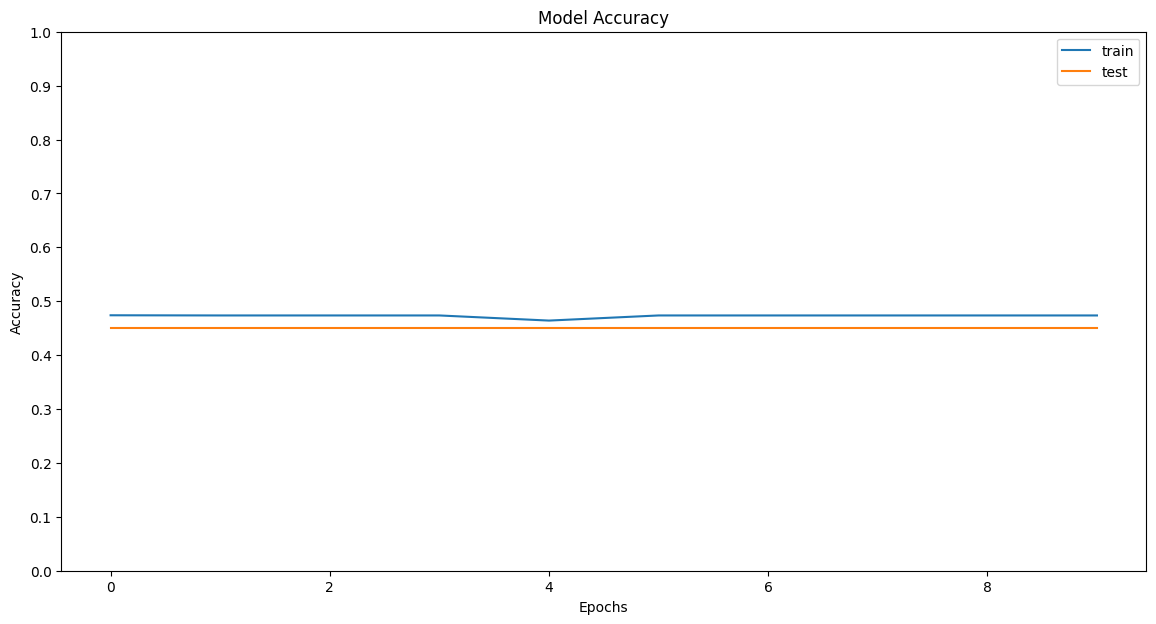

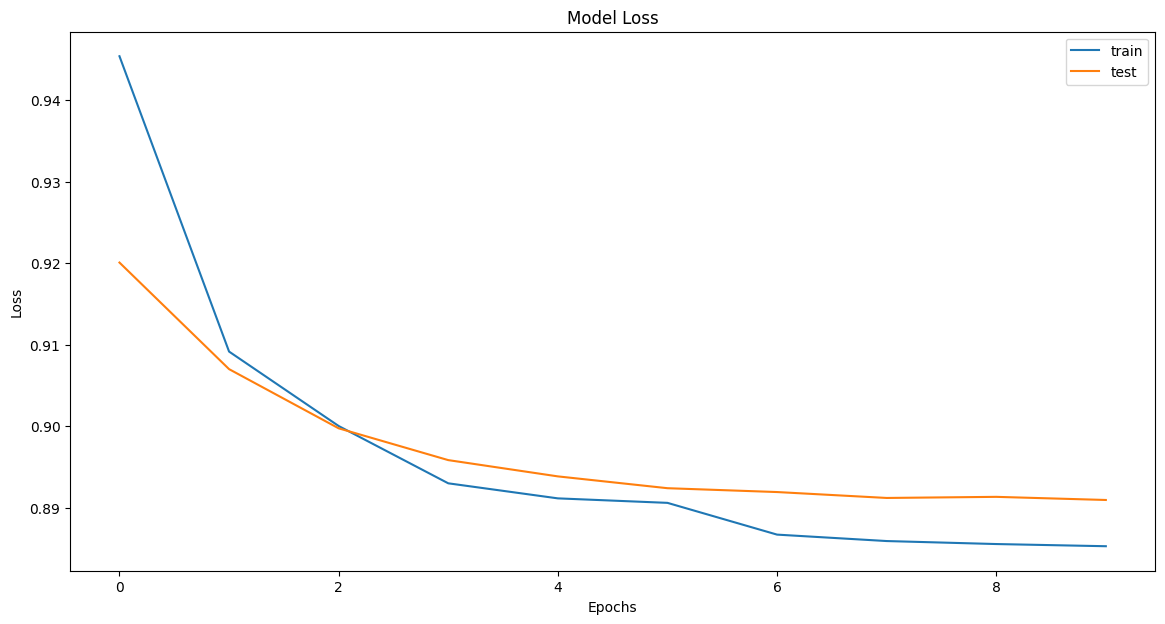

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 
Modal accuracy on test set: 45.01%


For threshold set to 0.40, correctness is: 45.01%
For threshold set to 0.45, correctness is: 45.01%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4712 - loss: 1.0149 - val_accuracy: 0.4501 - val_loss: 0.9177
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4689 - loss: 0.9159 - val_accuracy: 0.4501 - val_loss: 0.9051
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4731 - loss: 0.9029 - val_accuracy: 0.4501 - val_loss: 0.8985
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4648 - loss: 0.8948 - val_accuracy: 0.4501 - val_loss: 0.8949
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

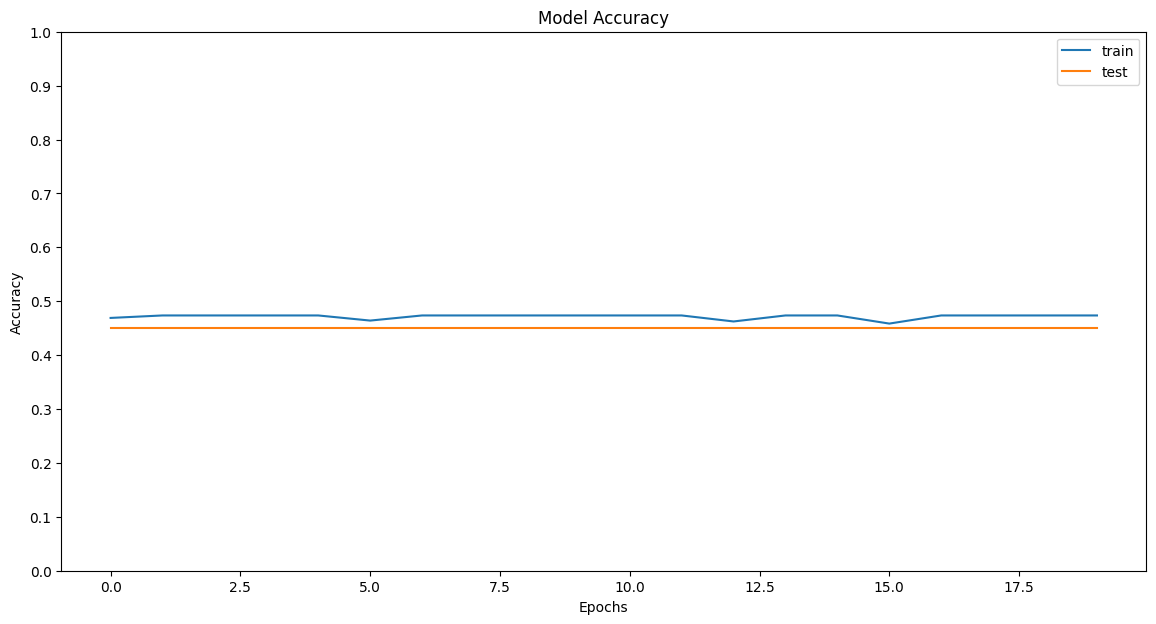

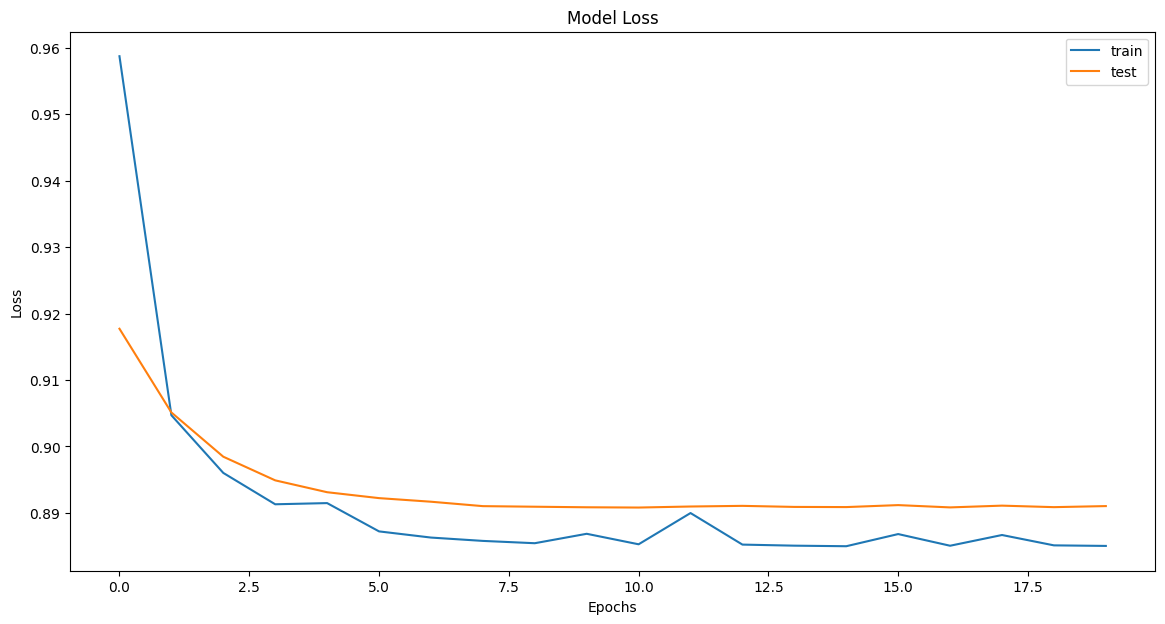

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 
Modal accuracy on test set: 45.01%


For threshold set to 0.40, correctness is: 45.01%
For threshold set to 0.45, correctness is: 45.01%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4505 - loss: 1.0114 - val_accuracy: 0.4501 - val_loss: 0.9492
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4605 - loss: 0.9491 - val_accuracy: 0.4501 - val_loss: 0.9253
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4642 - loss: 0.9156 - val_accuracy: 0.4501 - val_loss: 0.9110
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4737 - loss: 0.8994 - val_accuracy: 0.4501 - val_loss: 0.9028
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

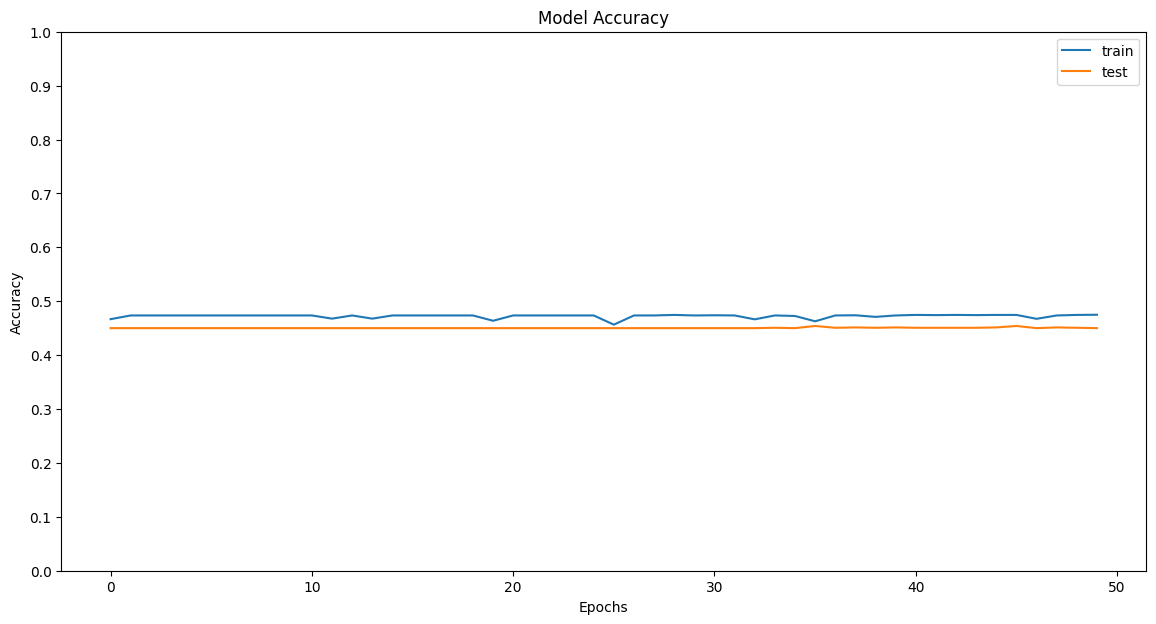

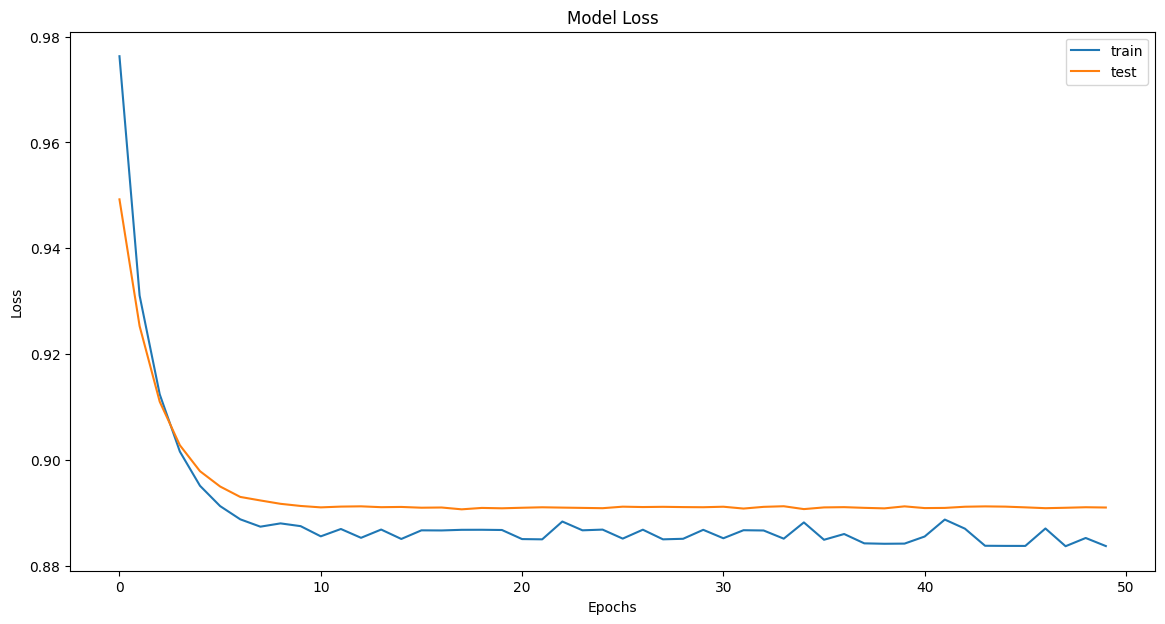

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 
Modal accuracy on test set: 45.01%


For threshold set to 0.40, correctness is: 45.01%
For threshold set to 0.45, correctness is: 45.01%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(40,)



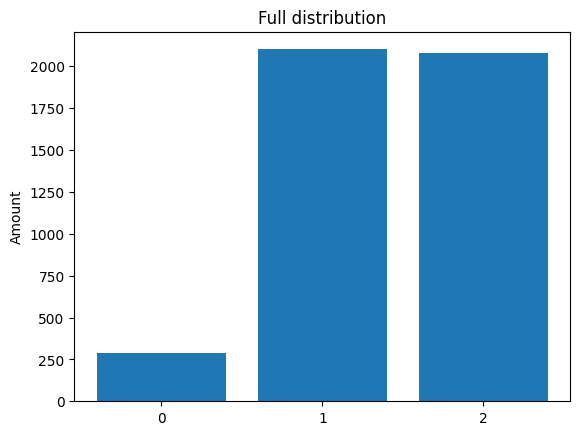

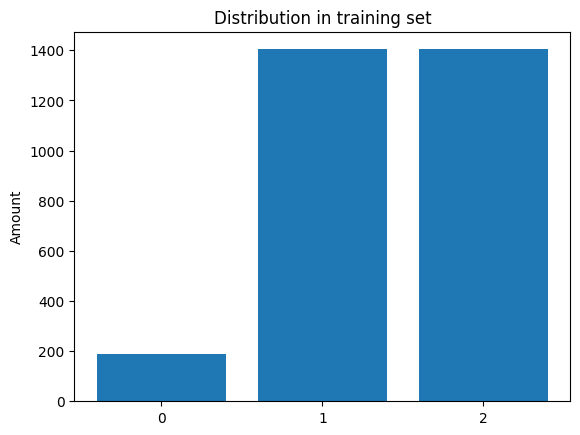

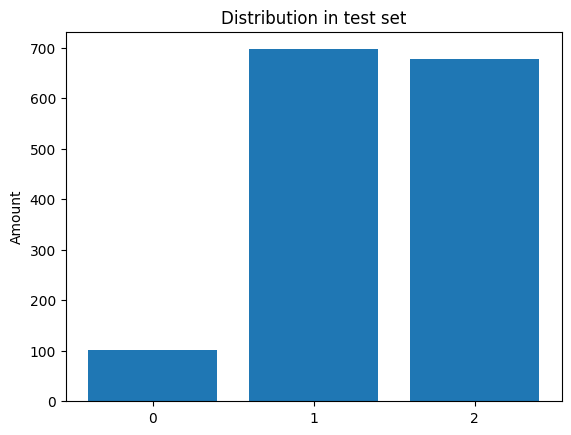

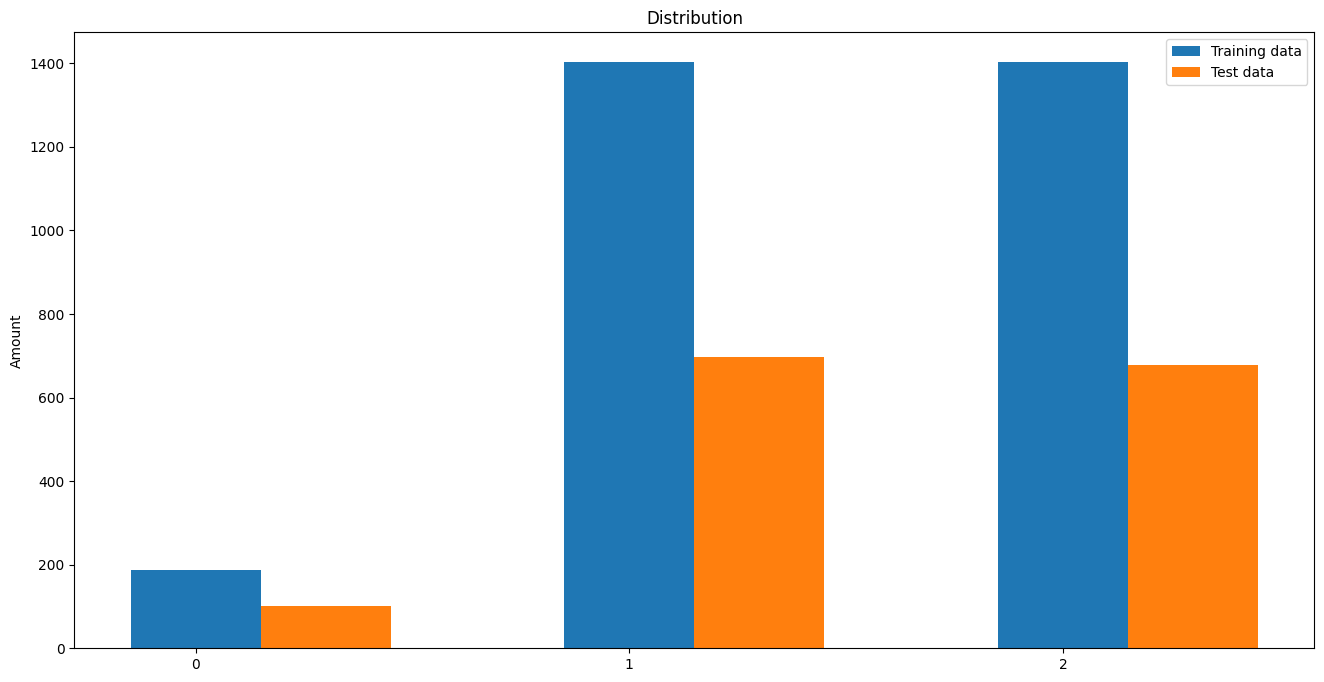


Example sequence from training set: [2 0 1 2 1 2 2 1 1 2 1 2 2 1 2 2 1 1 2 1 1 1 1 2 1 2 1 1 0 2 1 2 2 0 2 1 2
 2 2 1] and its label: 1

Example sequence from test set: [2 1 1 2 1 2 1 1 1 1 2 2 2 1 2 1 1 2 1 2 1 1 2 2 1 1 2 1 2 0 2 1 2 2 2 1 2
 2 2 1] and its label: 0


Gaussian Naive Bayes accuracy: 45.19%
Random forest classifier accuracy: 47.29%


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.3763 - loss: 1.0378 - val_accuracy: 0.4587 - val_loss: 0.9716
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4615 - loss: 0.9538 - val_accuracy: 0.4587 - val_loss: 0.9436
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4775 - loss: 0.9259 - val_accuracy: 0.4587 - val_loss: 0.9270
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4752 - loss: 0.9191 - val_accuracy: 0.4587 - val_loss: 0.9170
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4793 - loss: 0.9120 - val_accuracy: 0.4587 - val_loss: 0.9109
Epoch 6/10
94/9

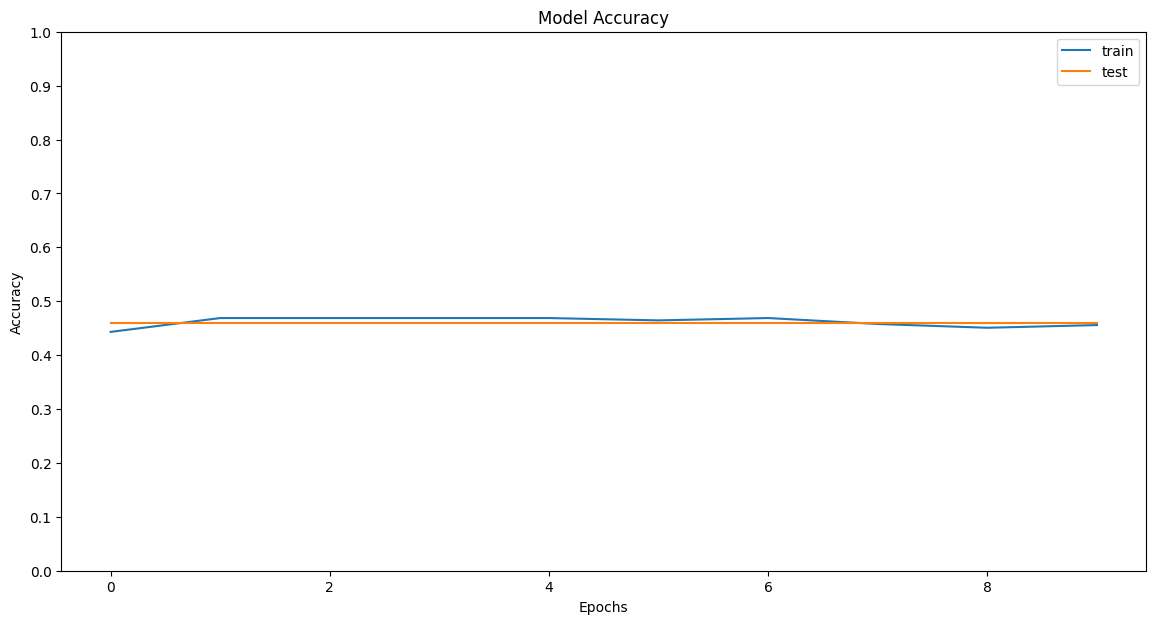

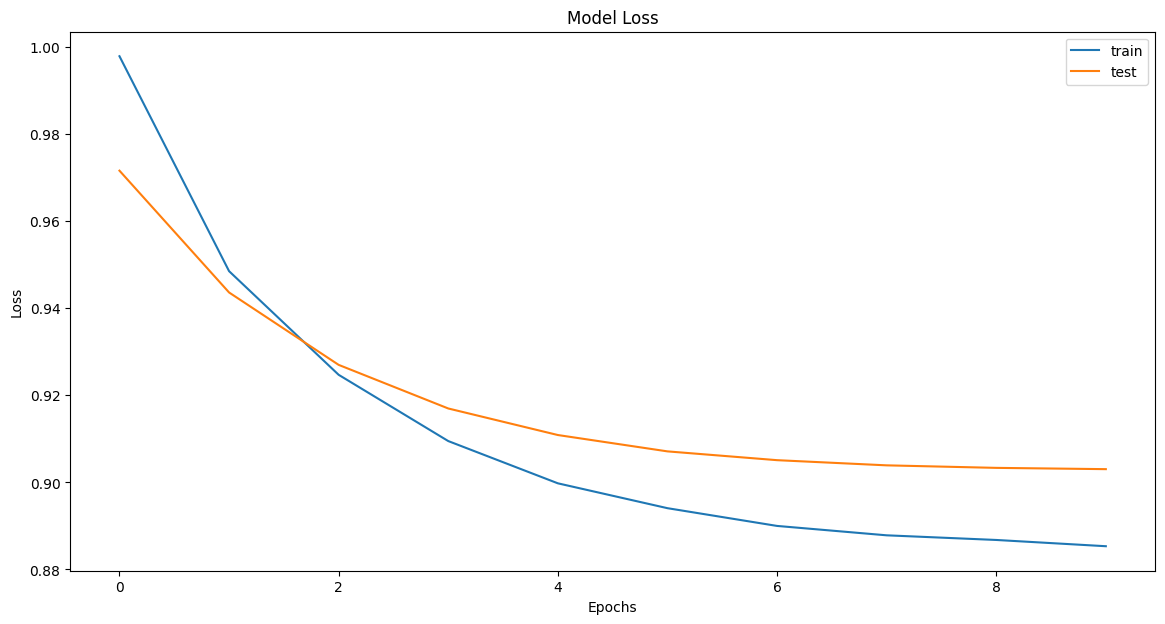

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 
Modal accuracy on test set: 45.87%


For threshold set to 0.40, correctness is: 45.87%
For threshold set to 0.45, correctness is: 45.87%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.3251 - loss: 1.0998 - val_accuracy: 0.4722 - val_loss: 0.9728
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4682 - loss: 0.9562 - val_accuracy: 0.4722 - val_loss: 0.9430
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4767 - loss: 0.9223 - val_accuracy: 0.4722 - val_loss: 0.9260
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4590 - loss: 0.9115 - val_accuracy: 0.4722 - val_loss: 0.9161
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

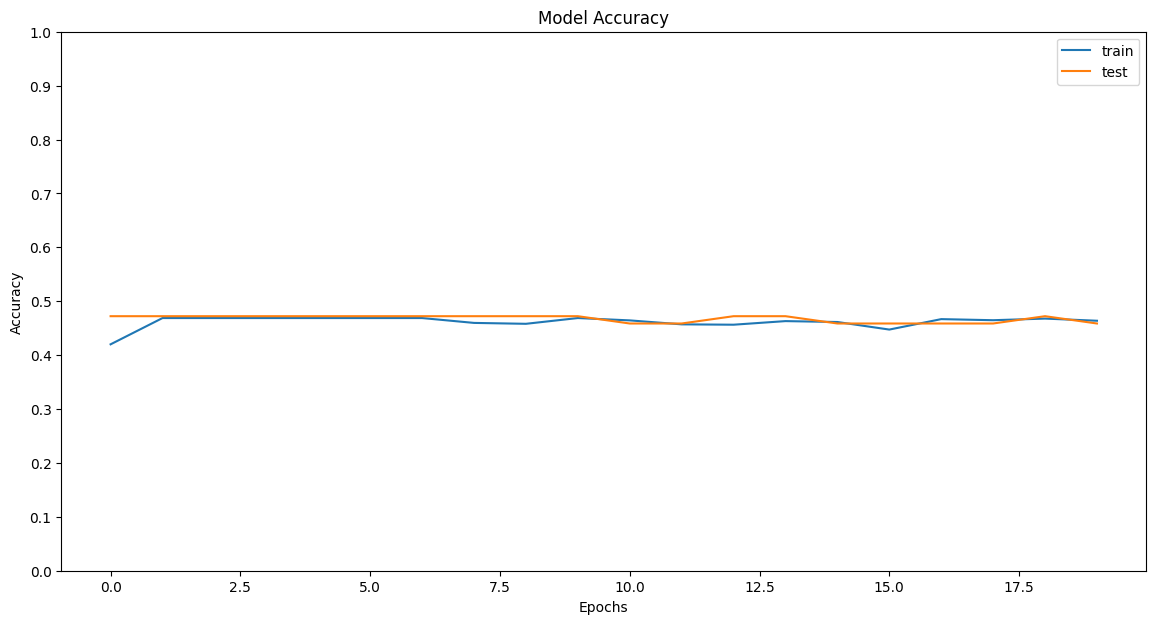

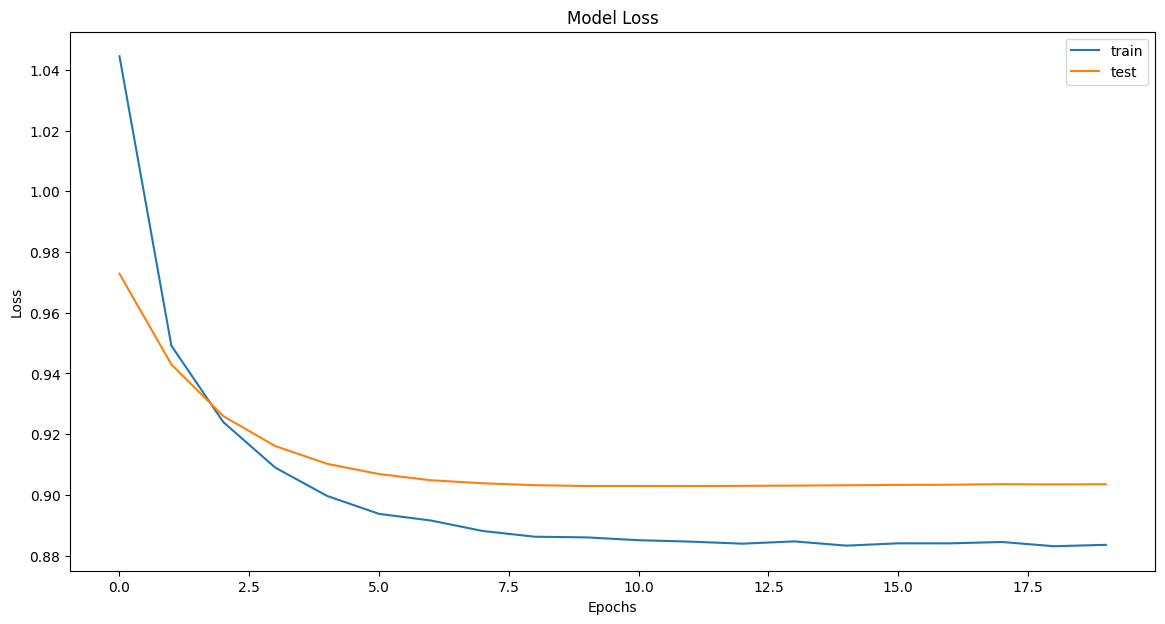

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
Modal accuracy on test set: 45.87%


For threshold set to 0.40, correctness is: 45.87%
For threshold set to 0.45, correctness is: 45.87%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4719 - loss: 0.9904 - val_accuracy: 0.4587 - val_loss: 0.9400
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4687 - loss: 0.9305 - val_accuracy: 0.4912 - val_loss: 0.9231
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4736 - loss: 0.9036 - val_accuracy: 0.4817 - val_loss: 0.9139
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4951 - loss: 0.8933 - val_accuracy: 0.4593 - val_loss: 0.9087
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

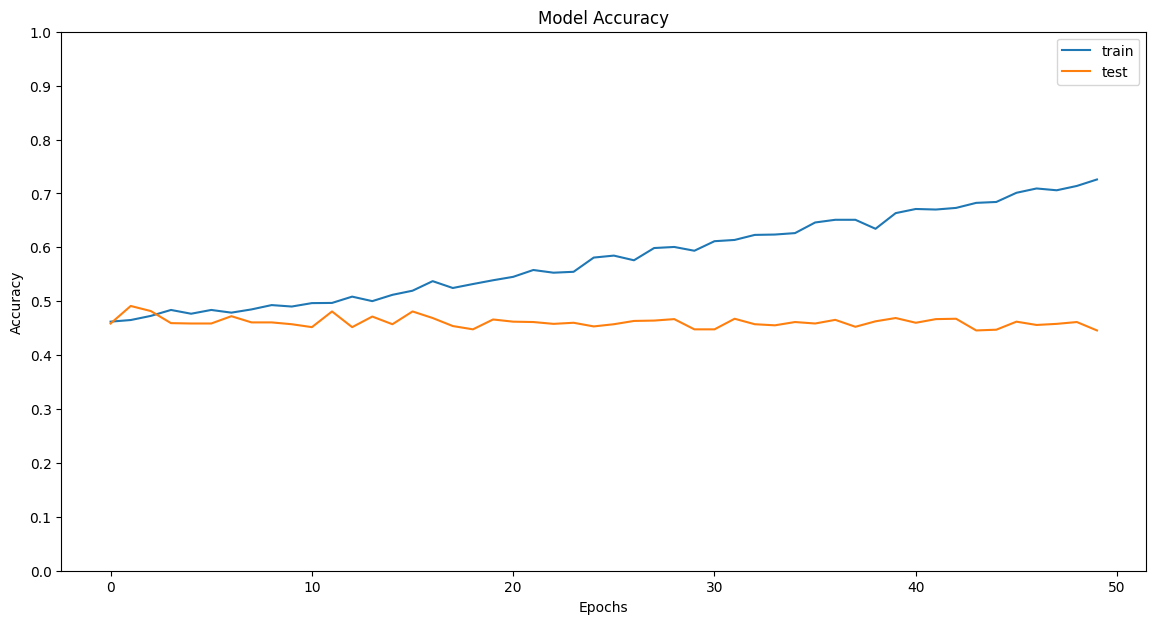

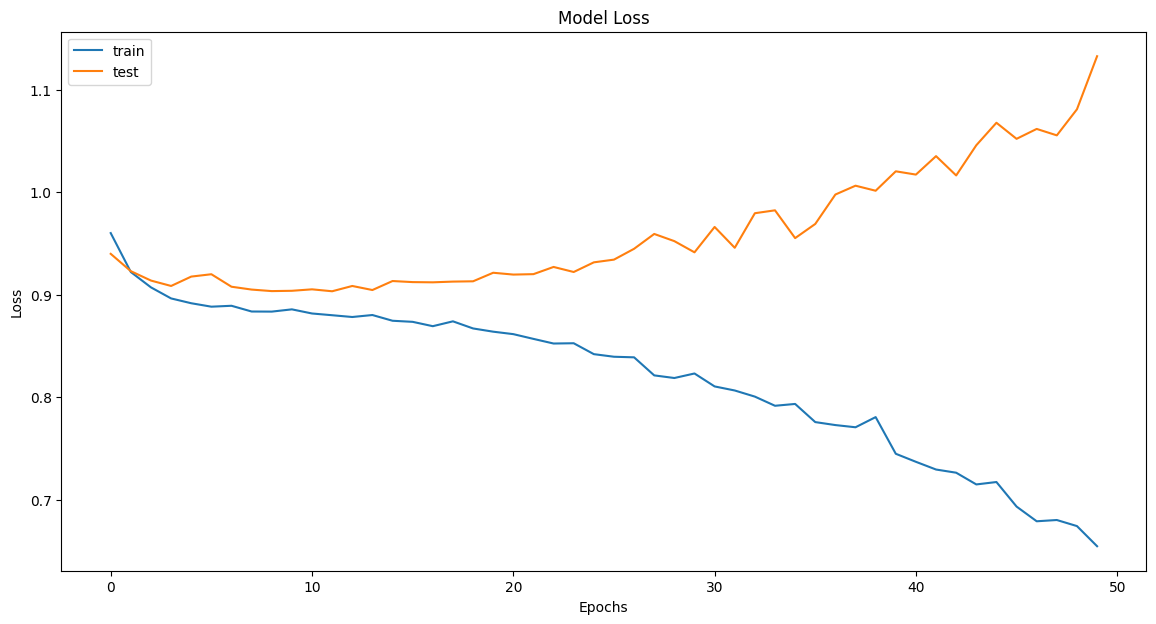

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
Modal accuracy on test set: 44.58%


For threshold set to 0.40, correctness is: 44.58%
For threshold set to 0.45, correctness is: 44.79%
For threshold set to 0.50, correctness is: 45.17%
For threshold set to 0.55, correctness is: 46.45%
For threshold set to 0.60, correctness is: 46.54%
For threshold set to 0.65, correctness is: 46.03%
For threshold set to 0.70, correctness is: 48.01%
For threshold set to 0.75, correctness is: 47.74%
For threshold set to 0.80, correctness is: 48.61%
For threshold set to 0.85, correctness is: 48.99%


Top 3 results:
Chunk size: 2, Epoch: 10, Accuracy: 46.00%
Chunk size: 2, Epoch: 20, Accuracy: 46.00%
Chunk size: 2, Epoch: 50, Accuracy: 46.00%

Data from file: csgofastcom.csv


Example sequence: ['black', 'black', 'red', 'red', 'red', 'black', 'red', 'black', 'black', 'green', 'black', 'black']

black: Counter({1: 416, 2: 181, 3: 79, 4: 39, 6: 12, 5: 10, 7: 3, 8: 2, 9: 2})
red: Counter({1: 407, 2: 178, 3: 78, 4: 42,

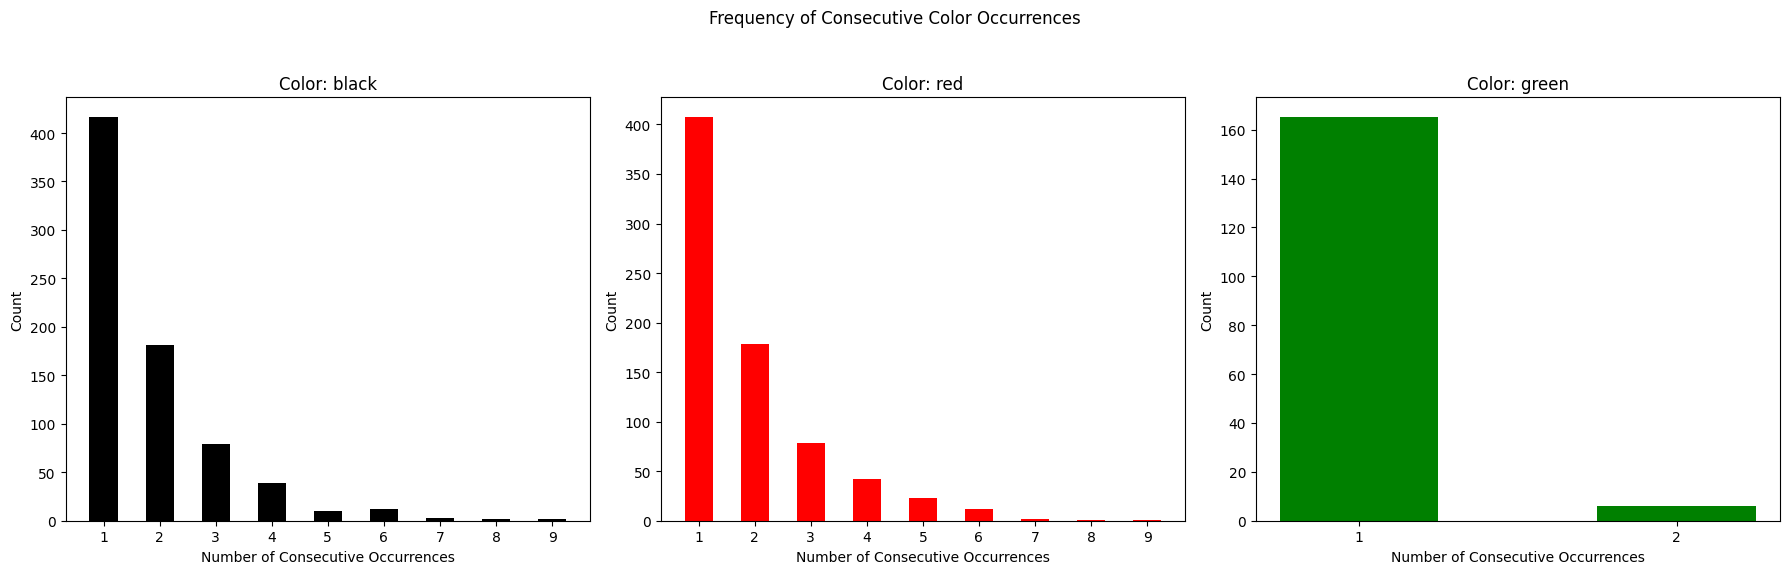

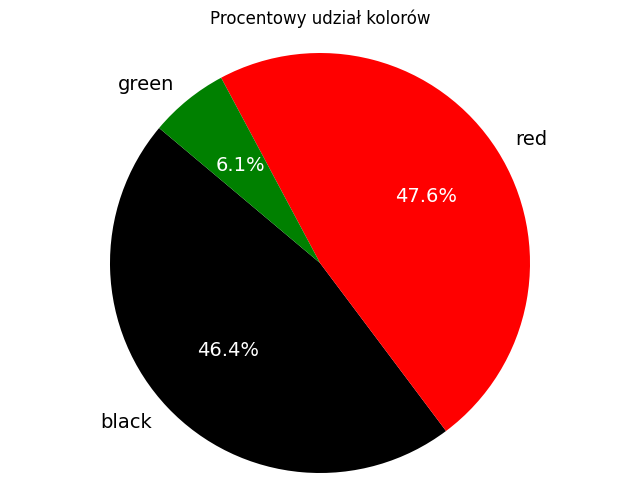


(2,)



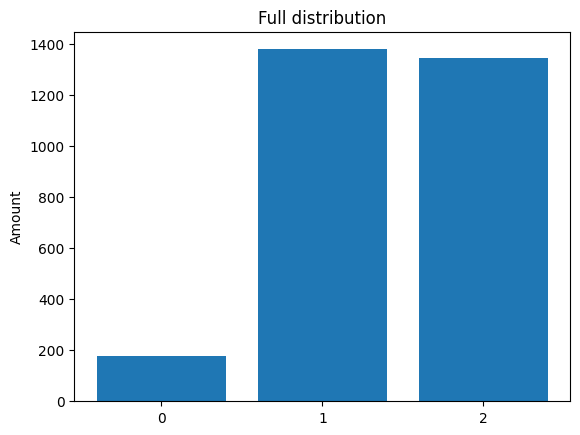

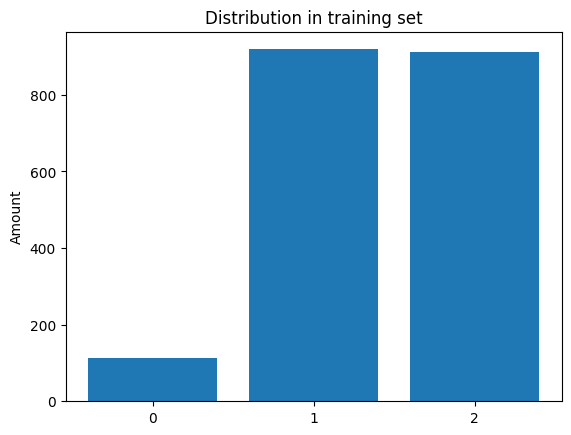

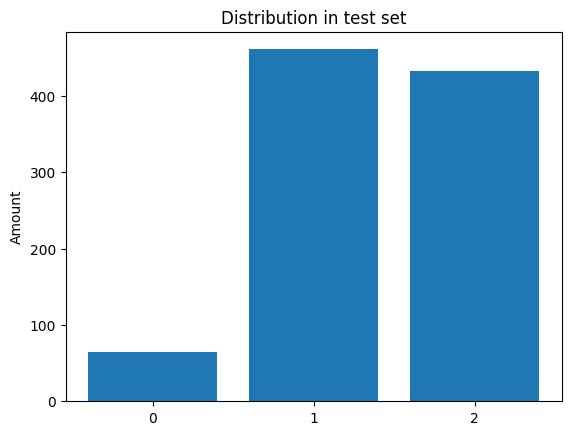

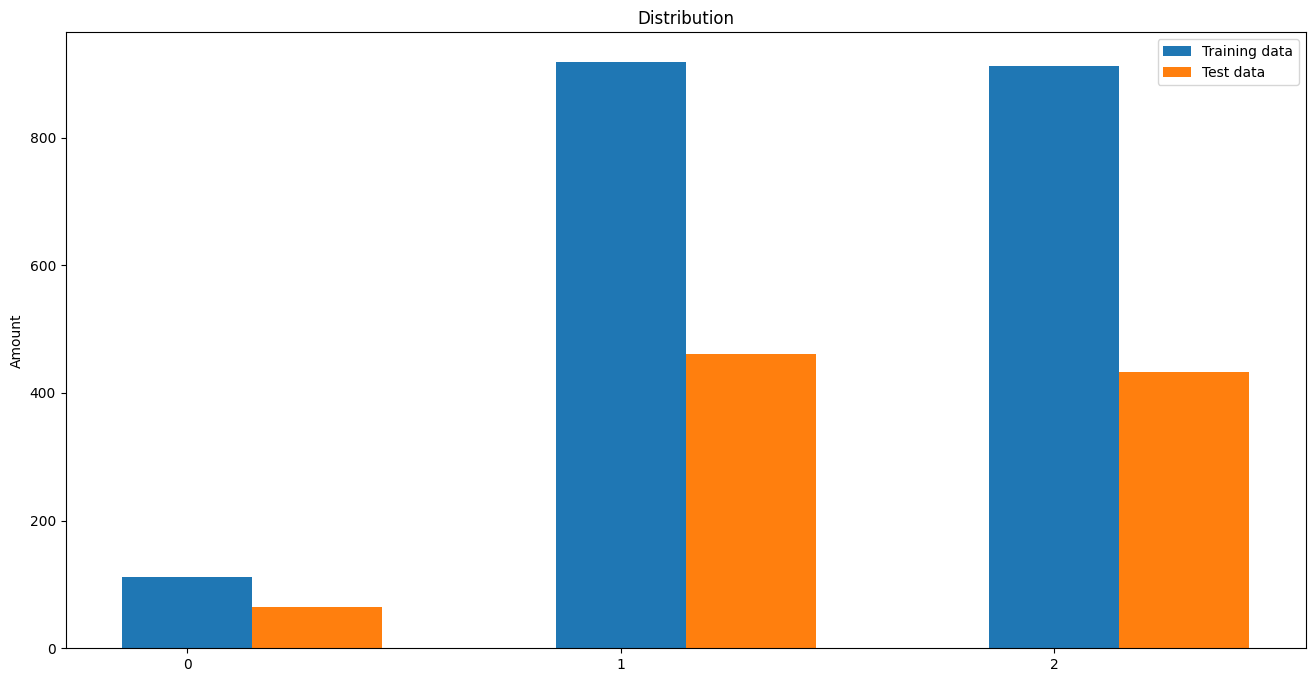


Example sequence from training set: [2 1] and its label: 1

Example sequence from test set: [1 1] and its label: 2


Gaussian Naive Bayes accuracy: 47.75%
Random forest classifier accuracy: 47.44%


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4641 - loss: 1.0180 - val_accuracy: 0.4786 - val_loss: 0.9438
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4910 - loss: 0.9297 - val_accuracy: 0.4514 - val_loss: 0.9329
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4915 - loss: 0.9136 - val_accuracy: 0.4493 - val_loss: 0.9158
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4768 - loss: 0.8919 - val_accuracy: 0.4838 - val_loss: 0.9092
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4745 - loss: 0.8935 - val_accuracy: 0.4786 - val_loss: 0.9026
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4745 - loss: 0.9024 - val_accuracy: 0.4786 - val_loss: 0.8995
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

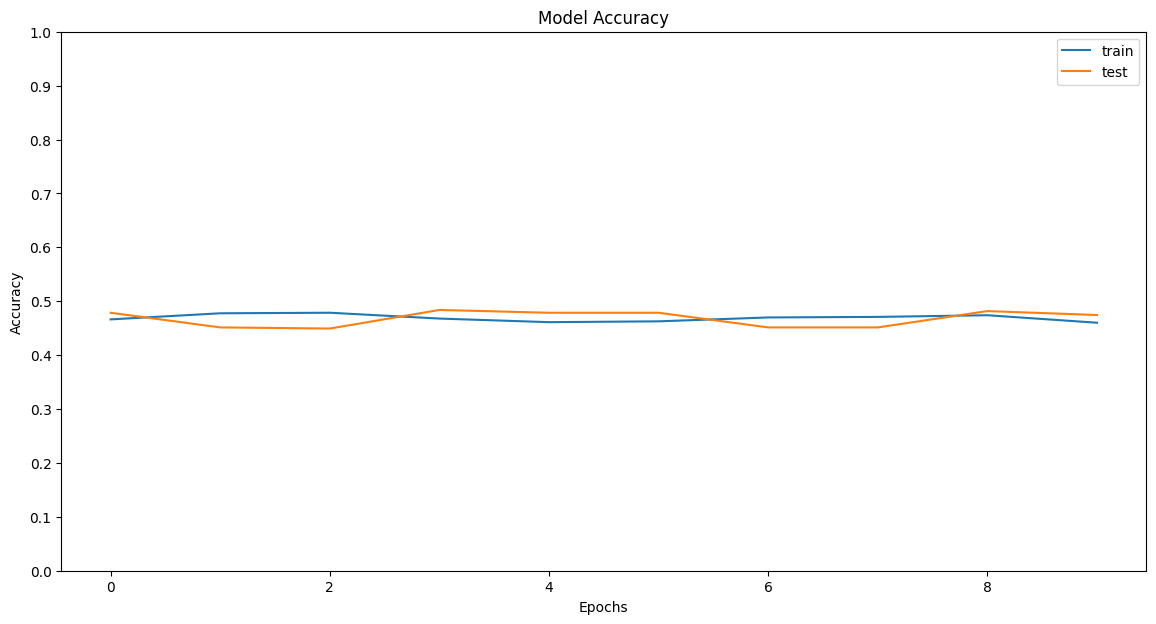

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Modal accuracy on test set: 47.44%


For threshold set to 0.40, correctness is: 47.44%
For threshold set to 0.45, correctness is: 47.44%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4851 - loss: 1.0581 - val_accuracy: 0.4514 - val_loss: 0.9268
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4667 - loss: 0.9091 - val_accuracy: 0.4514 - val_loss: 0.9154
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4560 - loss: 0.9015 - val_accuracy: 0.4838 - val_loss: 0.9077
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4776 - loss: 0.8801 - val_accuracy: 0.4514 - val_loss: 0.9026
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

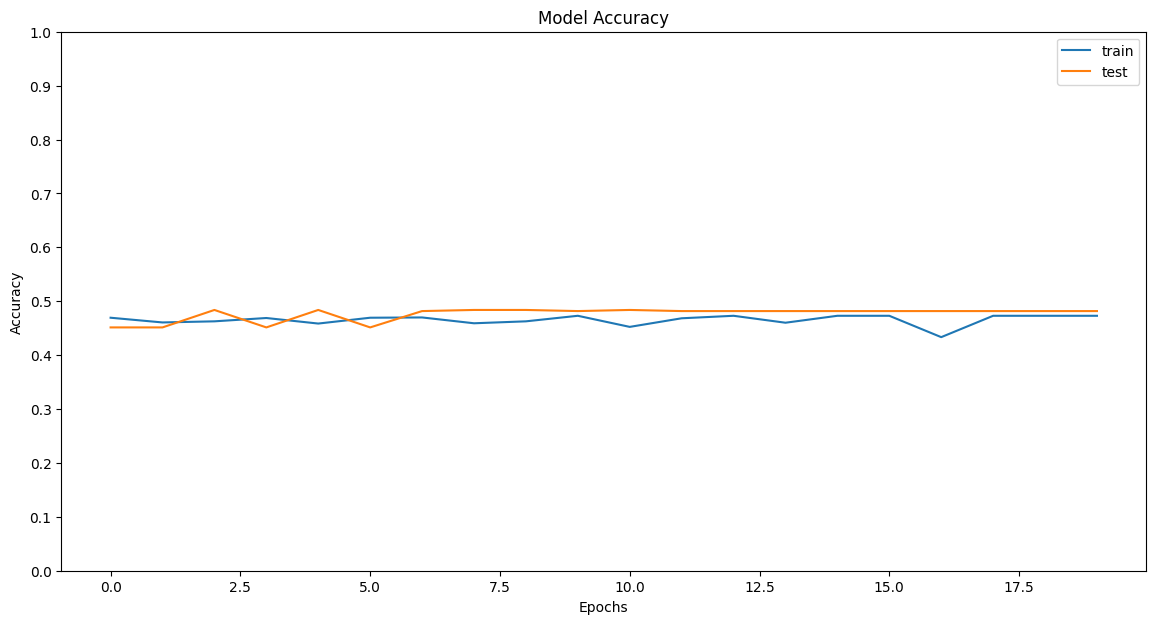

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 48.17%


For threshold set to 0.40, correctness is: 48.17%
For threshold set to 0.45, correctness is: 48.17%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4756 - loss: 1.0889 - val_accuracy: 0.4514 - val_loss: 1.0479
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4661 - loss: 1.0306 - val_accuracy: 0.4514 - val_loss: 0.9991
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4750 - loss: 0.9778 - val_accuracy: 0.4514 - val_loss: 0.9571
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4704 - loss: 0.9278 - val_accuracy: 0.4817 - val_loss: 0.8977
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

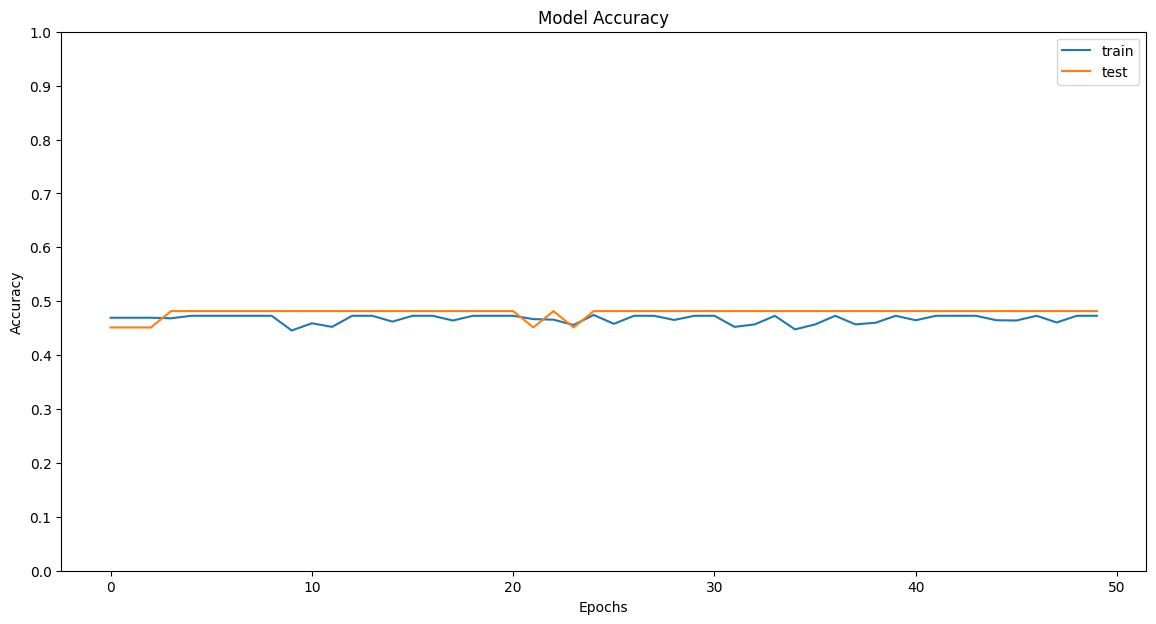

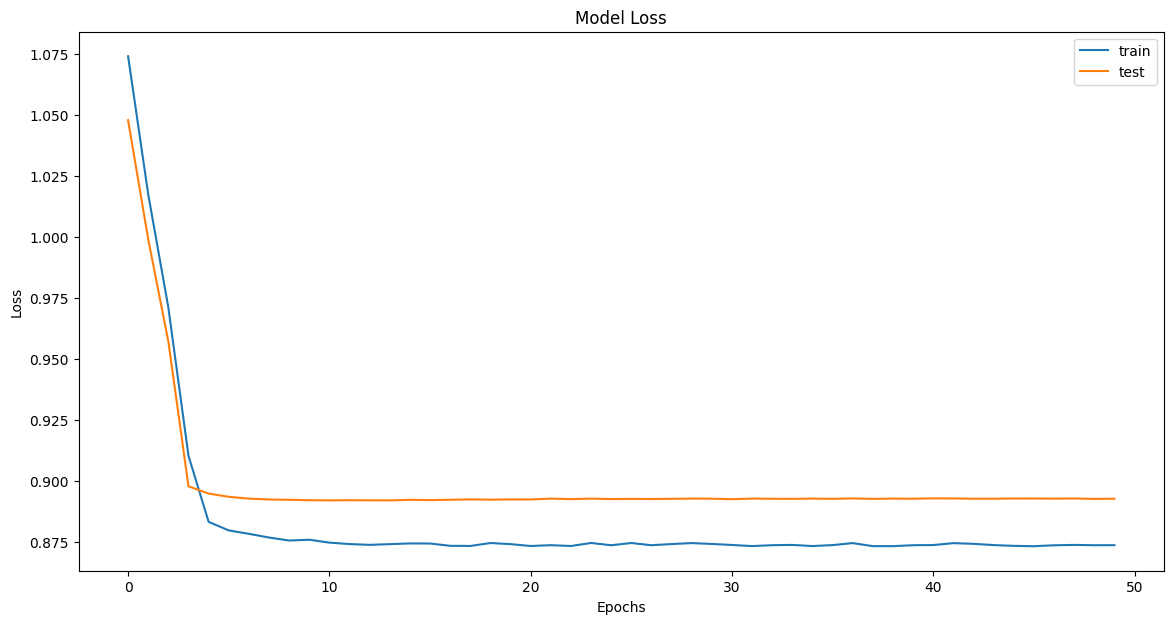

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Modal accuracy on test set: 48.17%


For threshold set to 0.40, correctness is: 48.17%
For threshold set to 0.45, correctness is: 48.17%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(5,)




Example sequence from training set: [1 2 2 1 2] and its label: 1

Example sequence from test set: [2 1 1 1 1] and its label: 2


Gaussian Naive Bayes accuracy: 47.17%
Random forest classifier accuracy: 47.48%


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.1240 - loss: 1.1493 - val_accuracy: 0.4497 - val_loss: 1.0302
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4927 - loss: 0.9847 - val_accuracy: 0.4497 - val_loss: 0.9795
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4709 - loss: 0.9605 - val_accuracy: 0.4497 - val_loss: 0.9501
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4740 - loss: 0.9353 - val_accuracy: 0.4497 - val_loss: 0.9306
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4523 - loss: 0.9339 - val_accuracy: 0.4497 - val_loss: 0.9166
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4817 - loss: 0.9050 - val_accuracy: 0.4497 - val_loss: 0.9072
Epoch 7/10
61/61 ━━━━━━━━━━━━━━

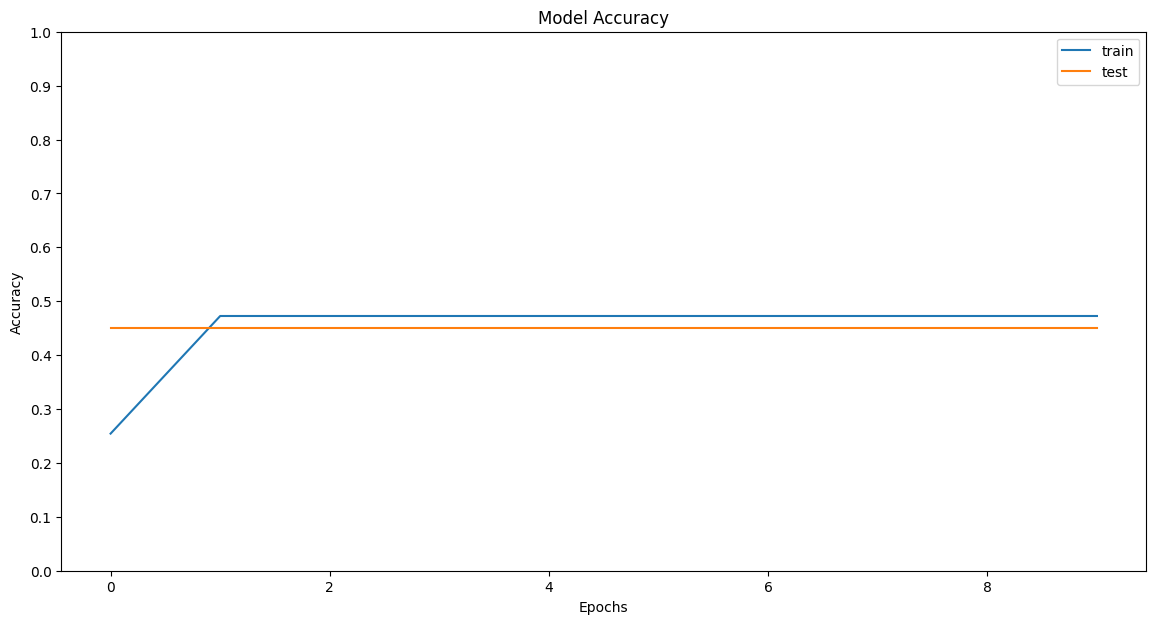

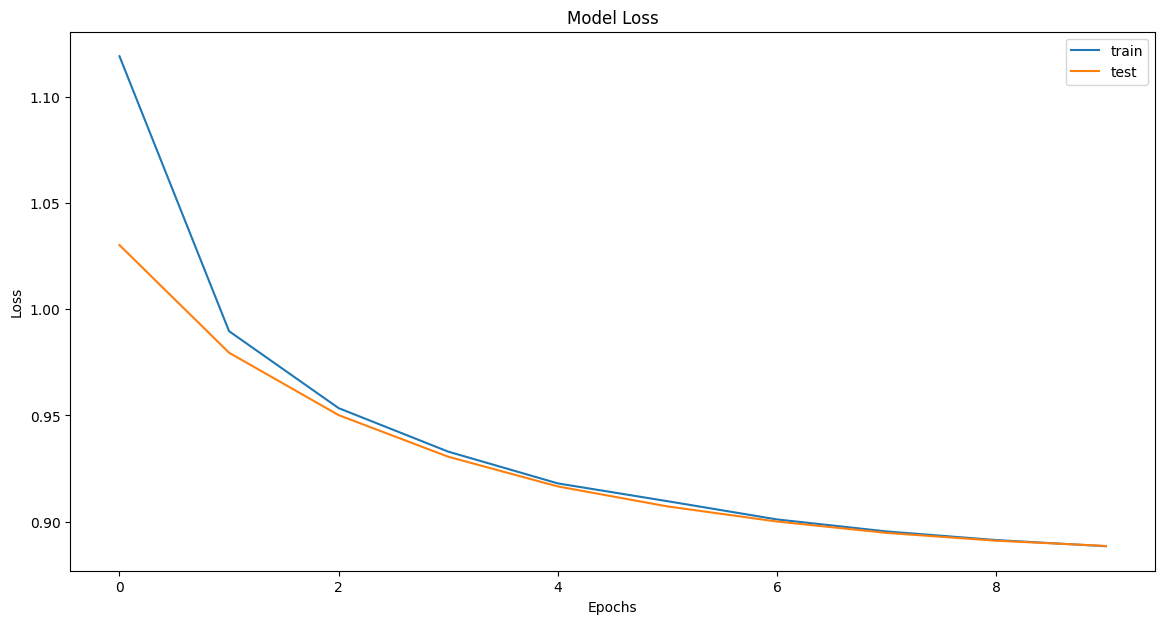

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 44.97%


For threshold set to 0.40, correctness is: 44.97%
For threshold set to 0.45, correctness is: 44.97%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.4626 - loss: 1.0049 - val_accuracy: 0.4497 - val_loss: 0.9238
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4608 - loss: 0.9180 - val_accuracy: 0.4497 - val_loss: 0.9116
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4627 - loss: 0.9083 - val_accuracy: 0.4497 - val_loss: 0.9002
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4623 - loss: 0.8902 - val_accuracy: 0.4497 - val_loss: 0.8933
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

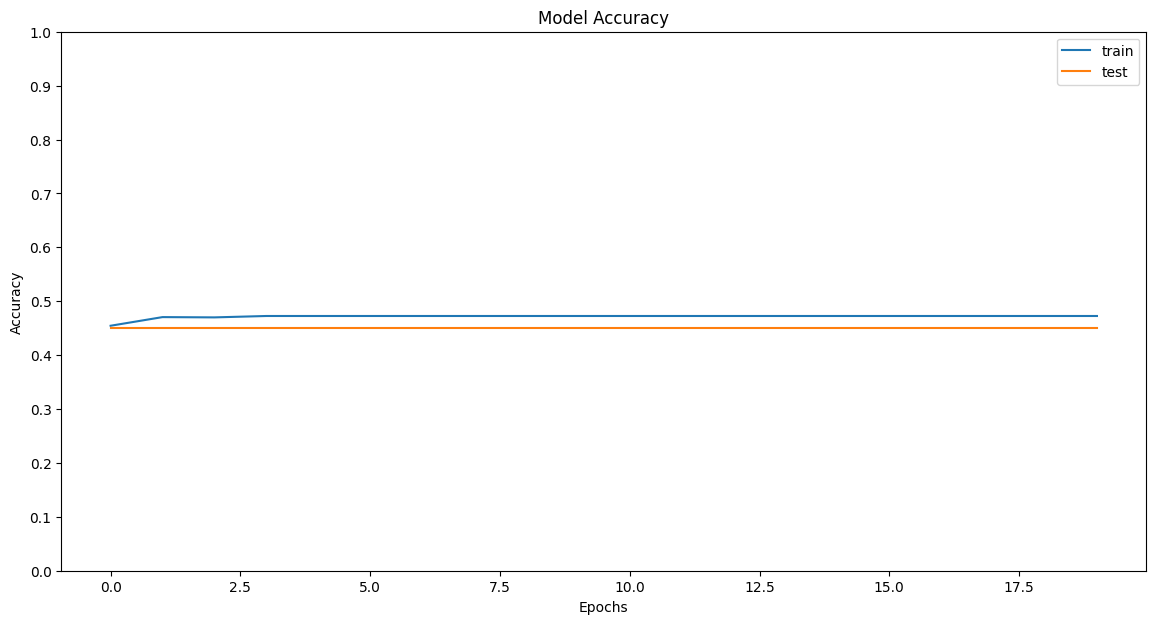

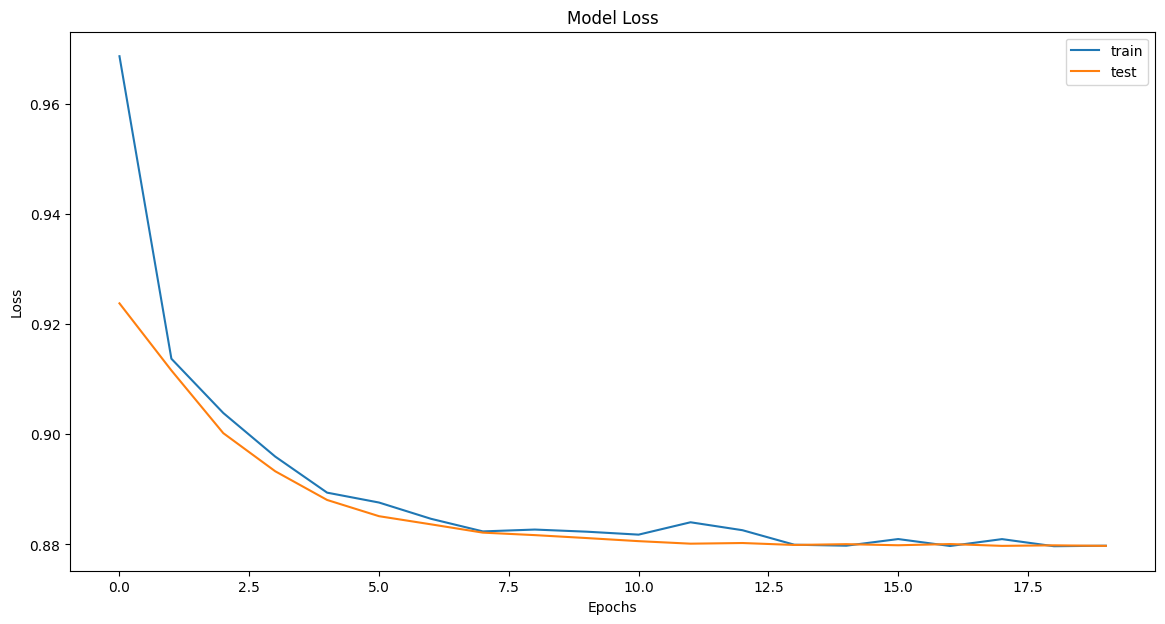

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 44.97%


For threshold set to 0.40, correctness is: 44.97%
For threshold set to 0.45, correctness is: 44.97%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.3207 - loss: 1.0580 - val_accuracy: 0.4717 - val_loss: 0.9577
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4621 - loss: 0.9597 - val_accuracy: 0.4916 - val_loss: 0.9290
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4489 - loss: 0.9283 - val_accuracy: 0.4895 - val_loss: 0.9085
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4711 - loss: 0.9063 - val_accuracy: 0.4497 - val_loss: 0.8990
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

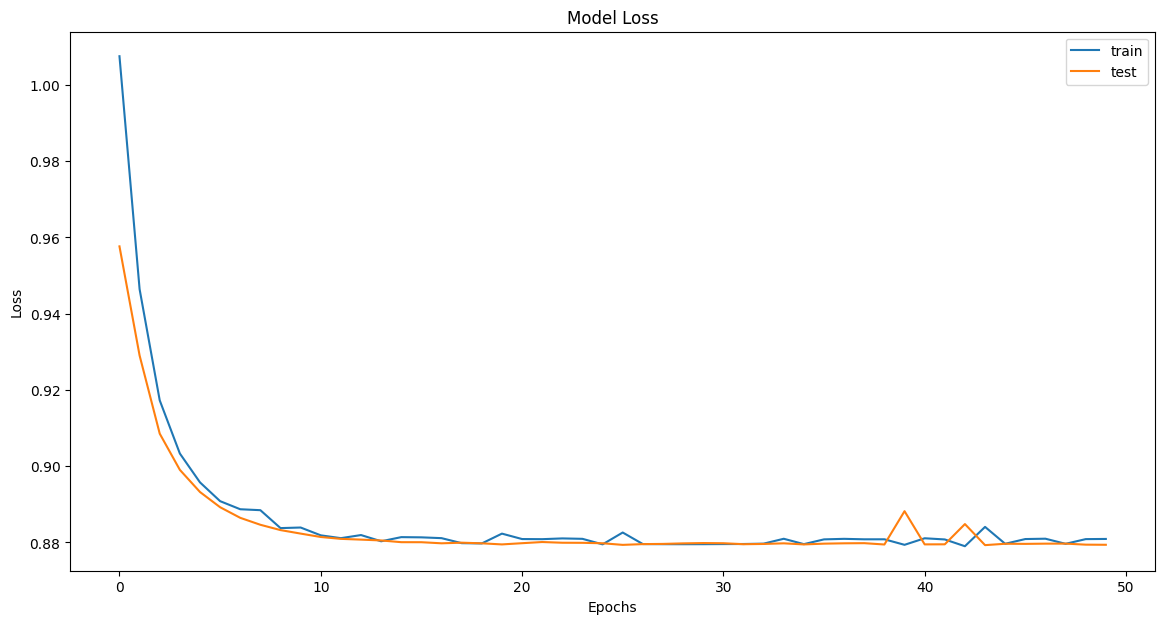

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 44.97%


For threshold set to 0.40, correctness is: 44.97%
For threshold set to 0.45, correctness is: 44.97%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(10,)



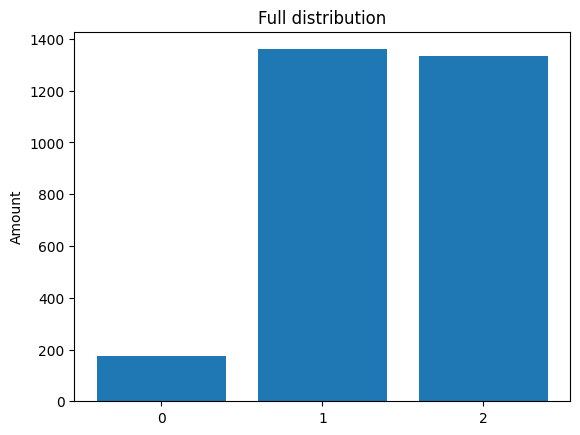

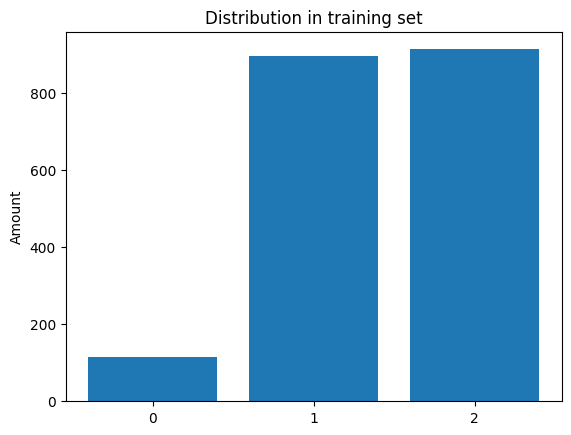

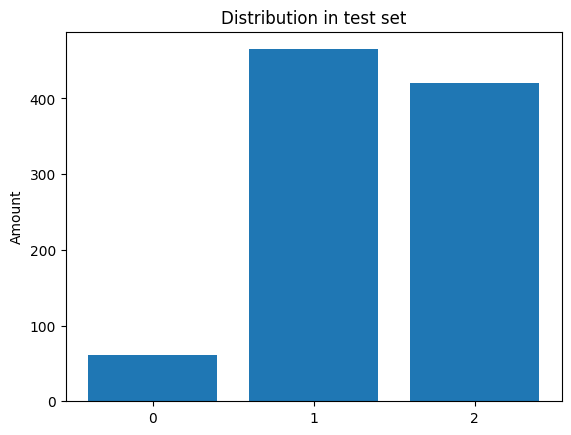

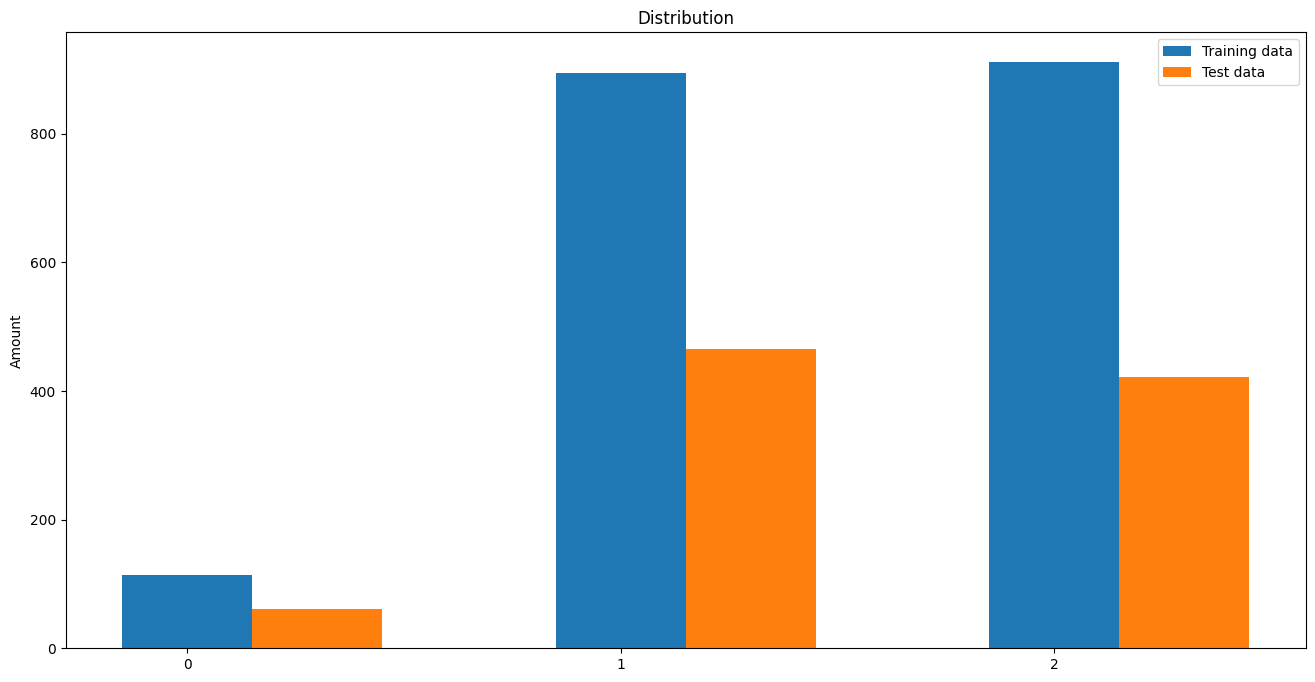


Example sequence from training set: [2 2 2 1 0 1 2 1 2 2] and its label: 1

Example sequence from test set: [2 2 1 1 1 1 2 1 2 1] and its label: 2


Gaussian Naive Bayes accuracy: 47.73%
Random forest classifier accuracy: 46.25%


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.4656 - loss: 1.0225 - val_accuracy: 0.4910 - val_loss: 0.9211
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4662 - loss: 0.9103 - val_accuracy: 0.4910 - val_loss: 0.9110
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4591 - loss: 0.9013 - val_accuracy: 0.4910 - val_loss: 0.9040
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4774 - loss: 0.9036 - val_accuracy: 0.4910 - val_loss: 0.8992
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4679 - loss: 0.8821 - val_accuracy: 0.4446 - val_loss: 0.8961
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4692 - loss: 0.8959 - val_accuracy: 0.4446 - val_loss: 0.8944
Epoch 7/10


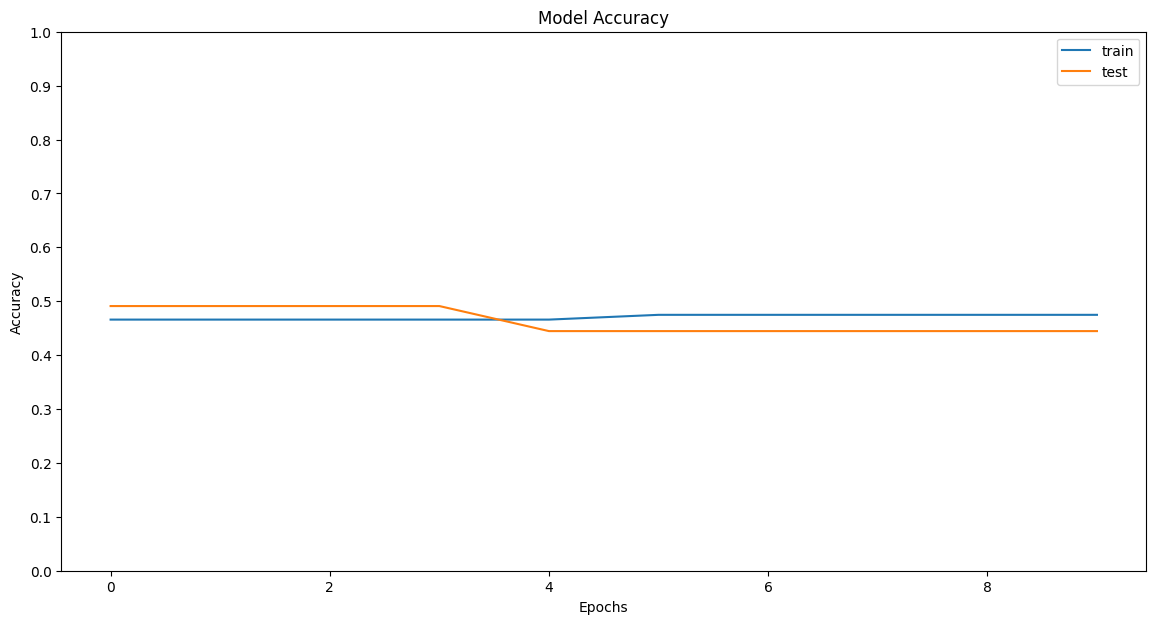

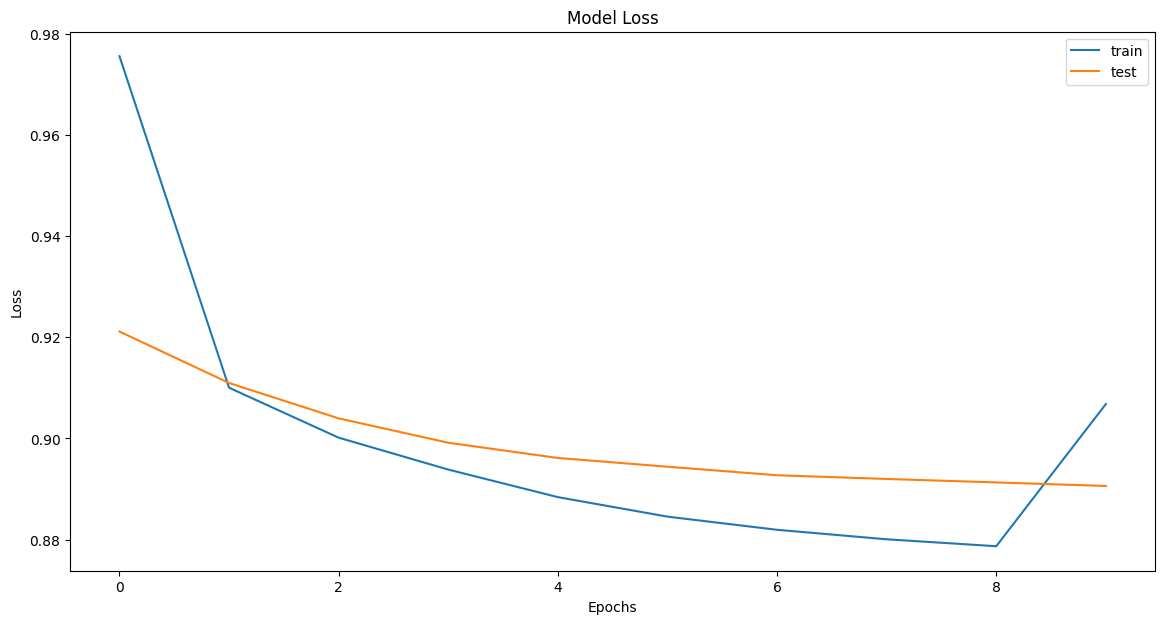

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Modal accuracy on test set: 44.46%


For threshold set to 0.40, correctness is: 44.46%
For threshold set to 0.45, correctness is: 44.46%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4804 - loss: 0.9914 - val_accuracy: 0.4446 - val_loss: 0.9256
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4633 - loss: 0.9221 - val_accuracy: 0.4446 - val_loss: 0.9169
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4956 - loss: 0.9103 - val_accuracy: 0.4446 - val_loss: 0.9096
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4780 - loss: 0.9018 - val_accuracy: 0.4446 - val_loss: 0.9039
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

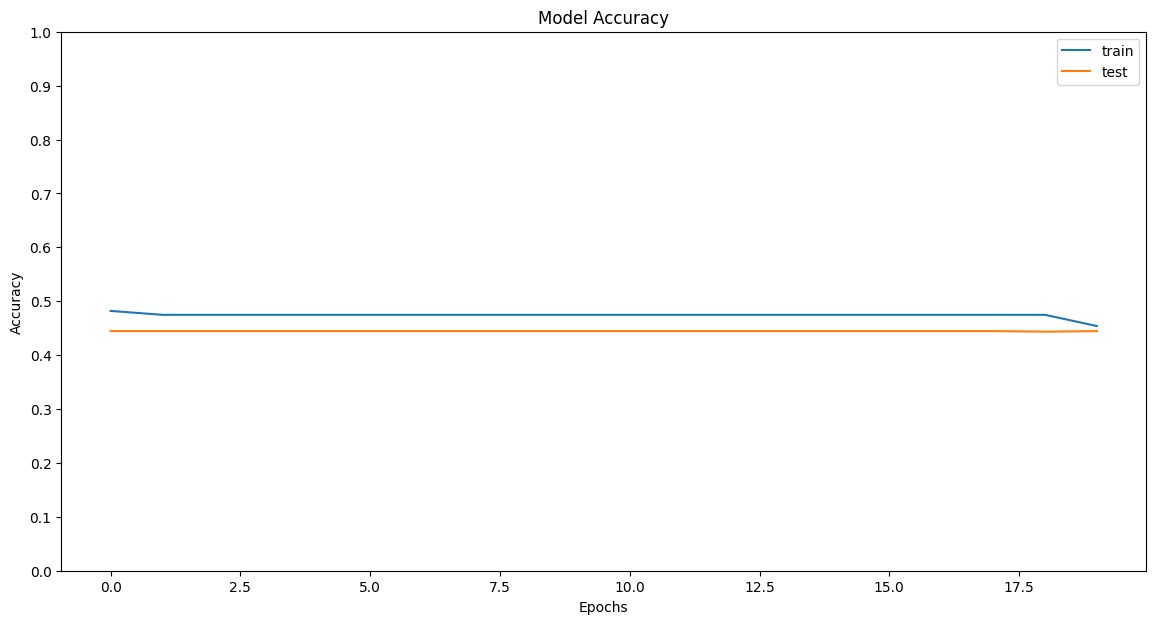

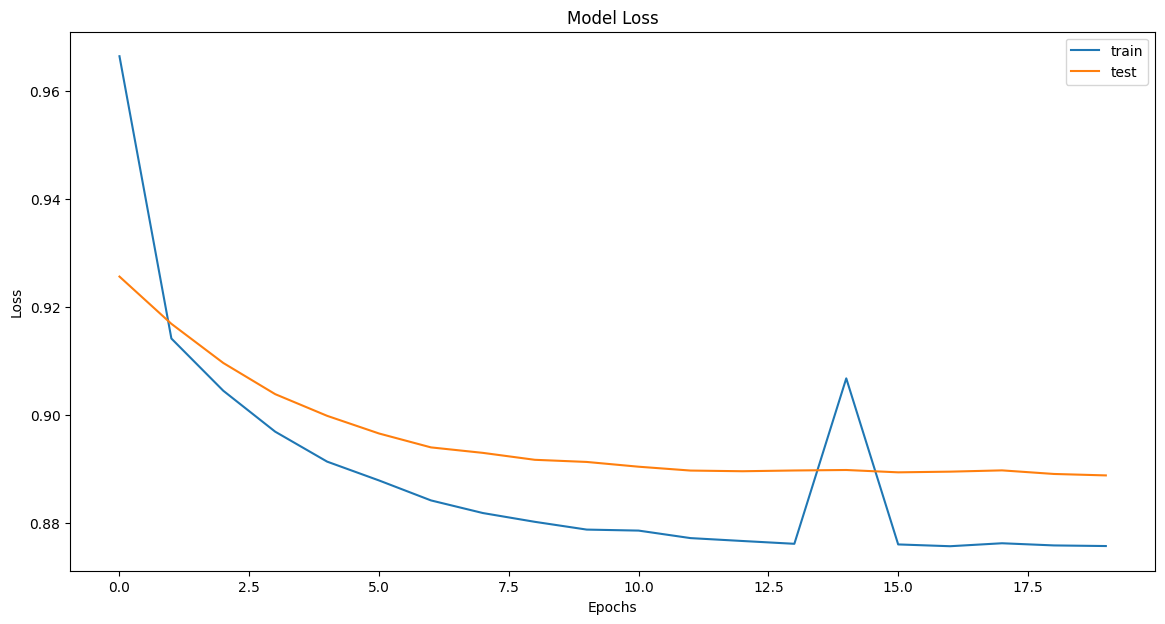

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Modal accuracy on test set: 44.46%


For threshold set to 0.40, correctness is: 44.46%
For threshold set to 0.45, correctness is: 44.46%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4488 - loss: 1.0031 - val_accuracy: 0.4910 - val_loss: 0.9185
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4758 - loss: 0.9121 - val_accuracy: 0.4910 - val_loss: 0.9087
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4633 - loss: 0.8918 - val_accuracy: 0.4910 - val_loss: 0.9025
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4637 - loss: 0.8960 - val_accuracy: 0.4910 - val_loss: 0.8981
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

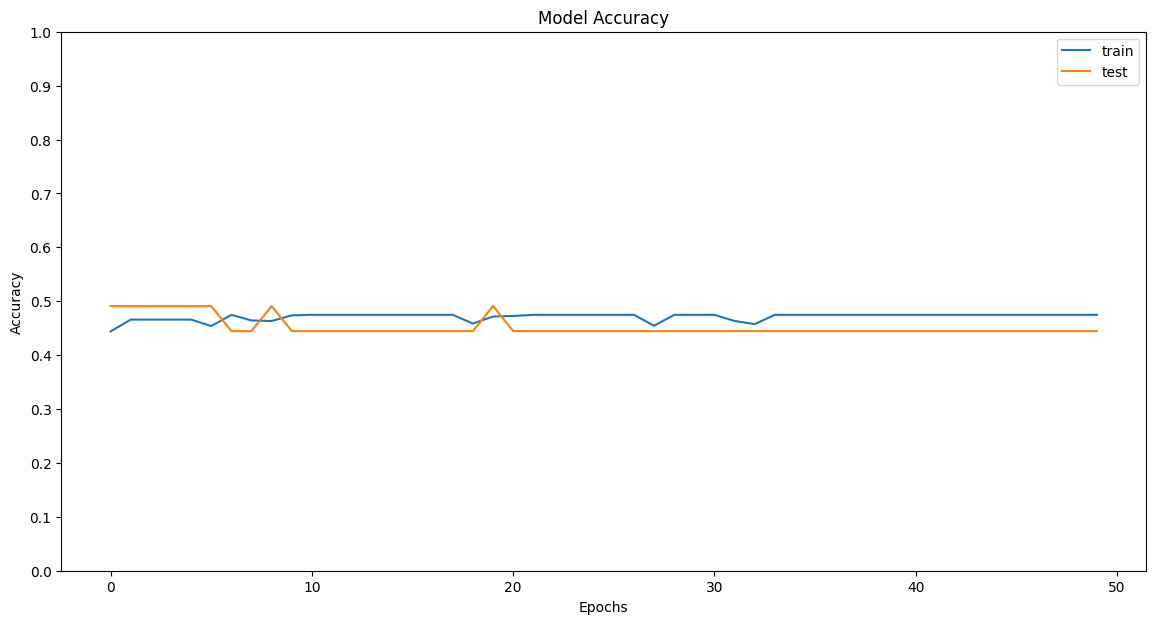

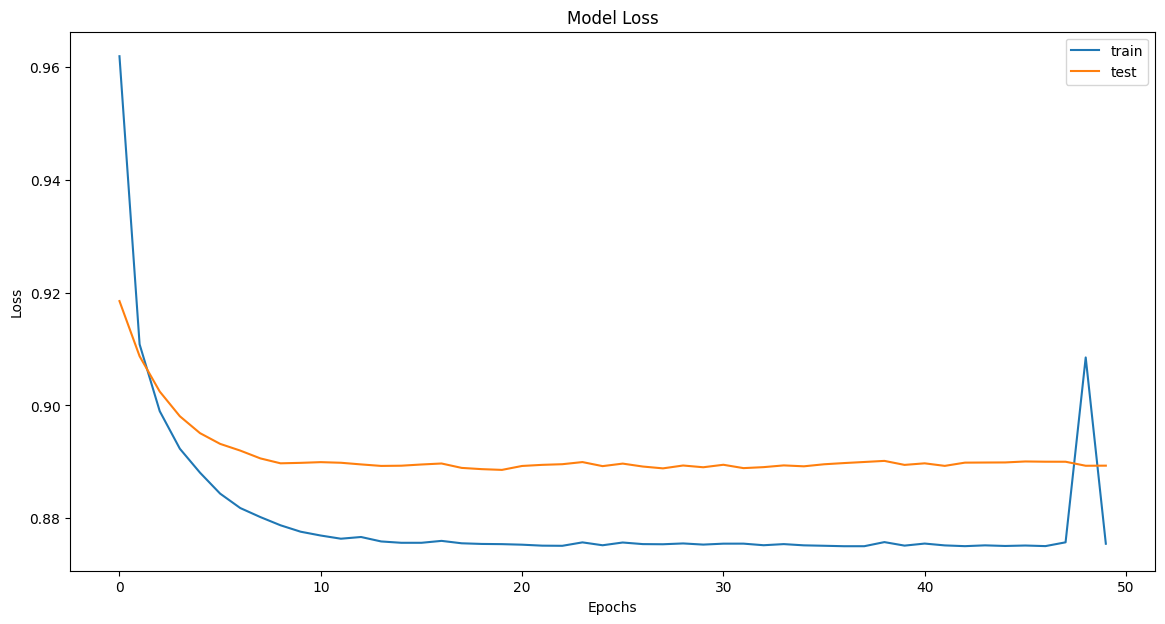

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Modal accuracy on test set: 44.46%


For threshold set to 0.40, correctness is: 44.46%
For threshold set to 0.45, correctness is: 44.46%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(15,)



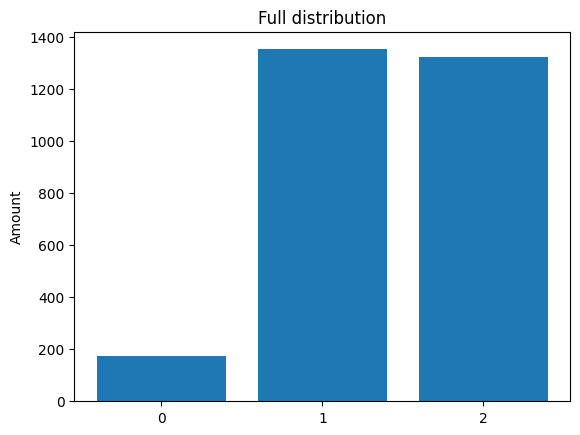

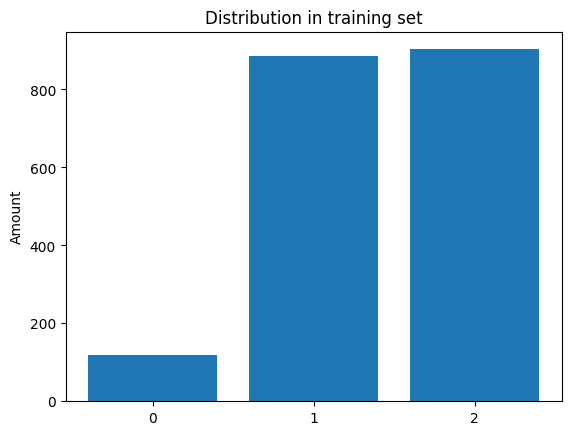

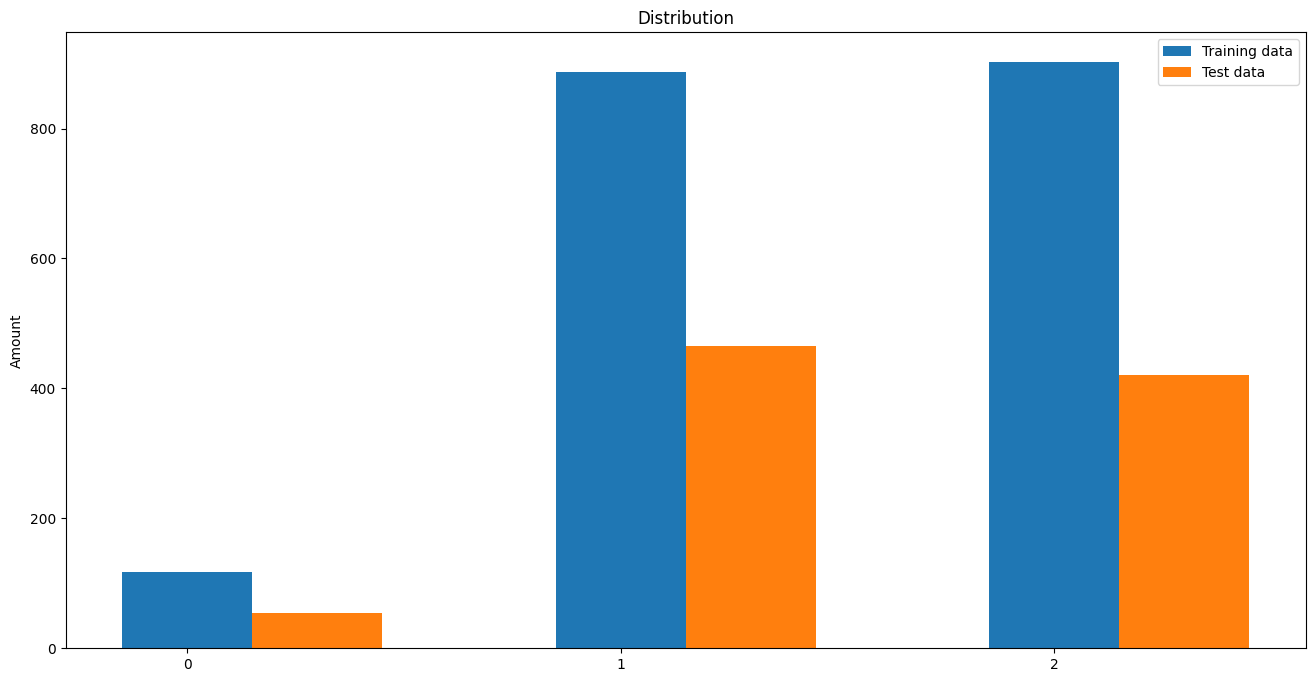


Example sequence from training set: [0 2 2 2 0 1 2 1 1 2 0 2 2 2 1] and its label: 1

Example sequence from test set: [1 2 2 2 2 1 1 1 2 0 1 0 2 2 1] and its label: 2


Gaussian Naive Bayes accuracy: 46.38%
Random forest classifier accuracy: 45.64%


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.4926 - loss: 1.0291 - val_accuracy: 0.4479 - val_loss: 0.9485
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4673 - loss: 0.9405 - val_accuracy: 0.4479 - val_loss: 0.9282
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4660 - loss: 0.9341 - val_accuracy: 0.4479 - val_loss: 0.9145
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4775 - loss: 0.9139 - val_accuracy: 0.4479 - val_loss: 0.9039
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4703 - loss: 0.9067 - val_accuracy: 0.4479 - val_loss: 0.8968
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4901 - loss: 0.9015 - val_accuracy: 0.4479 - val_loss

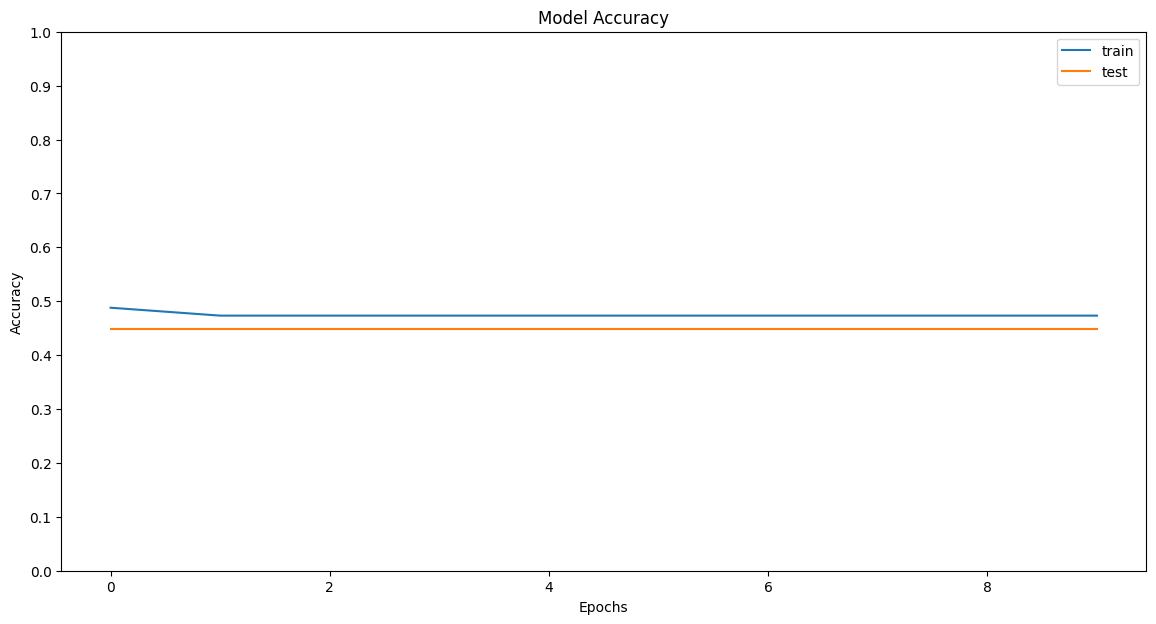

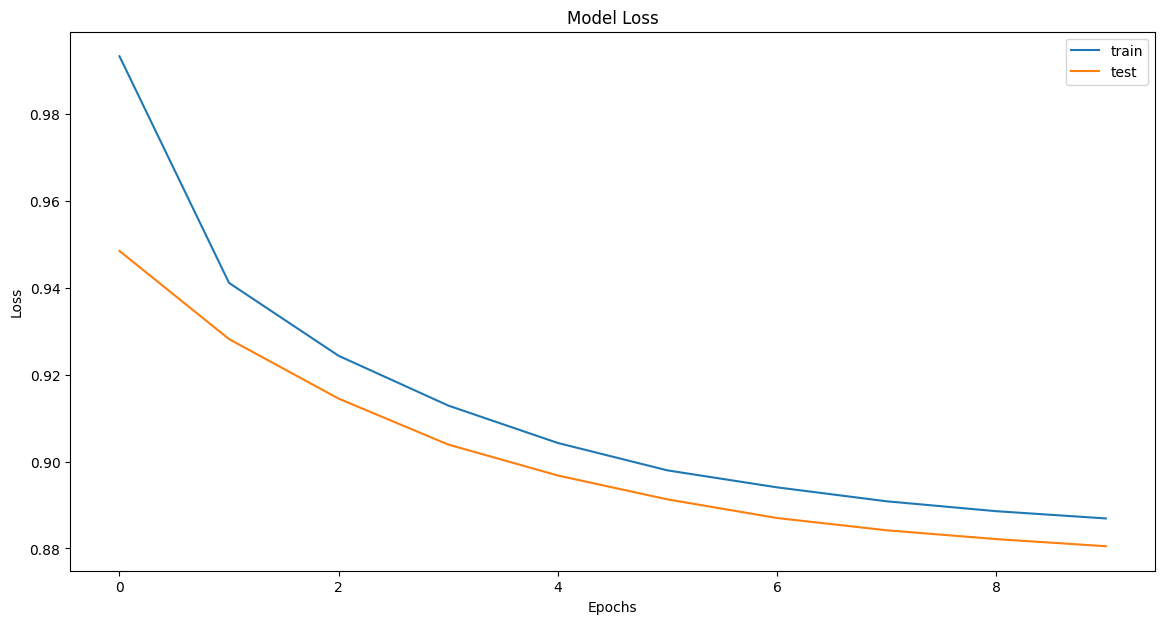

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Modal accuracy on test set: 44.79%


For threshold set to 0.40, correctness is: 44.79%
For threshold set to 0.45, correctness is: 44.79%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.4531 - loss: 1.0440 - val_accuracy: 0.4947 - val_loss: 0.9476
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4549 - loss: 0.9596 - val_accuracy: 0.4947 - val_loss: 0.9279
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4722 - loss: 0.9310 - val_accuracy: 0.4947 - val_loss: 0.9135
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4602 - loss: 0.9191 - val_accuracy: 0.4947 - val_loss: 0.9036
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

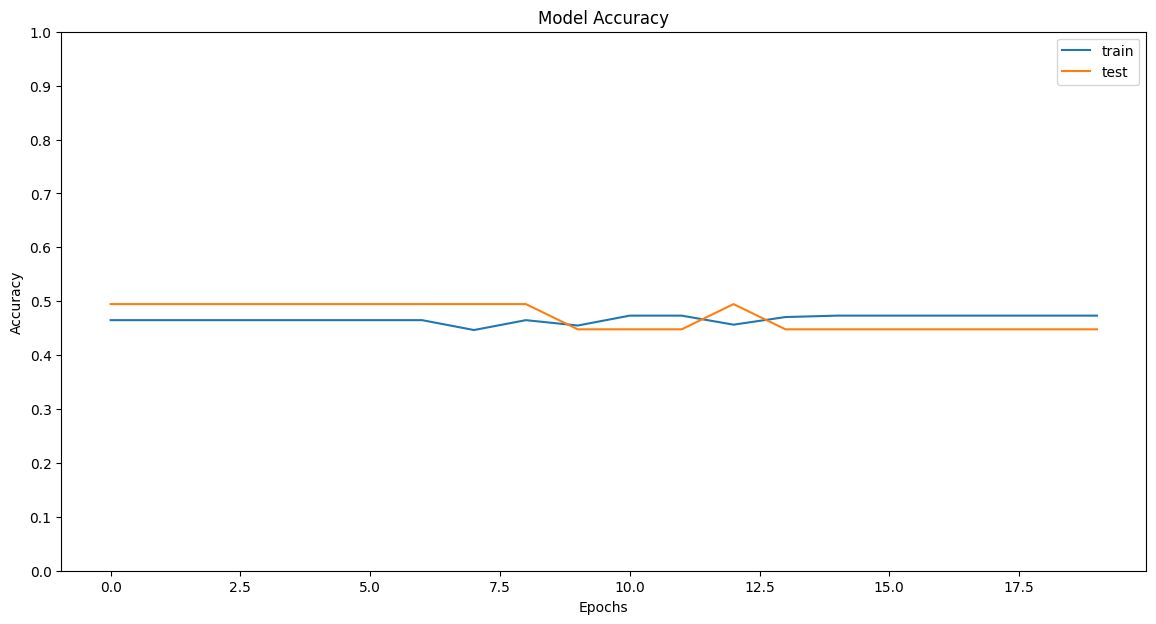

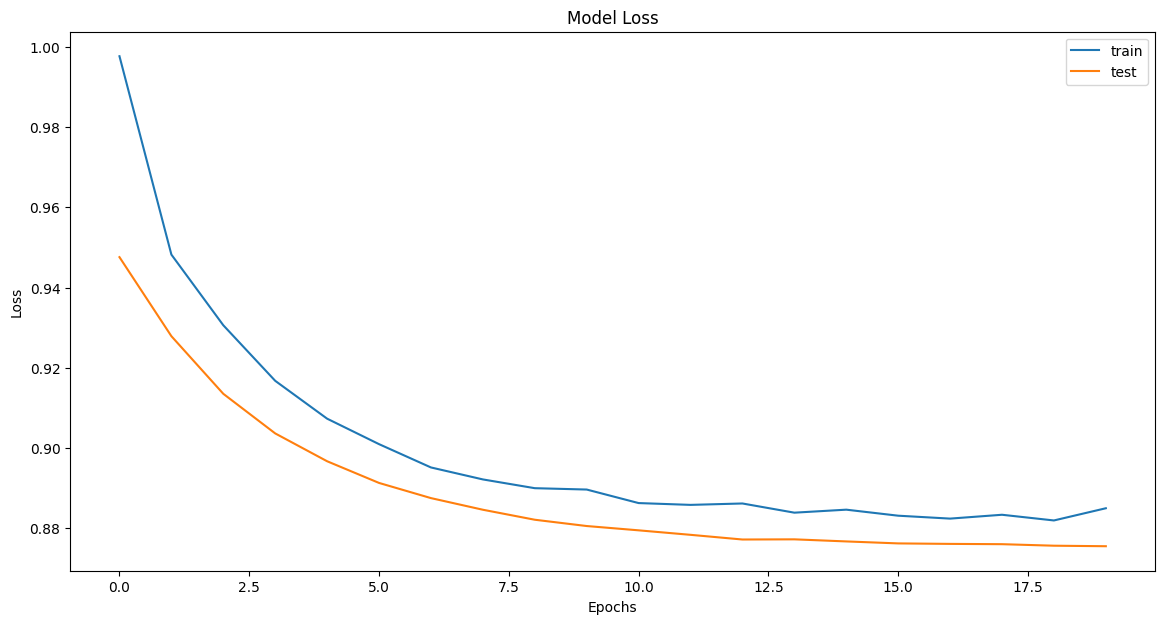

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Modal accuracy on test set: 44.79%


For threshold set to 0.40, correctness is: 44.79%
For threshold set to 0.45, correctness is: 44.79%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.3681 - loss: 1.0640 - val_accuracy: 0.4947 - val_loss: 0.9622
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4711 - loss: 0.9639 - val_accuracy: 0.4947 - val_loss: 0.9387
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4413 - loss: 0.9470 - val_accuracy: 0.4947 - val_loss: 0.9221
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4686 - loss: 0.9337 - val_accuracy: 0.4947 - val_loss: 0.9103
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

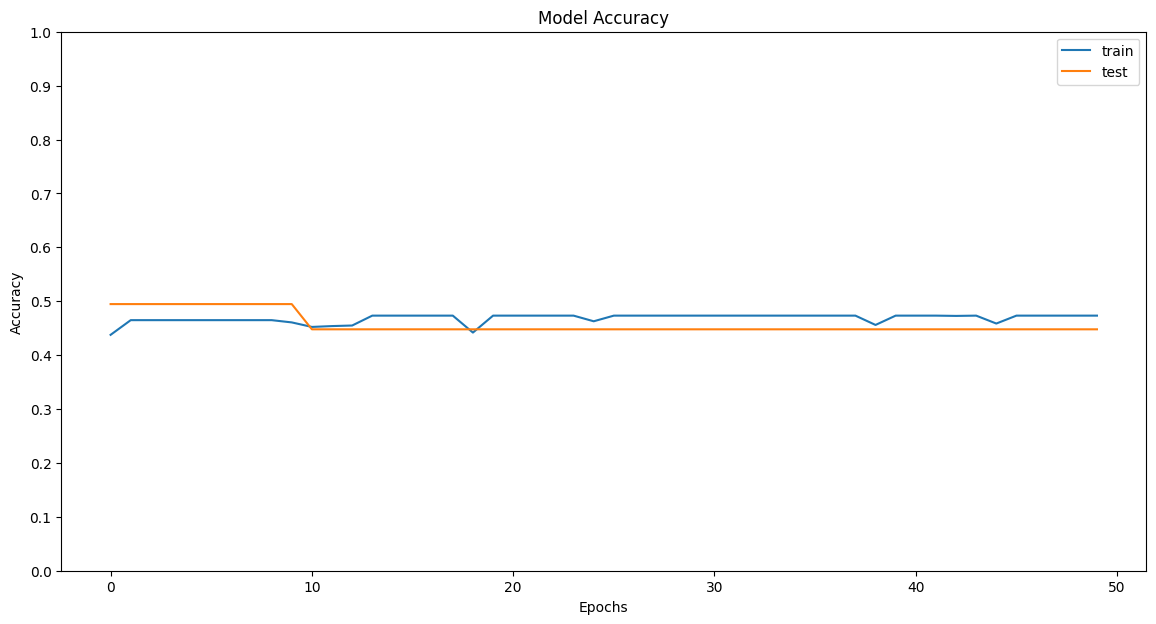

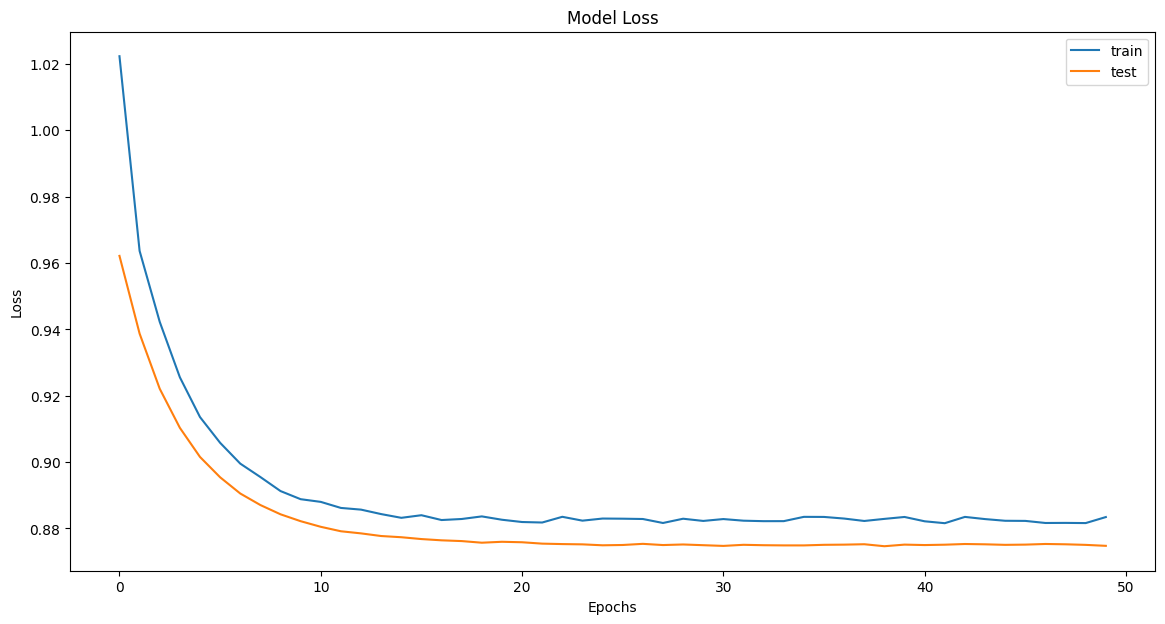

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 44.79%


For threshold set to 0.40, correctness is: 44.79%
For threshold set to 0.45, correctness is: 44.79%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(20,)



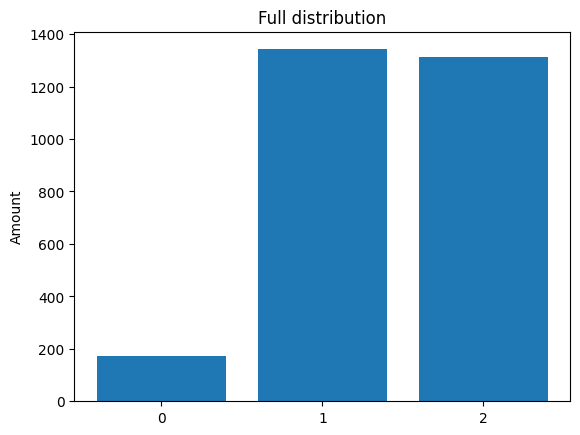

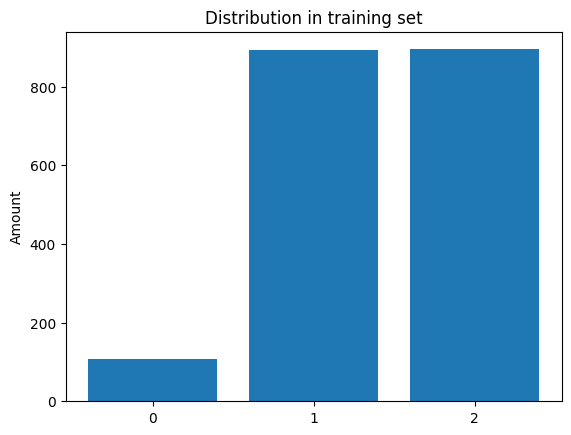

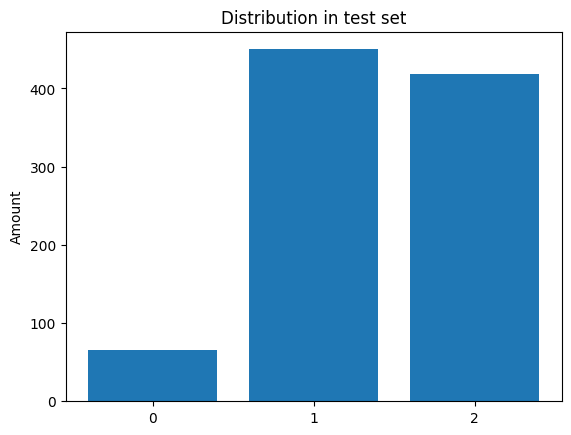

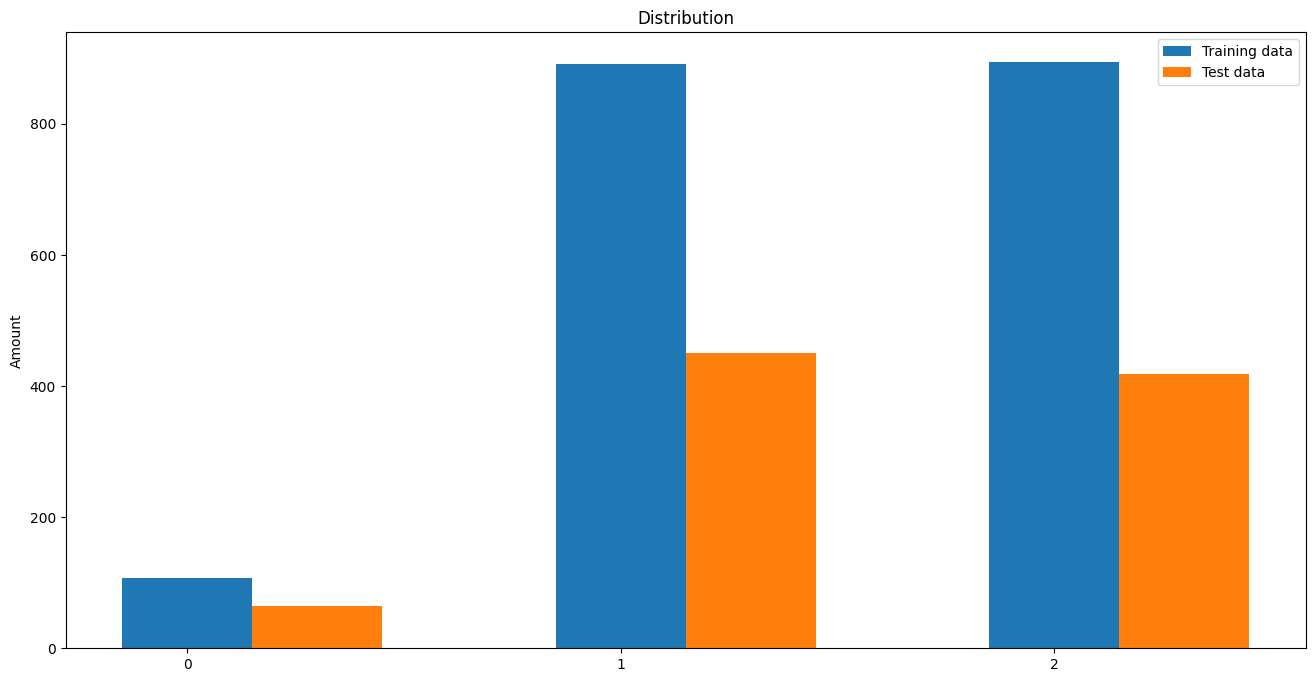


Example sequence from training set: [1 2 2 2 2 1 2 2 1 1 1 1 1 2 2 2 2 1 2 2] and its label: 2

Example sequence from test set: [0 1 2 1 1 1 1 2 2 2 2 2 1 2 2 2 1 1 1 1] and its label: 1


Gaussian Naive Bayes accuracy: 44.97%
Random forest classifier accuracy: 43.79%


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.3698 - loss: 1.0656 - val_accuracy: 0.4486 - val_loss: 0.9705
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4721 - loss: 0.9456 - val_accuracy: 0.4486 - val_loss: 0.9472
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4673 - loss: 0.9333 - val_accuracy: 0.4486 - val_loss: 0.9319
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4782 - loss: 0.9130 - val_accuracy: 0.4486 - val_loss: 0.9206
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4410 - loss: 0.9220 - val_accuracy: 0.4486 - val_loss: 0.9127
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4644 - loss: 0.9025 - val_accurac

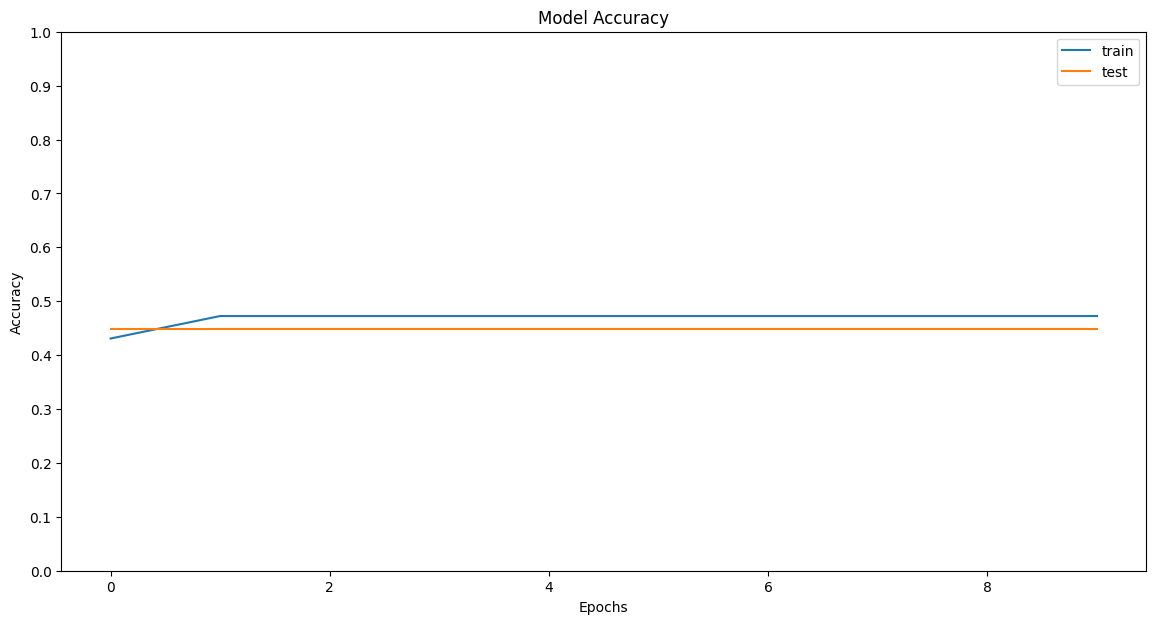

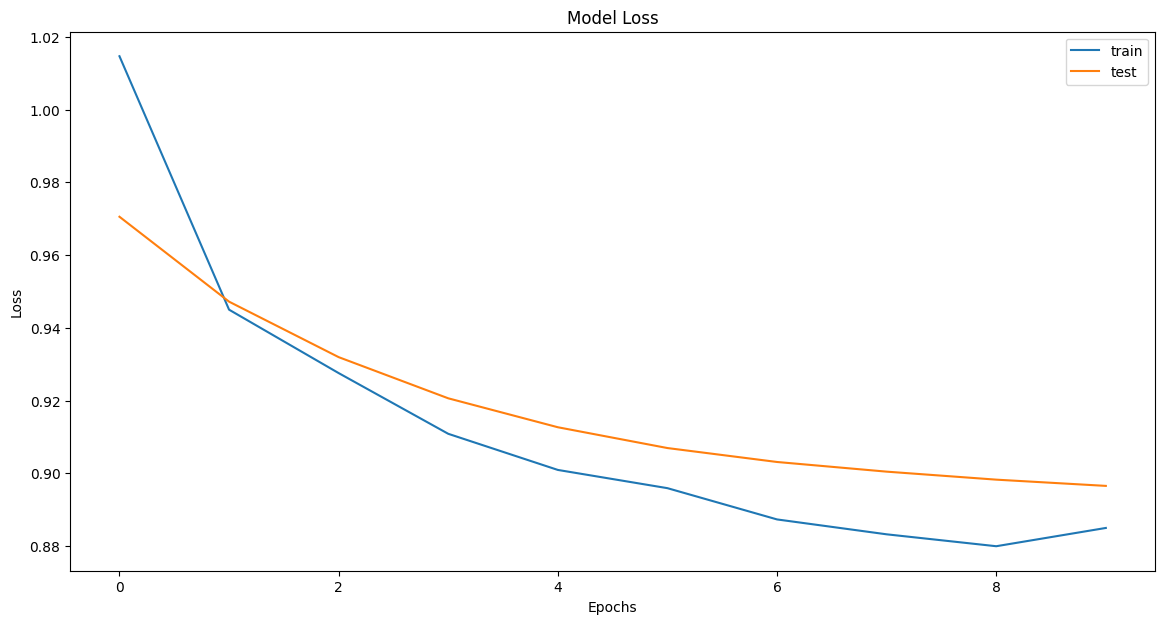

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Modal accuracy on test set: 44.86%


For threshold set to 0.40, correctness is: 44.86%
For threshold set to 0.45, correctness is: 44.86%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5100 - loss: 1.0157 - val_accuracy: 0.4486 - val_loss: 0.9409
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4742 - loss: 0.9192 - val_accuracy: 0.4486 - val_loss: 0.9237
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4762 - loss: 0.9063 - val_accuracy: 0.4486 - val_loss: 0.9128
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4753 - loss: 0.8944 - val_accuracy: 0.4486 - val_loss: 0.9064
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy

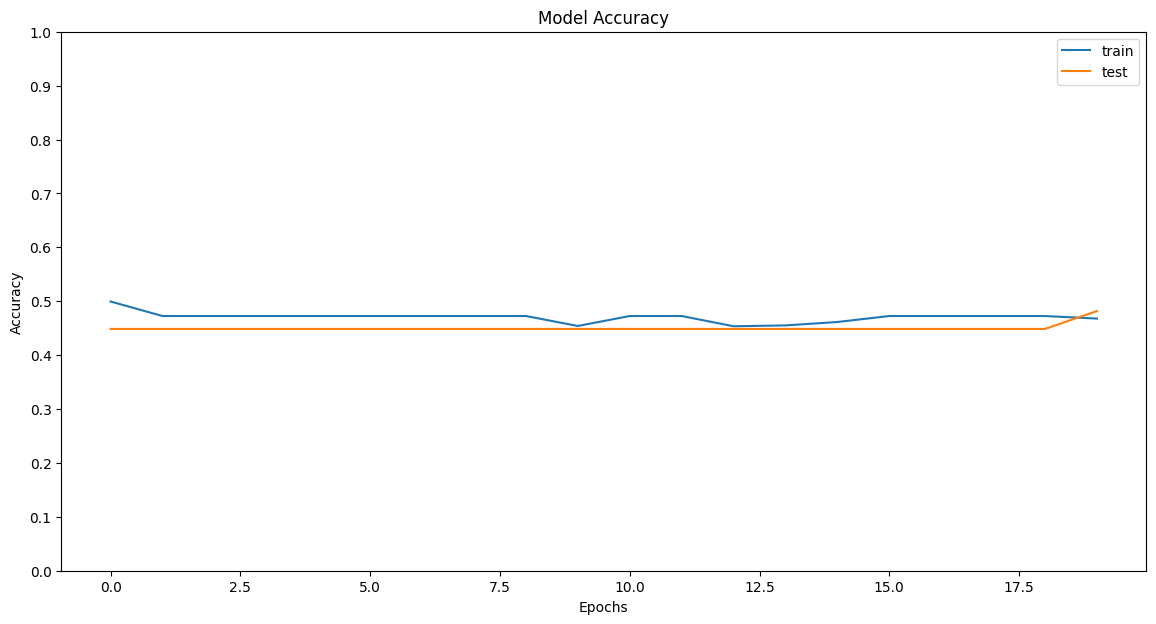

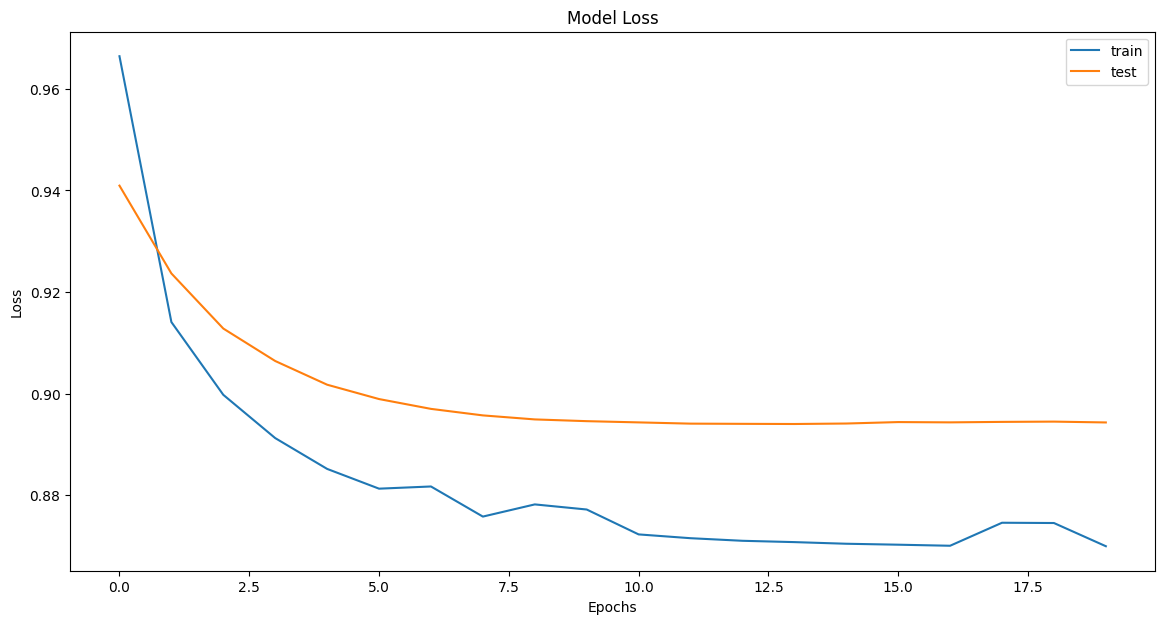

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 48.18%


For threshold set to 0.40, correctness is: 48.18%
For threshold set to 0.45, correctness is: 48.18%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4634 - loss: 1.0301 - val_accuracy: 0.4486 - val_loss: 0.9888
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4907 - loss: 0.9484 - val_accuracy: 0.4486 - val_loss: 0.9518
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4697 - loss: 0.9233 - val_accuracy: 0.4486 - val_loss: 0.9293
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4714 - loss: 0.9165 - val_accuracy: 0.4486 - val_loss: 0.9166
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

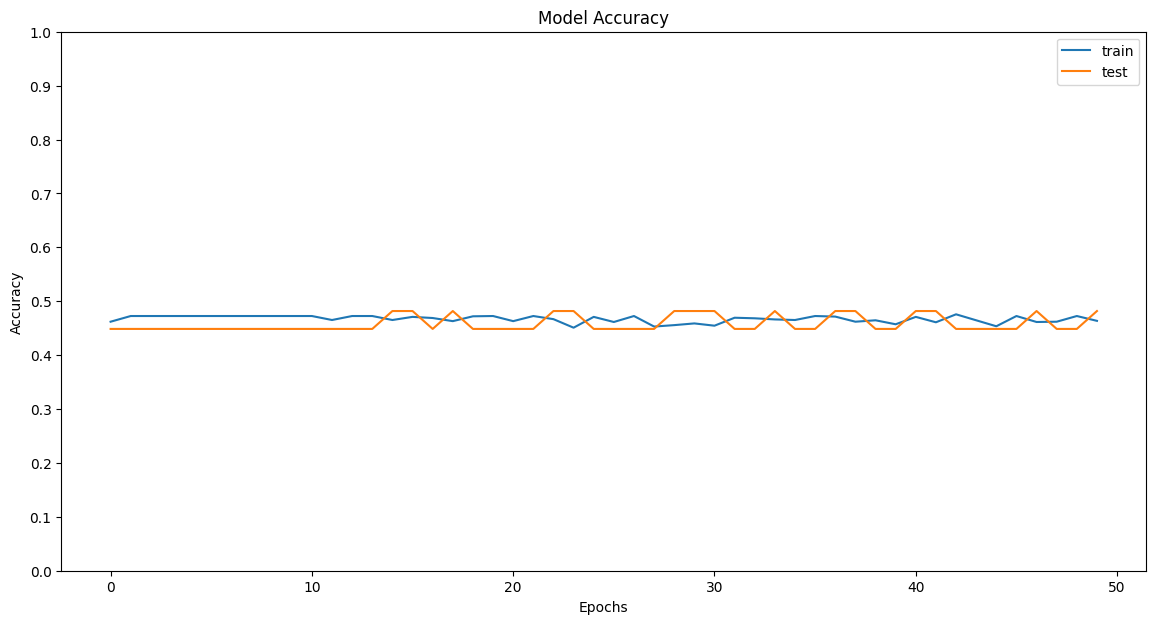

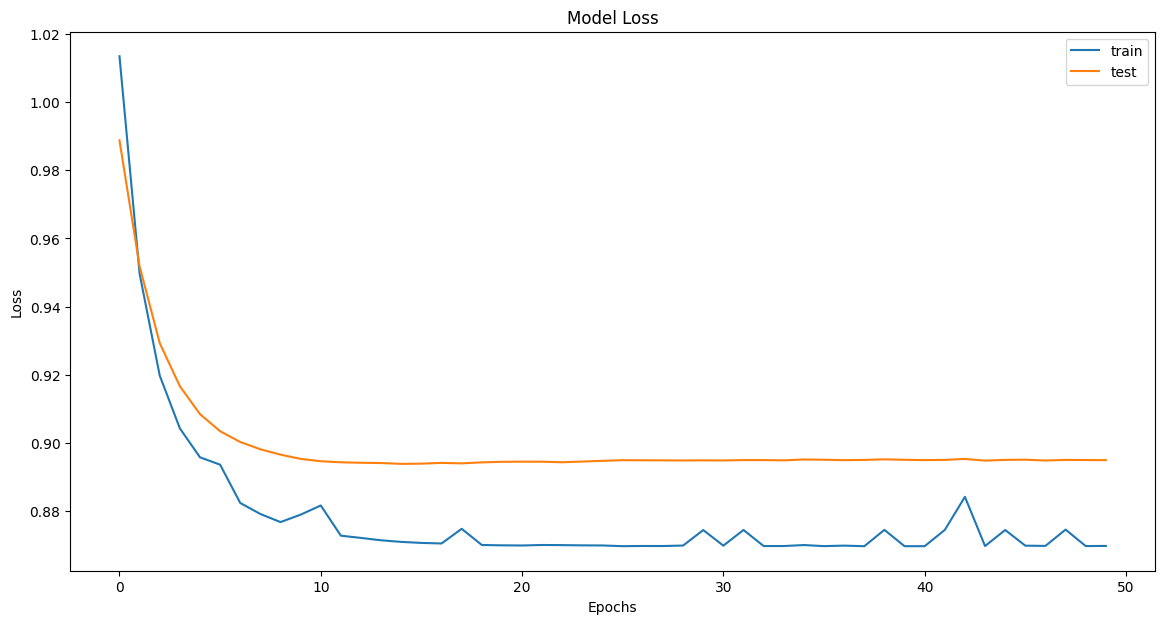

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Modal accuracy on test set: 48.18%


For threshold set to 0.40, correctness is: 48.18%
For threshold set to 0.45, correctness is: 48.18%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(40,)



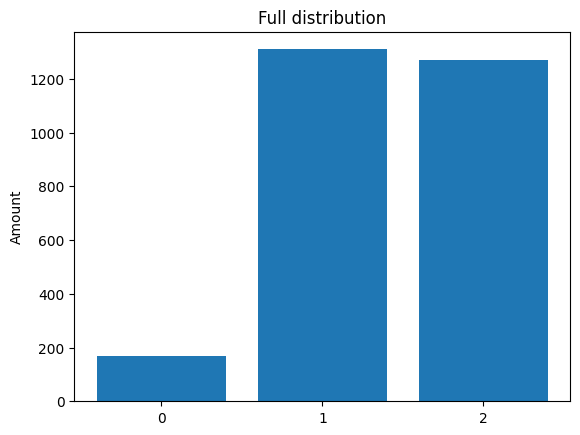

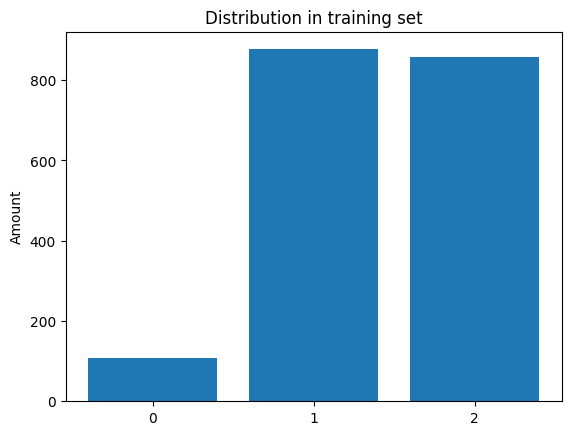

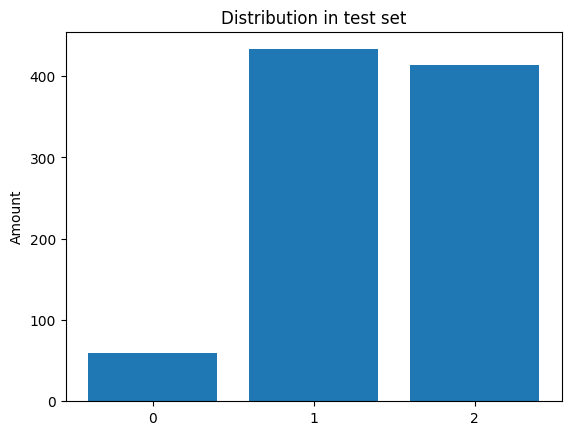

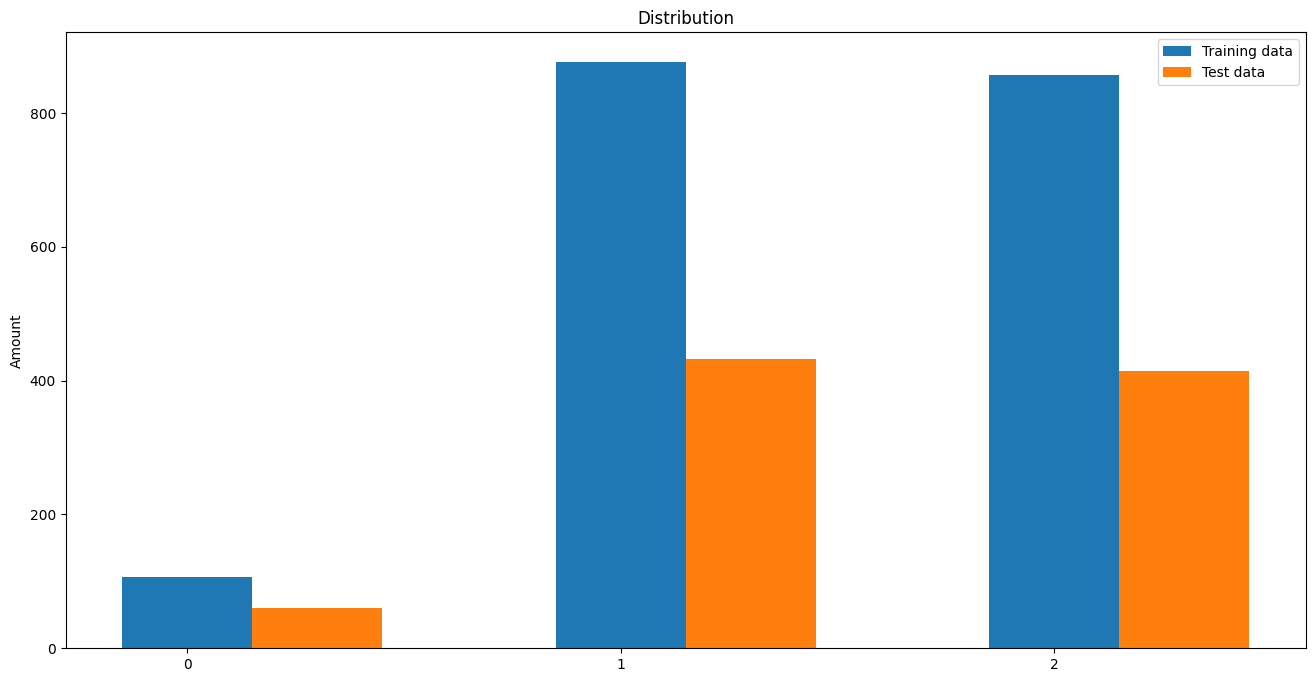


Example sequence from training set: [1 1 1 2 1 2 1 2 1 2 1 1 1 1 2 2 0 0 2 1 1 2 2 1 1 1 2 1 2 2 1 1 2 1 2 1 1
 1 1 2] and its label: 2

Example sequence from test set: [2 1 1 1 1 1 2 1 1 2 1 0 2 1 1 2 1 1 1 1 1 1 2 0 1 0 2 1 2 1 1 1 1 2 2 2 1
 2 2 2] and its label: 1


Gaussian Naive Bayes accuracy: 44.65%
Random forest classifier accuracy: 44.21%


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.4281 - loss: 1.1082 - val_accuracy: 0.4564 - val_loss: 1.0480
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4916 - loss: 1.0242 - val_accuracy: 0.4564 - val_loss: 0.9882
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4733 - loss: 0.9729 - val_accuracy: 0.4564 - val_loss: 0.9588
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4734 - loss: 0.9478 - val_accuracy: 0.4564 - val_loss: 0.9391
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4621 - loss: 0.9334 - val_accuracy: 0.4564 - val_loss: 0.9243
Epoch 6/10
58/5

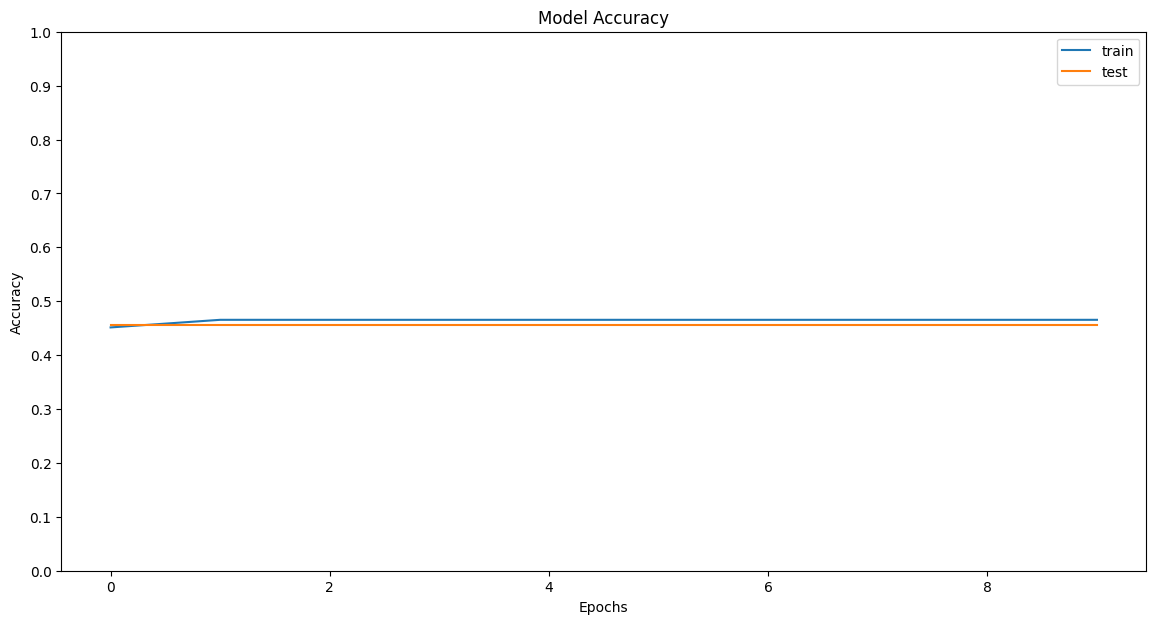

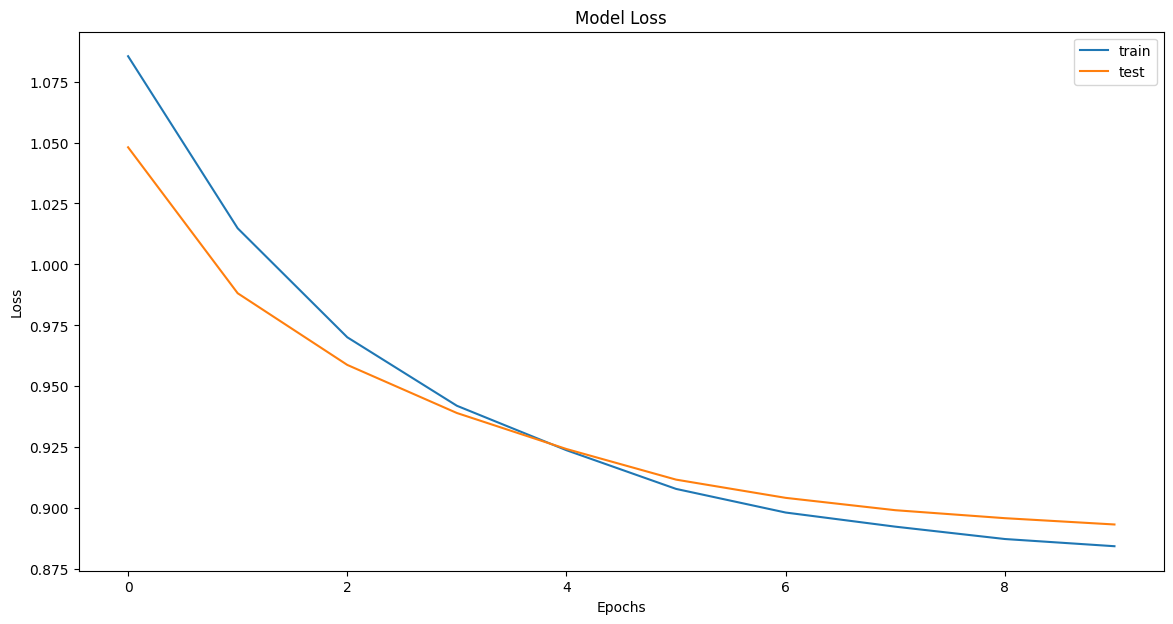

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Modal accuracy on test set: 45.64%


For threshold set to 0.40, correctness is: 45.64%
For threshold set to 0.45, correctness is: 45.64%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.3921 - loss: 1.0612 - val_accuracy: 0.4774 - val_loss: 0.9395
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4967 - loss: 0.9210 - val_accuracy: 0.4774 - val_loss: 0.9240
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4527 - loss: 0.9138 - val_accuracy: 0.4774 - val_loss: 0.9135
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4886 - loss: 0.9033 - val_accuracy: 0.4774 - val_loss: 0.9063
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

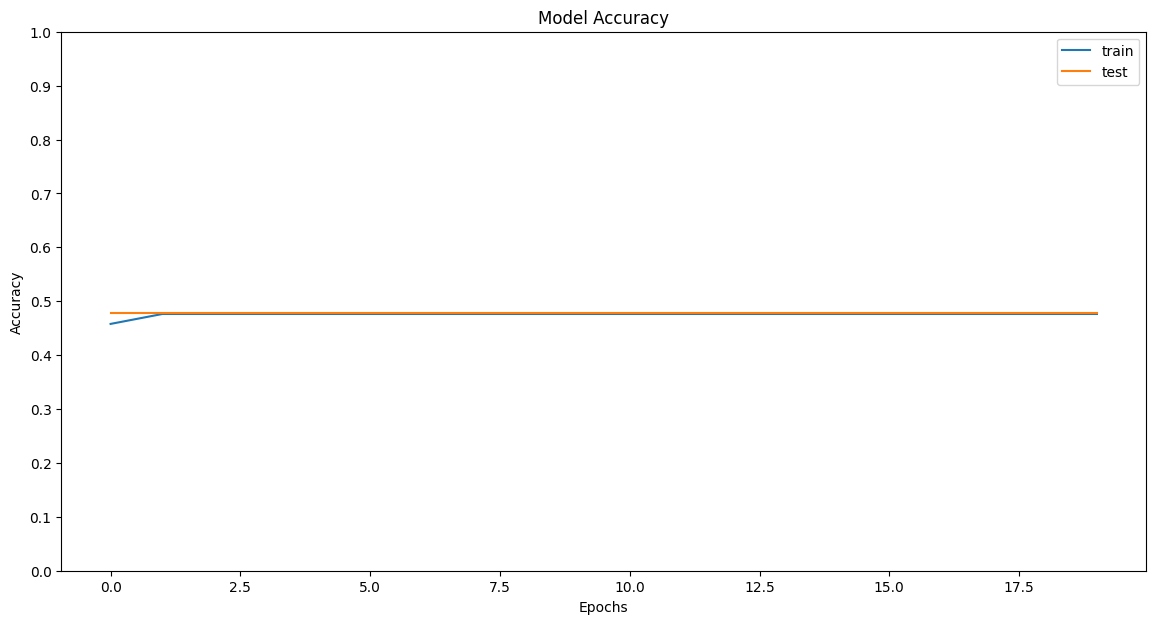

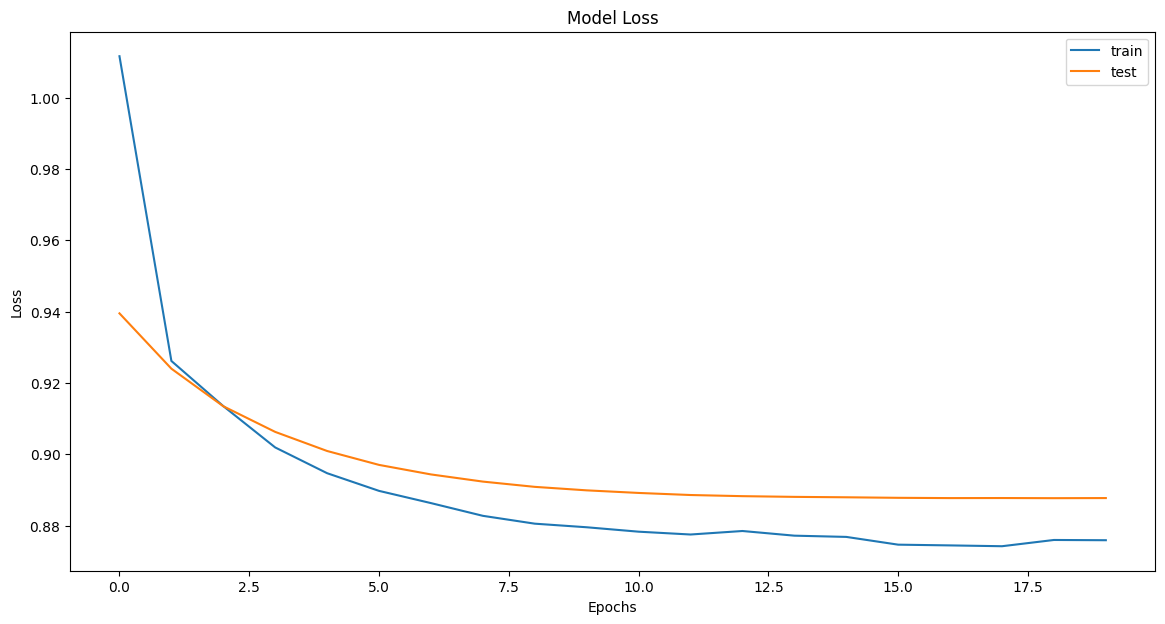

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 47.74%


For threshold set to 0.40, correctness is: 47.74%
For threshold set to 0.45, correctness is: 47.74%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.4612 - loss: 1.0521 - val_accuracy: 0.4564 - val_loss: 0.9605
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4688 - loss: 0.9514 - val_accuracy: 0.4564 - val_loss: 0.9407
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4644 - loss: 0.9301 - val_accuracy: 0.4564 - val_loss: 0.9263
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4712 - loss: 0.9164 - val_accuracy: 0.4564 - val_loss: 0.9158
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

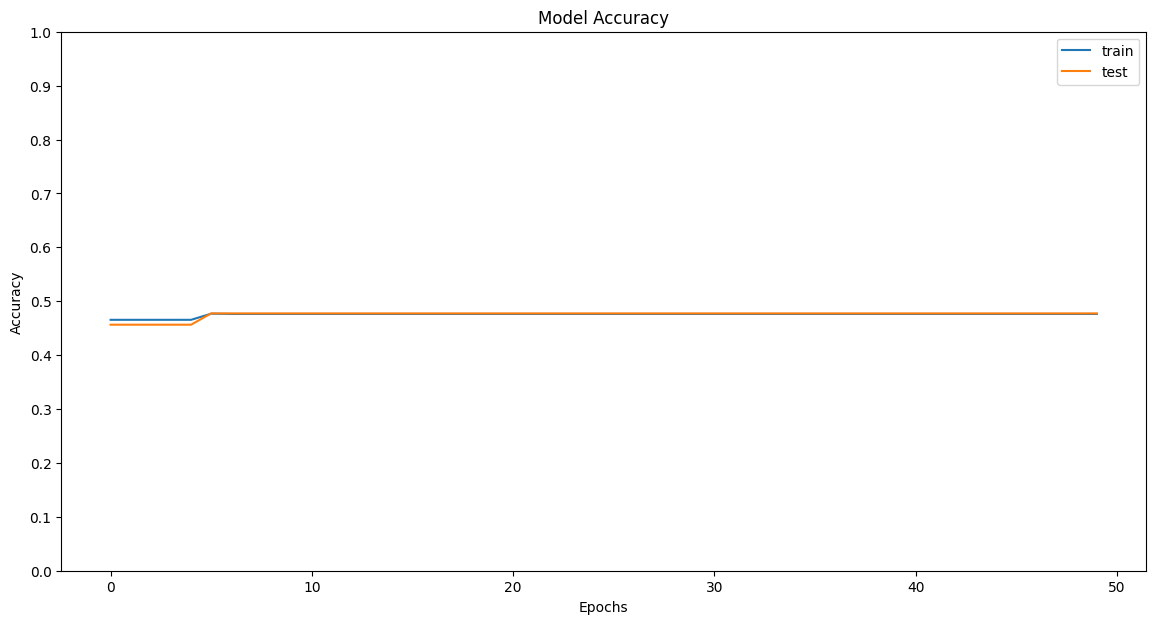

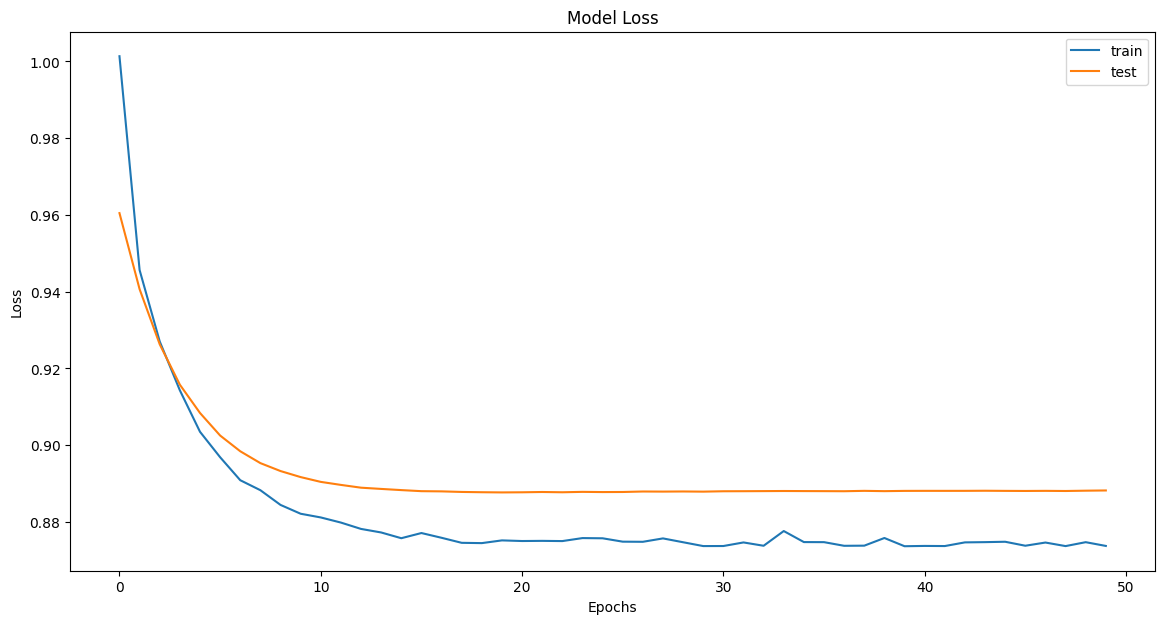

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 47.74%


For threshold set to 0.40, correctness is: 47.74%
For threshold set to 0.45, correctness is: 47.74%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Top 3 results:
Chunk size: 20, Epoch: 20, Accuracy: 48.18%
Chunk size: 20, Epoch: 50, Accuracy: 48.18%
Chunk size: 2, Epoch: 20, Accuracy: 48.17%

Data from file: plgbet.csv


Example sequence: ['red', 'black', 'red', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'green']

black: Counter({1: 387, 2: 164, 3: 90, 4: 40, 5: 19, 7: 6, 6: 5, 8: 2, 9: 1})
red: Counter({1: 366, 2: 180, 3: 99, 4: 29, 5: 13, 6: 9, 7: 4, 10: 2, 8: 1})
green: Counter({1: 171, 2: 6})




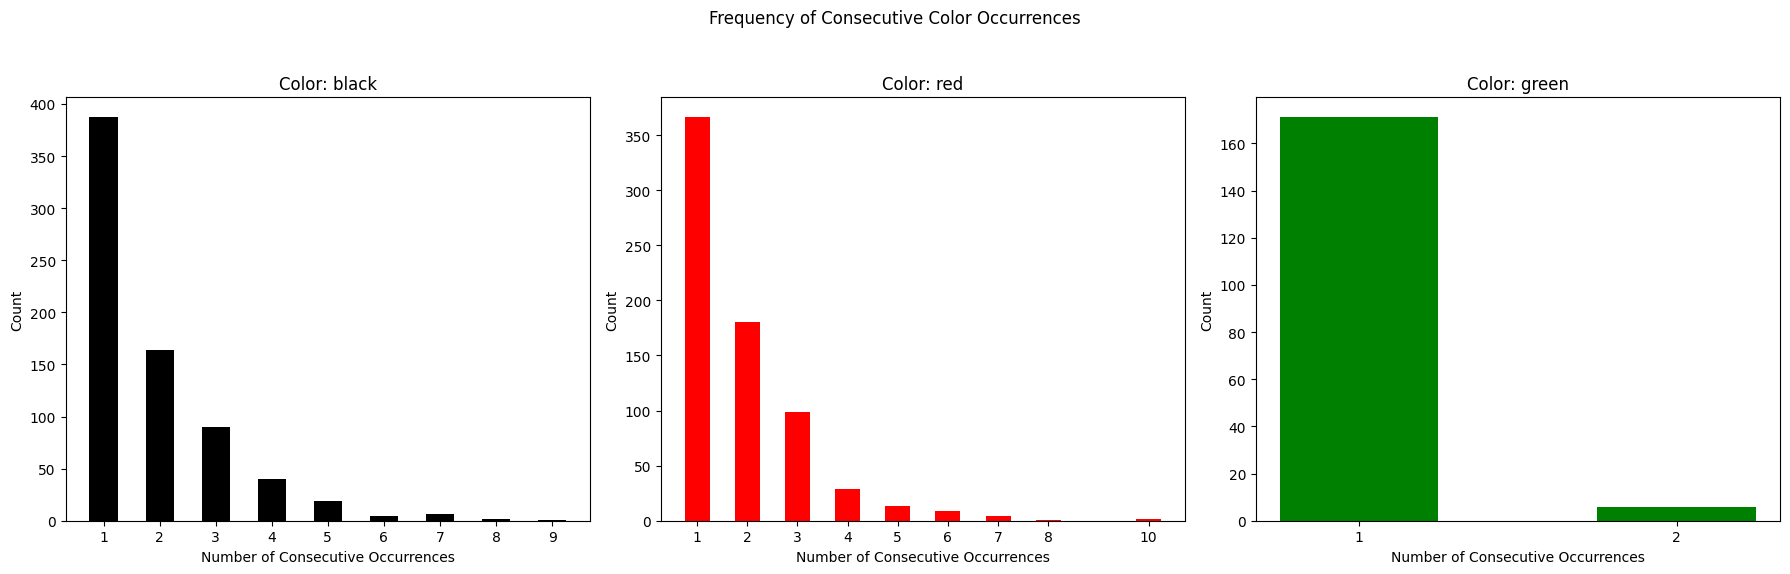

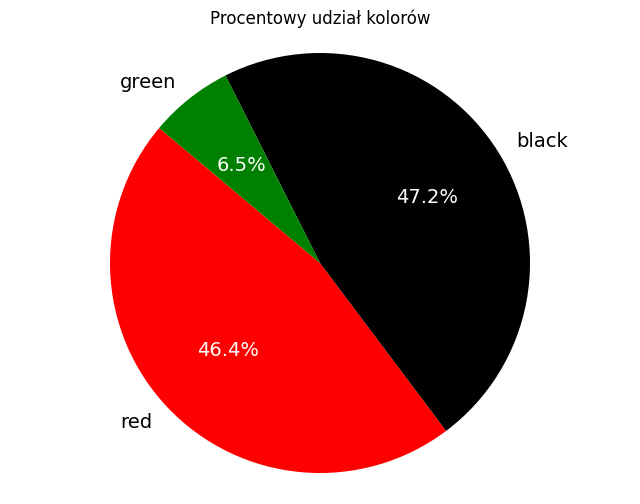


(2,)



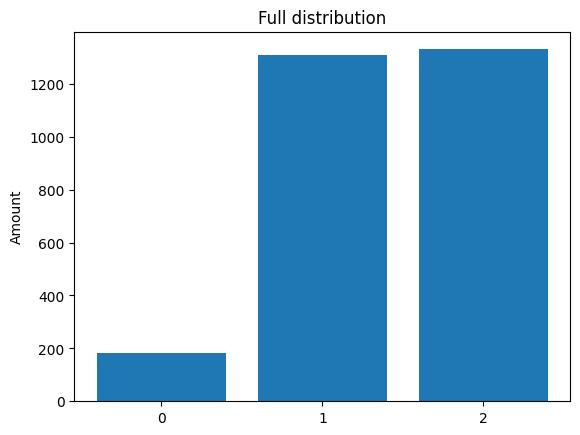

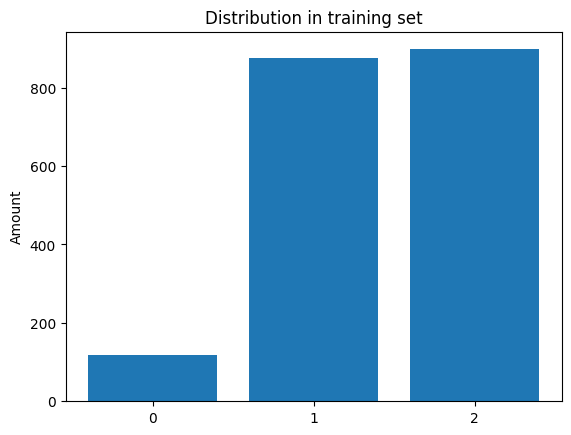

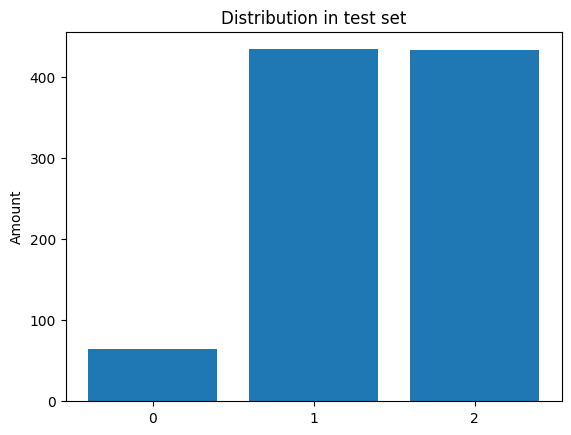

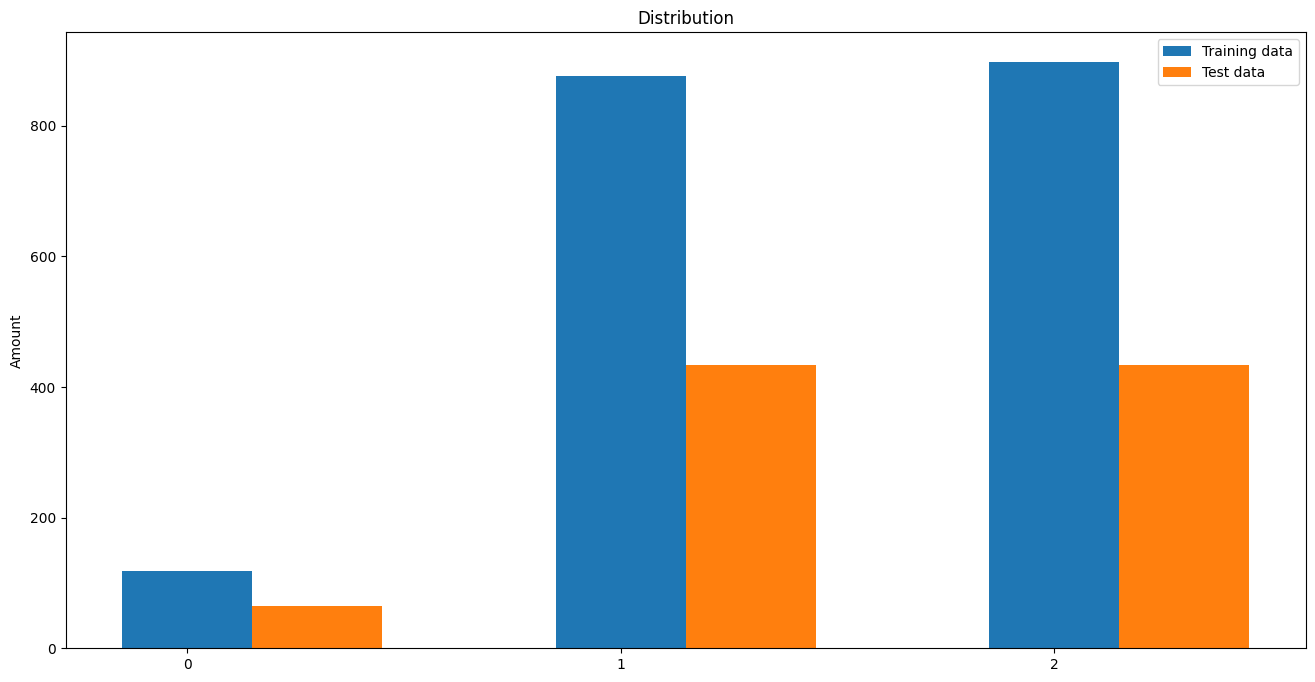


Example sequence from training set: [2 1] and its label: 1

Example sequence from test set: [2 1] and its label: 2


Gaussian Naive Bayes accuracy: 46.78%
Random forest classifier accuracy: 47.53%


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.3526 - loss: 1.0649 - val_accuracy: 0.4646 - val_loss: 0.9237
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4926 - loss: 0.9137 - val_accuracy: 0.4646 - val_loss: 0.9147
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4774 - loss: 0.8896 - val_accuracy: 0.4646 - val_loss: 0.9083
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4607 - loss: 0.9066 - val_accuracy: 0.4646 - val_loss: 0.9041
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4888 - loss: 0.8842 - val_accuracy: 0.4646 - val_loss: 0.9007
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4771 - loss: 0.8825 - val_accuracy: 0.4646 - val_loss: 0.8985
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

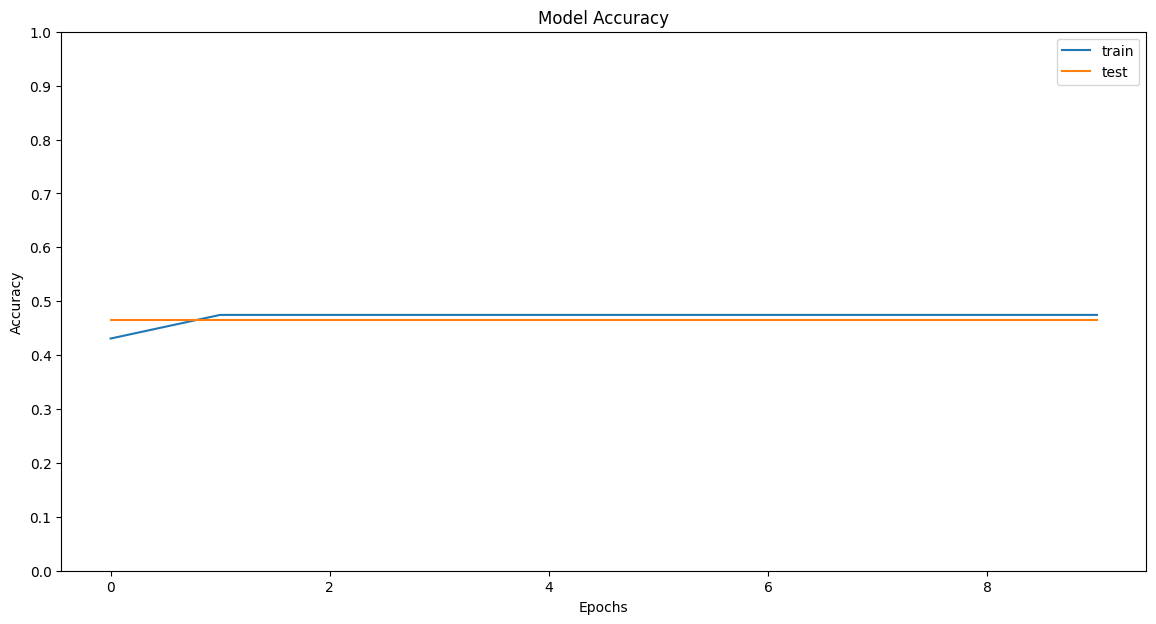

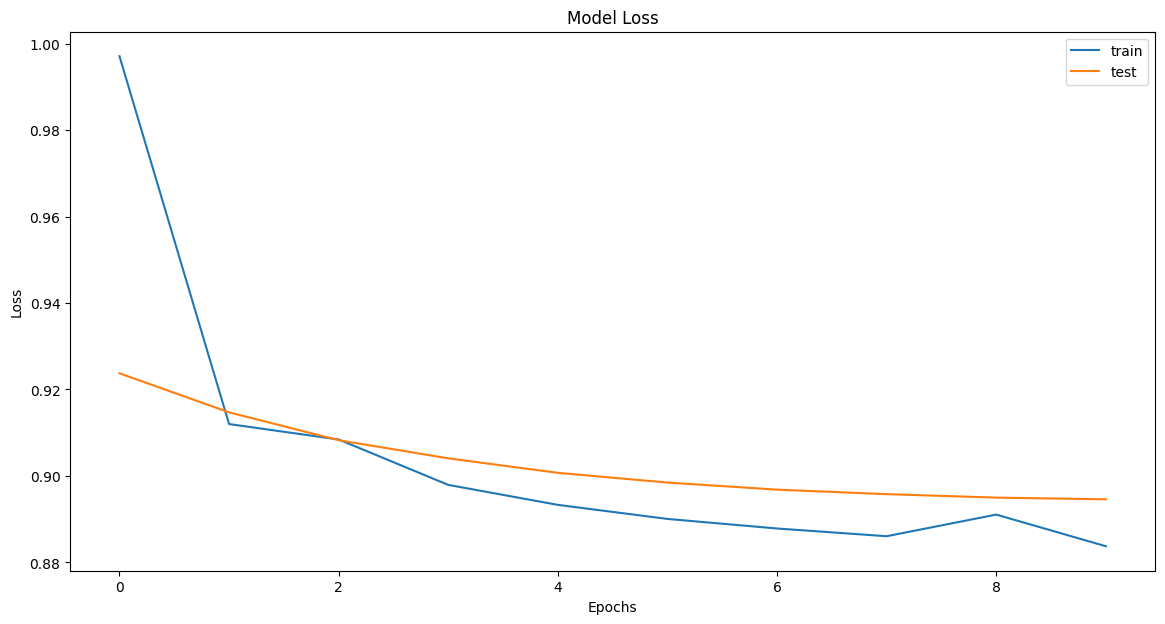

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Modal accuracy on test set: 46.46%


For threshold set to 0.40, correctness is: 46.46%
For threshold set to 0.45, correctness is: 46.46%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.3559 - loss: 1.0396 - val_accuracy: 0.4657 - val_loss: 0.9134
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4701 - loss: 0.8917 - val_accuracy: 0.4657 - val_loss: 0.9062
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4588 - loss: 0.9071 - val_accuracy: 0.4657 - val_loss: 0.9021
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4628 - loss: 0.8952 - val_accuracy: 0.4646 - val_loss: 0.8991
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

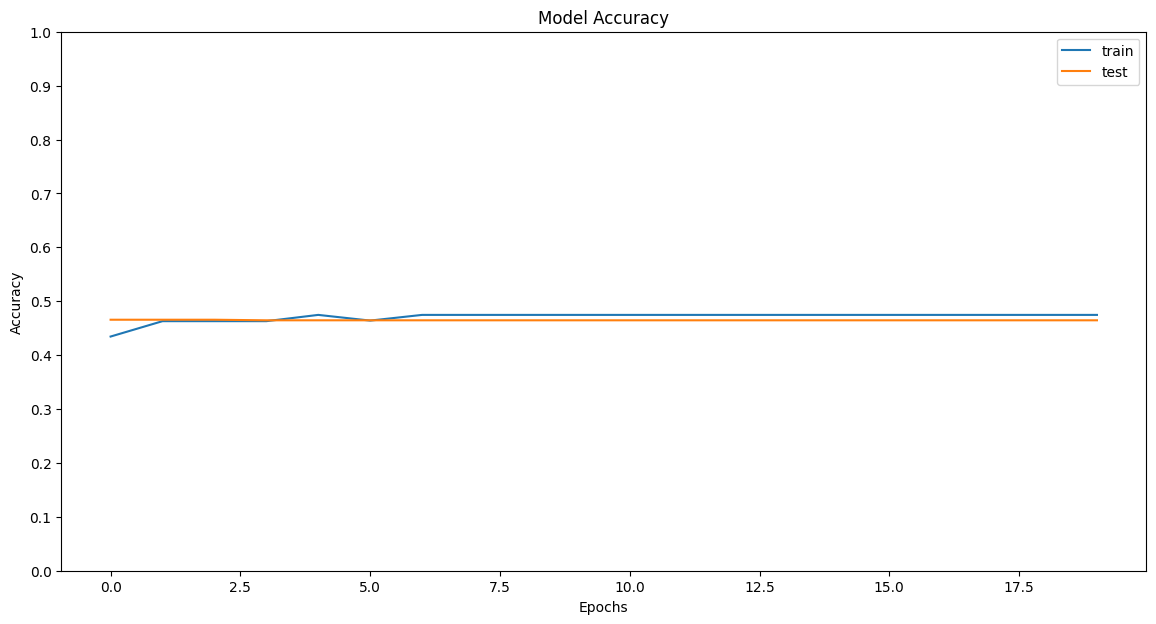

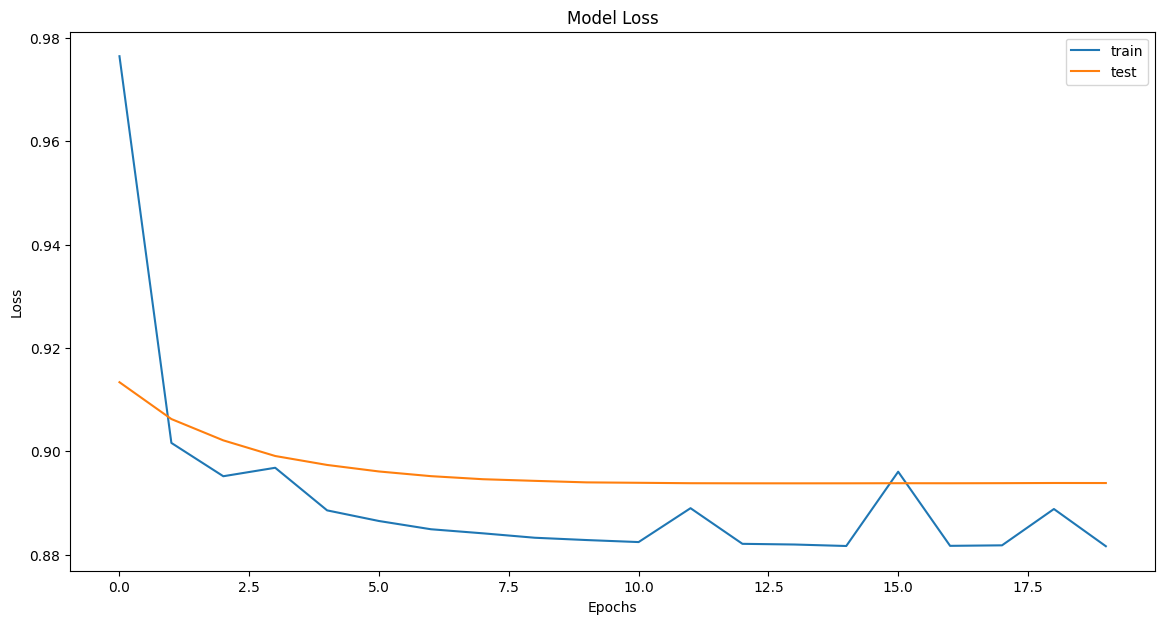

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 46.46%


For threshold set to 0.40, correctness is: 46.46%
For threshold set to 0.45, correctness is: 46.46%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.3053 - loss: 1.0815 - val_accuracy: 0.4657 - val_loss: 0.9633
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4572 - loss: 0.9523 - val_accuracy: 0.4657 - val_loss: 0.9405
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4465 - loss: 0.9419 - val_accuracy: 0.4657 - val_loss: 0.9271
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4487 - loss: 0.9178 - val_accuracy: 0.4678 - val_loss: 0.9174
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

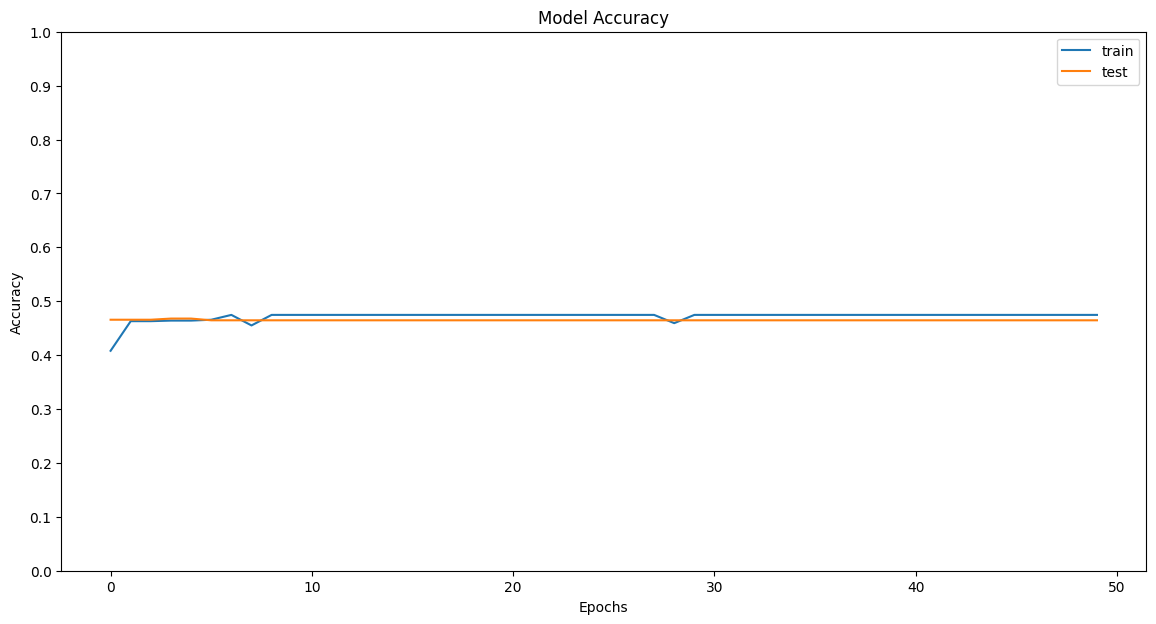

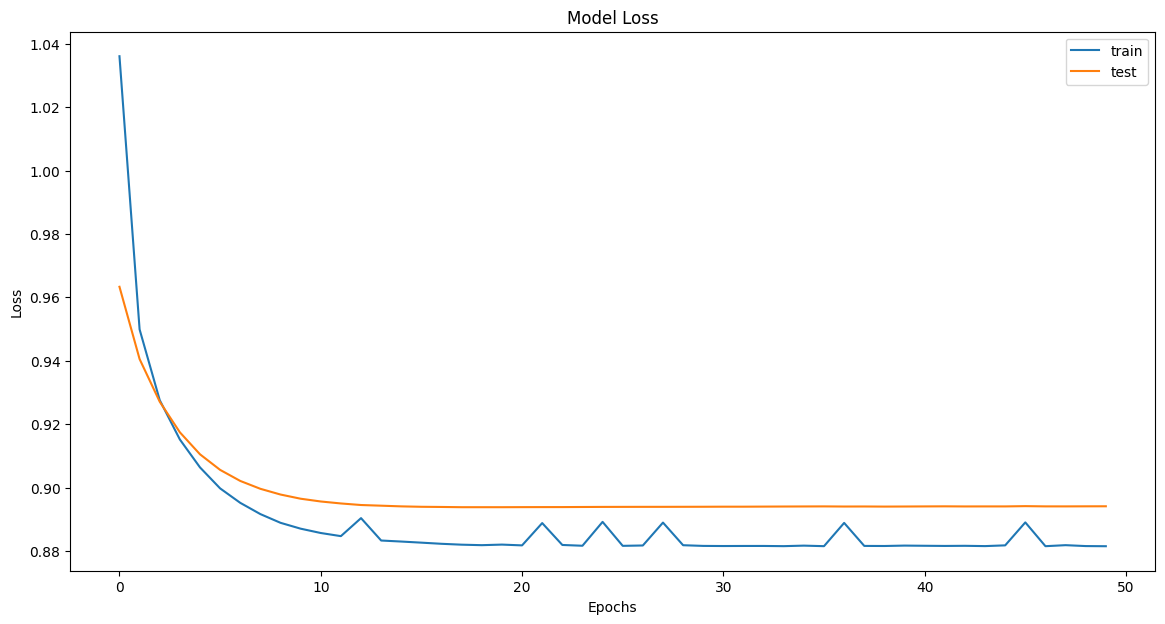

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Modal accuracy on test set: 46.46%


For threshold set to 0.40, correctness is: 46.46%
For threshold set to 0.45, correctness is: 46.46%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(5,)



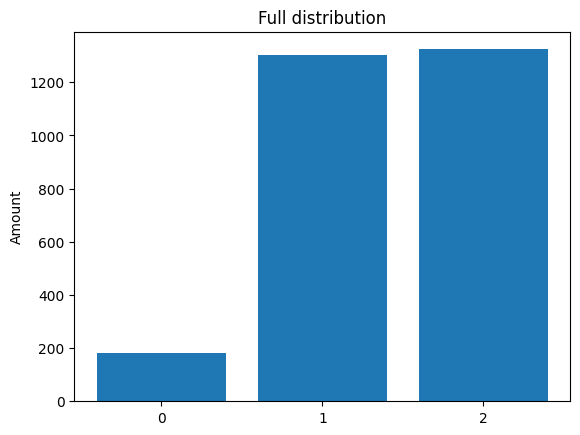

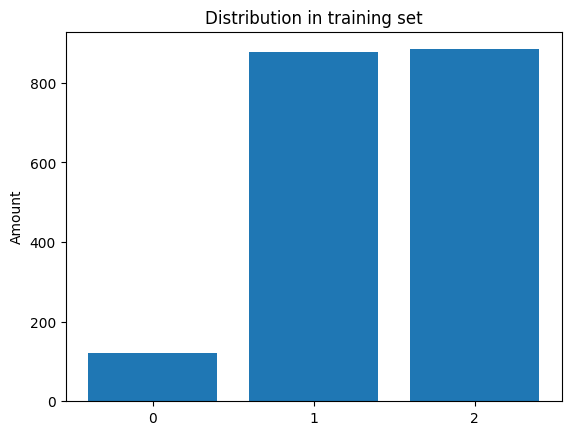

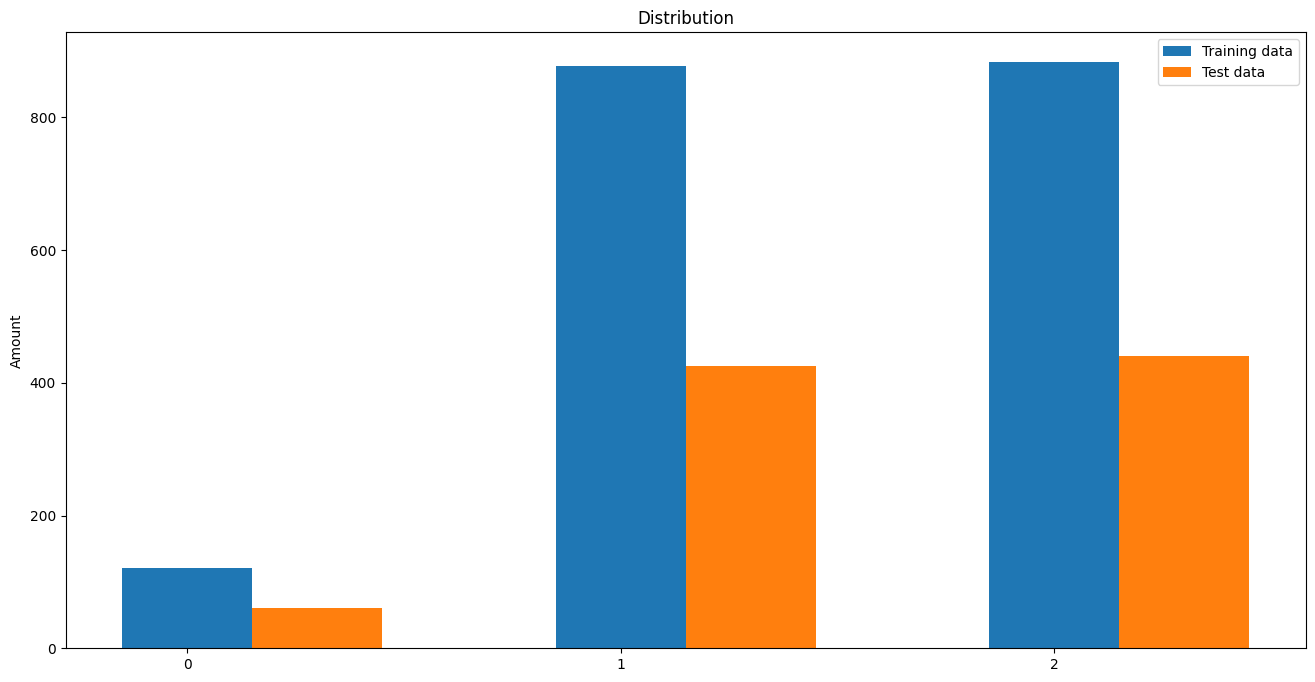


Example sequence from training set: [1 2 2 1 1] and its label: 0

Example sequence from test set: [2 2 2 1 2] and its label: 2


Gaussian Naive Bayes accuracy: 43.69%
Random forest classifier accuracy: 44.77%


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.2384 - loss: 1.1022 - val_accuracy: 0.4746 - val_loss: 0.9726
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4824 - loss: 0.9587 - val_accuracy: 0.4746 - val_loss: 0.9495
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4866 - loss: 0.9379 - val_accuracy: 0.4746 - val_loss: 0.9330
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4747 - loss: 0.9333 - val_accuracy: 0.4746 - val_loss: 0.9217
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4589 - loss: 0.9221 - val_accuracy: 0.4746 - val_loss: 0.9129
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4611 - loss: 0.9176 - val_accuracy: 0.4746 - val_loss: 0.9068
Epoch 7/10
59/59 ━━━━━━━━━━━━━━

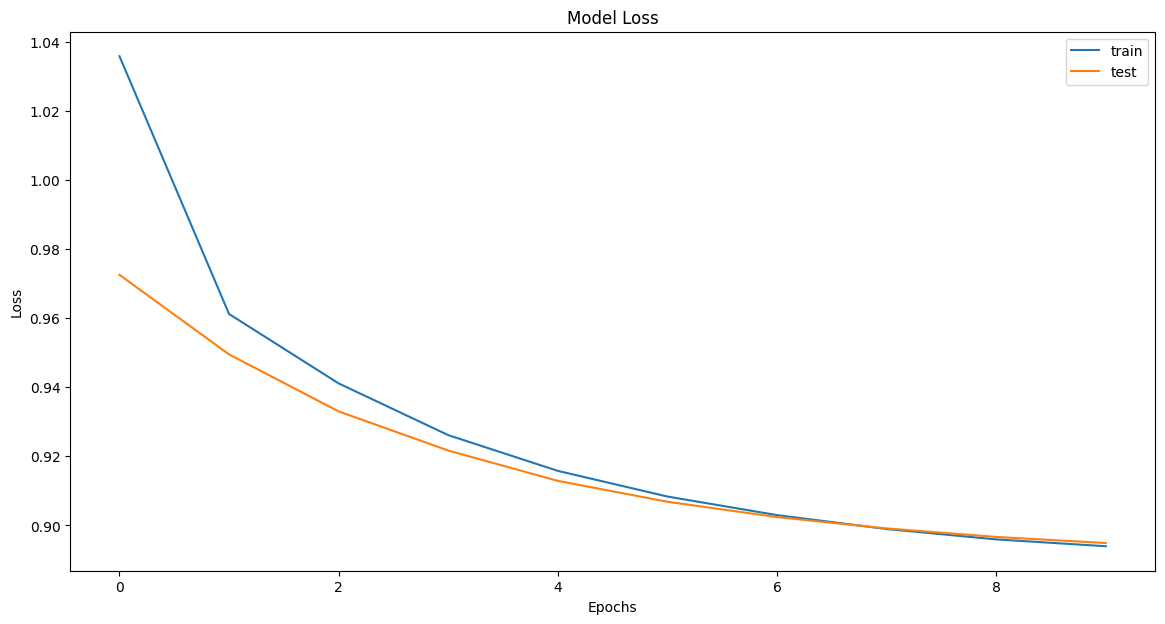

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 47.46%


For threshold set to 0.40, correctness is: 47.46%
For threshold set to 0.45, correctness is: 47.46%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.4663 - loss: 1.0417 - val_accuracy: 0.4746 - val_loss: 0.9887
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4445 - loss: 0.9739 - val_accuracy: 0.4746 - val_loss: 0.9513
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4578 - loss: 0.9486 - val_accuracy: 0.4746 - val_loss: 0.9326
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4653 - loss: 0.9312 - val_accuracy: 0.4746 - val_loss: 0.9203
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

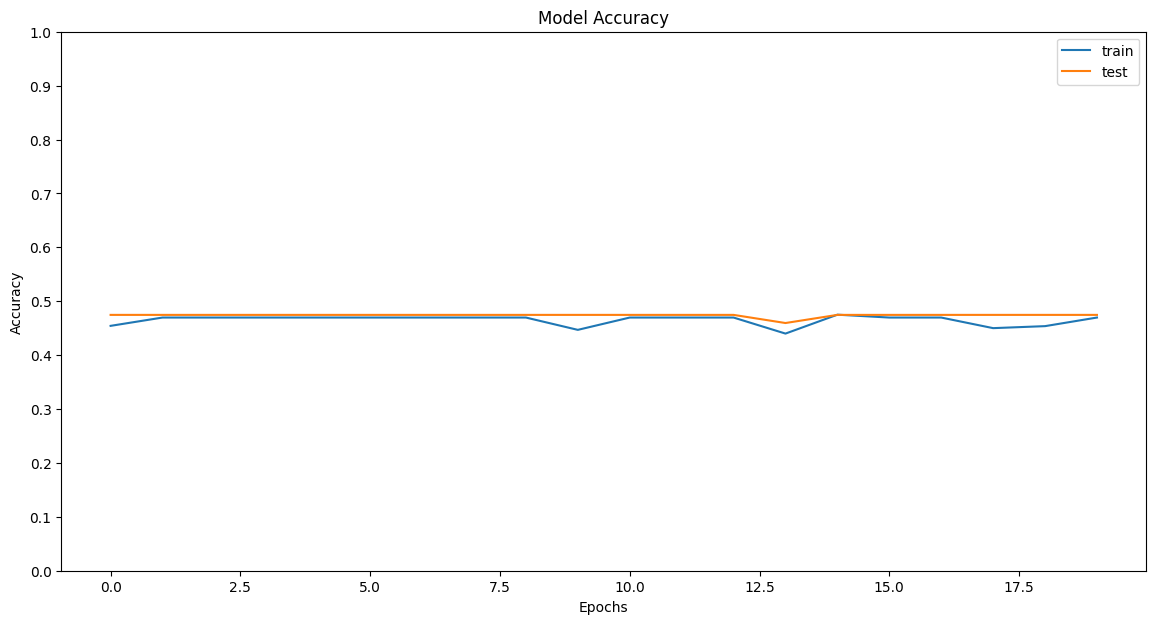

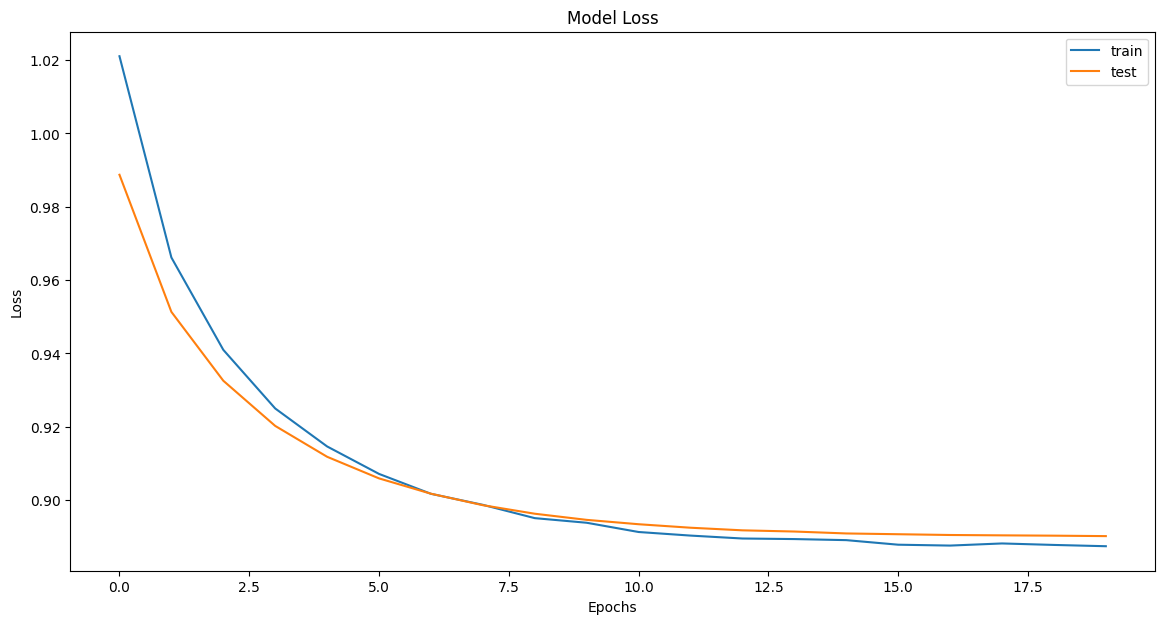

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Modal accuracy on test set: 47.46%


For threshold set to 0.40, correctness is: 47.46%
For threshold set to 0.45, correctness is: 47.46%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.4649 - loss: 1.0429 - val_accuracy: 0.4617 - val_loss: 1.0000
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4886 - loss: 0.9861 - val_accuracy: 0.4595 - val_loss: 0.9685
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4603 - loss: 0.9599 - val_accuracy: 0.4595 - val_loss: 0.9466
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4545 - loss: 0.9444 - val_accuracy: 0.4595 - val_loss: 0.9315
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

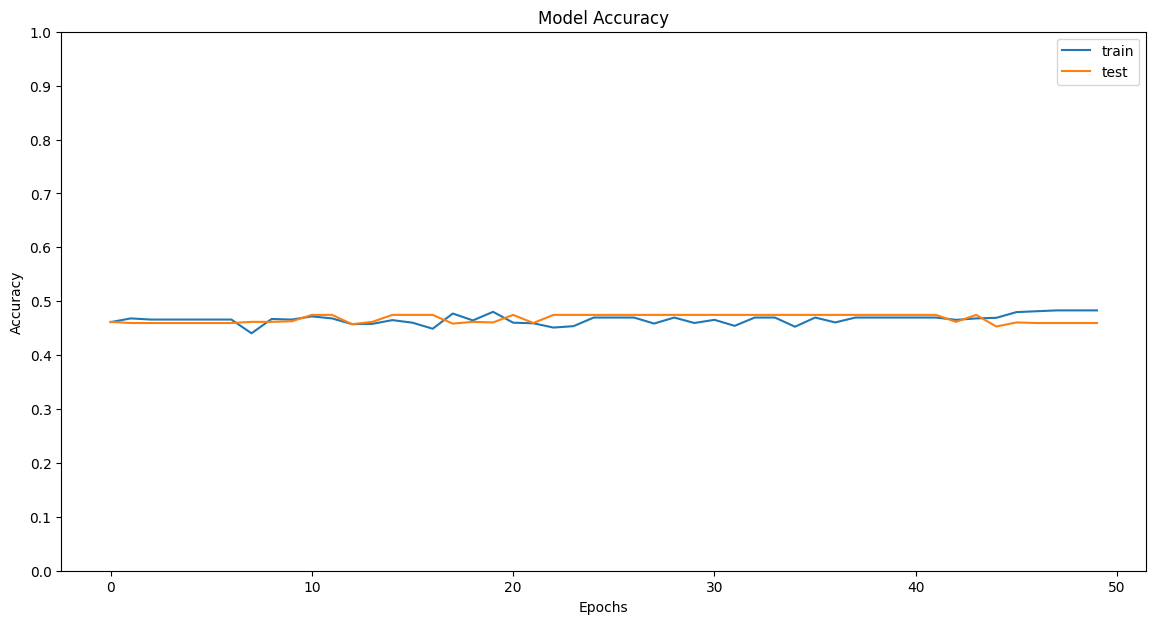

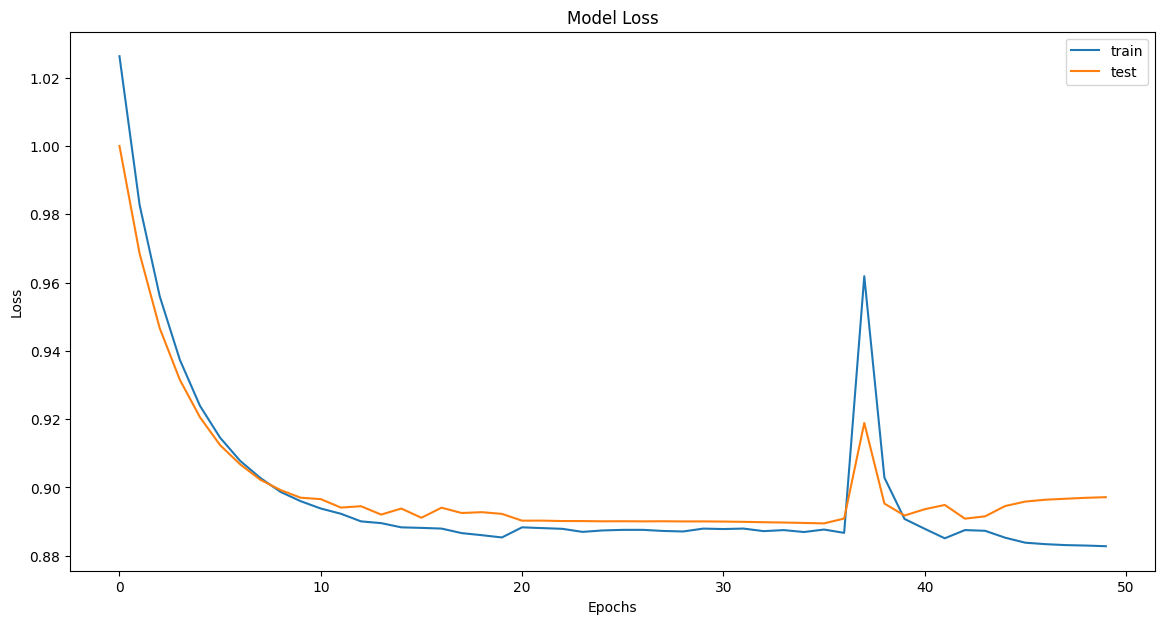

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Modal accuracy on test set: 45.95%


For threshold set to 0.40, correctness is: 45.95%
For threshold set to 0.45, correctness is: 45.95%
For threshold set to 0.50, correctness is: 46.15%
For threshold set to 0.55, correctness is: 46.15%
For threshold set to 0.60, correctness is: 46.15%
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(10,)



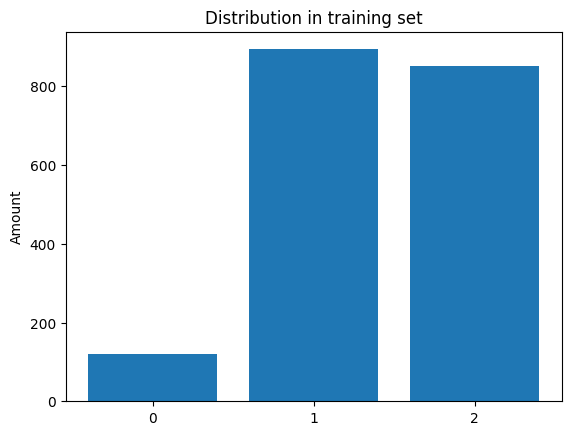

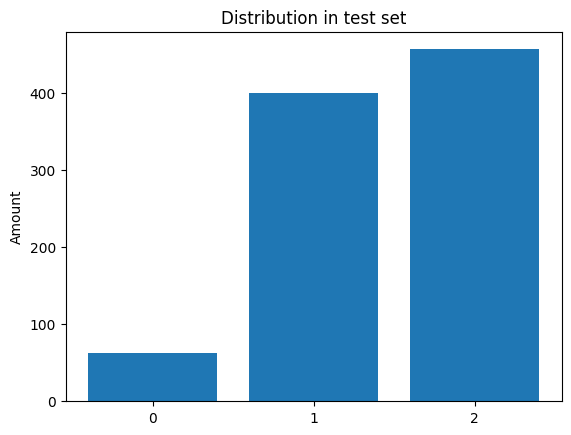

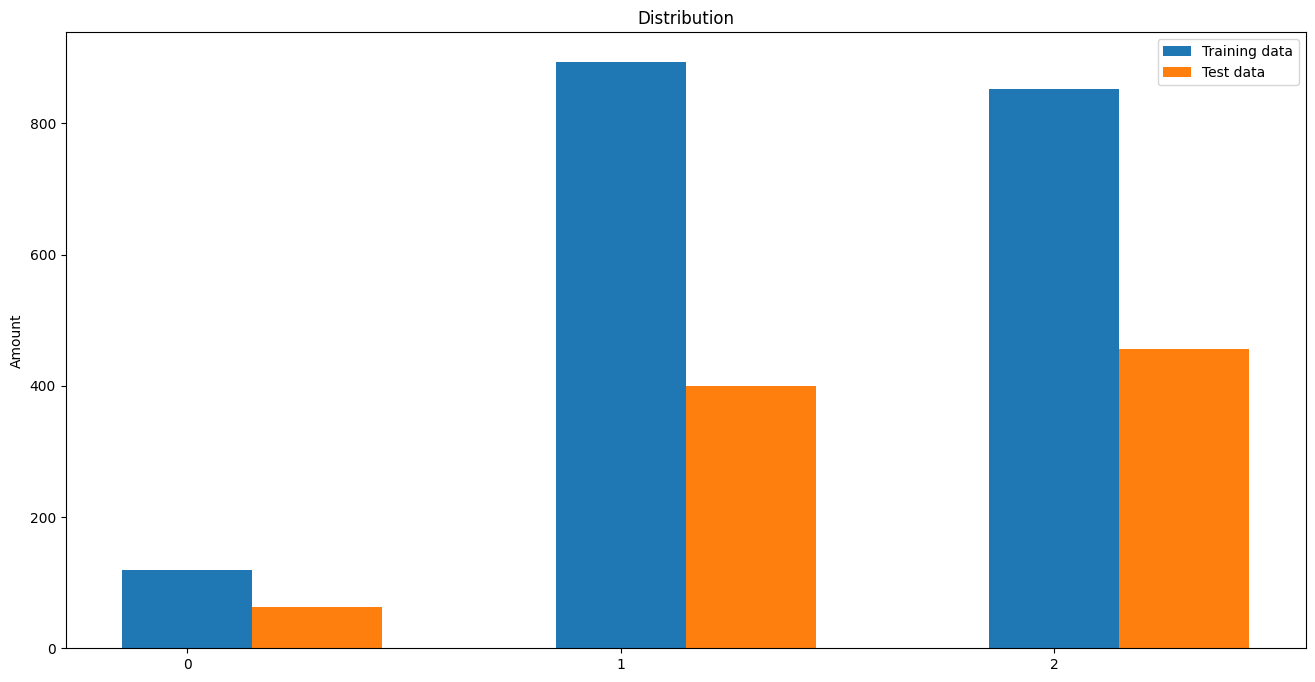


Example sequence from training set: [2 2 0 1 1 2 1 2 1 1] and its label: 0

Example sequence from test set: [1 1 0 2 1 2 1 2 2 2] and its label: 1


Gaussian Naive Bayes accuracy: 46.35%
Random forest classifier accuracy: 44.29%


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.3780 - loss: 1.0867 - val_accuracy: 0.4353 - val_loss: 0.9993
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4357 - loss: 0.9844 - val_accuracy: 0.4962 - val_loss: 0.9442
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4600 - loss: 0.9440 - val_accuracy: 0.4962 - val_loss: 0.9282
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4710 - loss: 0.9248 - val_accuracy: 0.4962 - val_loss: 0.9186
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4656 - loss: 0.9093 - val_accuracy: 0.4962 - val_loss: 0.9124
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4561 - loss: 0.9063 - val_accuracy: 0.4353 - val_loss: 0.9075
Epoch 7/10


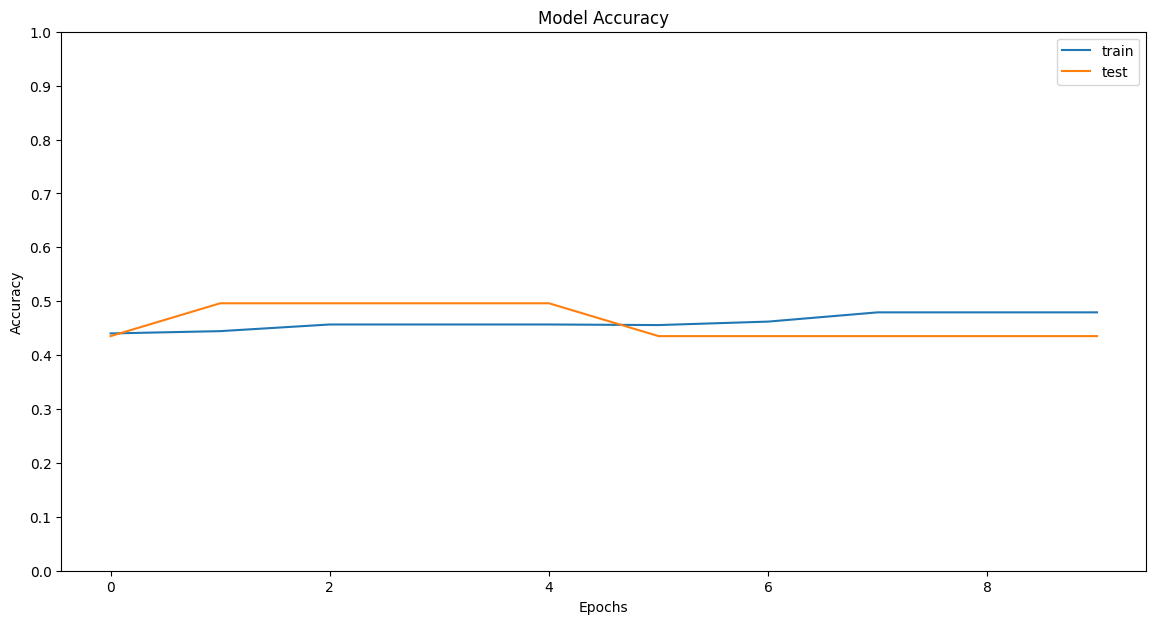

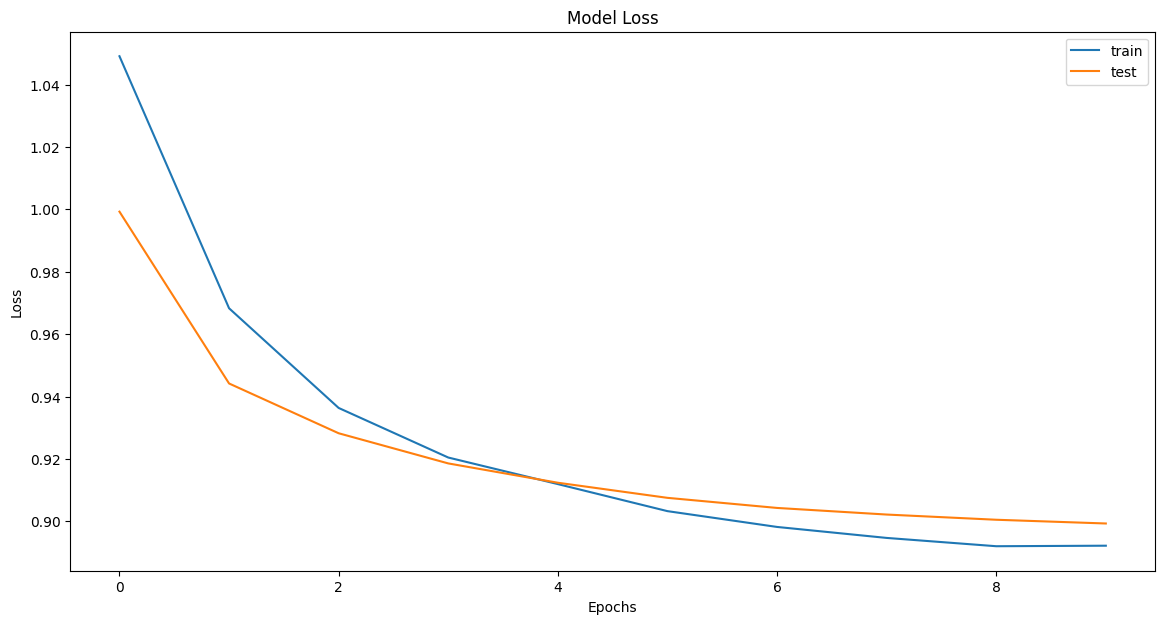

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Modal accuracy on test set: 43.53%


For threshold set to 0.40, correctness is: 43.53%
For threshold set to 0.45, correctness is: 43.53%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.2866 - loss: 1.0980 - val_accuracy: 0.4962 - val_loss: 1.0124
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4669 - loss: 1.0059 - val_accuracy: 0.4962 - val_loss: 0.9618
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4520 - loss: 0.9691 - val_accuracy: 0.4962 - val_loss: 0.9223
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4509 - loss: 0.9207 - val_accuracy: 0.4962 - val_loss: 0.9136
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

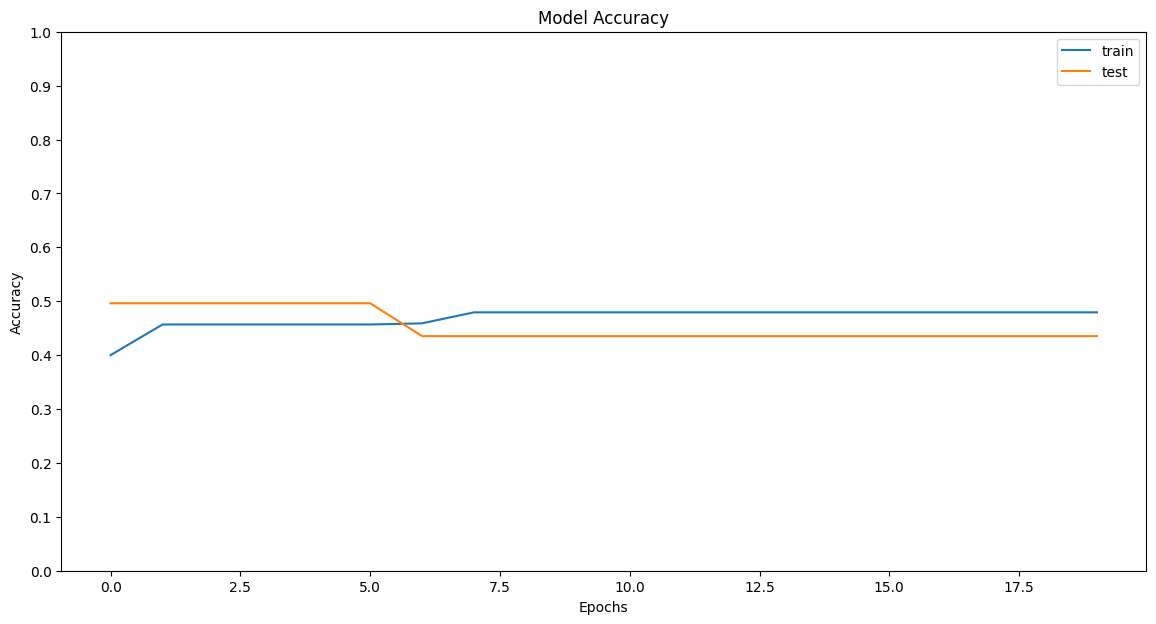

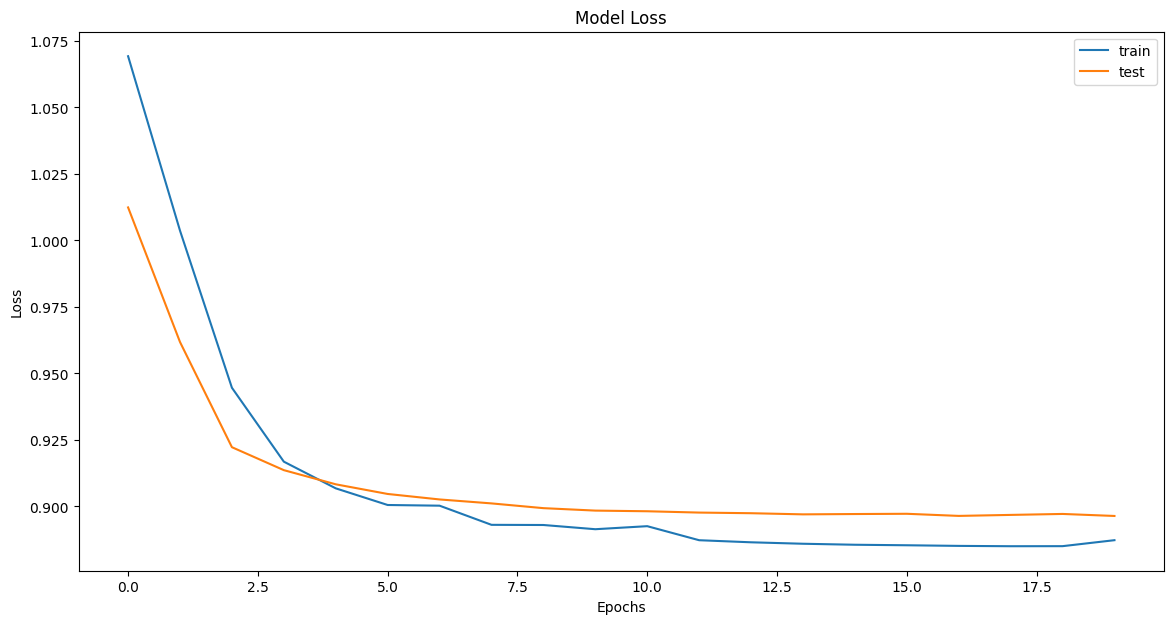

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Modal accuracy on test set: 43.53%


For threshold set to 0.40, correctness is: 43.53%
For threshold set to 0.45, correctness is: 43.53%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.4544 - loss: 1.0909 - val_accuracy: 0.4962 - val_loss: 1.0287
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4507 - loss: 1.0060 - val_accuracy: 0.4962 - val_loss: 0.9551
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4384 - loss: 0.9622 - val_accuracy: 0.4962 - val_loss: 0.9368
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4641 - loss: 0.9392 - val_accuracy: 0.4353 - val_loss: 0.9367
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Modal accuracy on test set: 47.01%


For threshold set to 0.40, correctness is: 47.01%
For threshold set to 0.45, correctness is: 47.01%
For threshold set to 0.50, correctness is: 47.56%
For threshold set to 0.55, correctness is: 49.43%
For threshold set to 0.60, correctness is: 50.78%
For threshold set to 0.65, correctness is: 62.50%
For threshold set to 0.70, correctness is: 50.00%
For threshold set to 0.75, correctness is: 0.00%
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(15,)



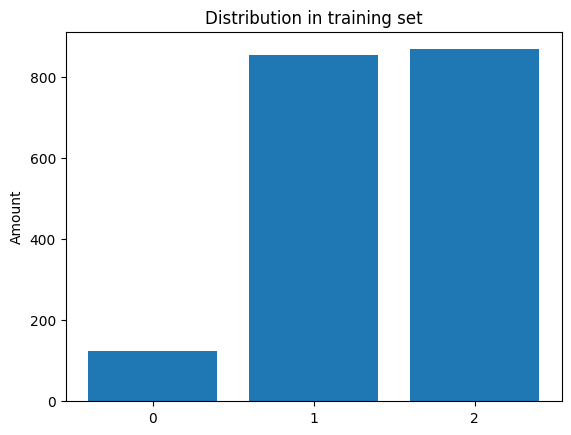

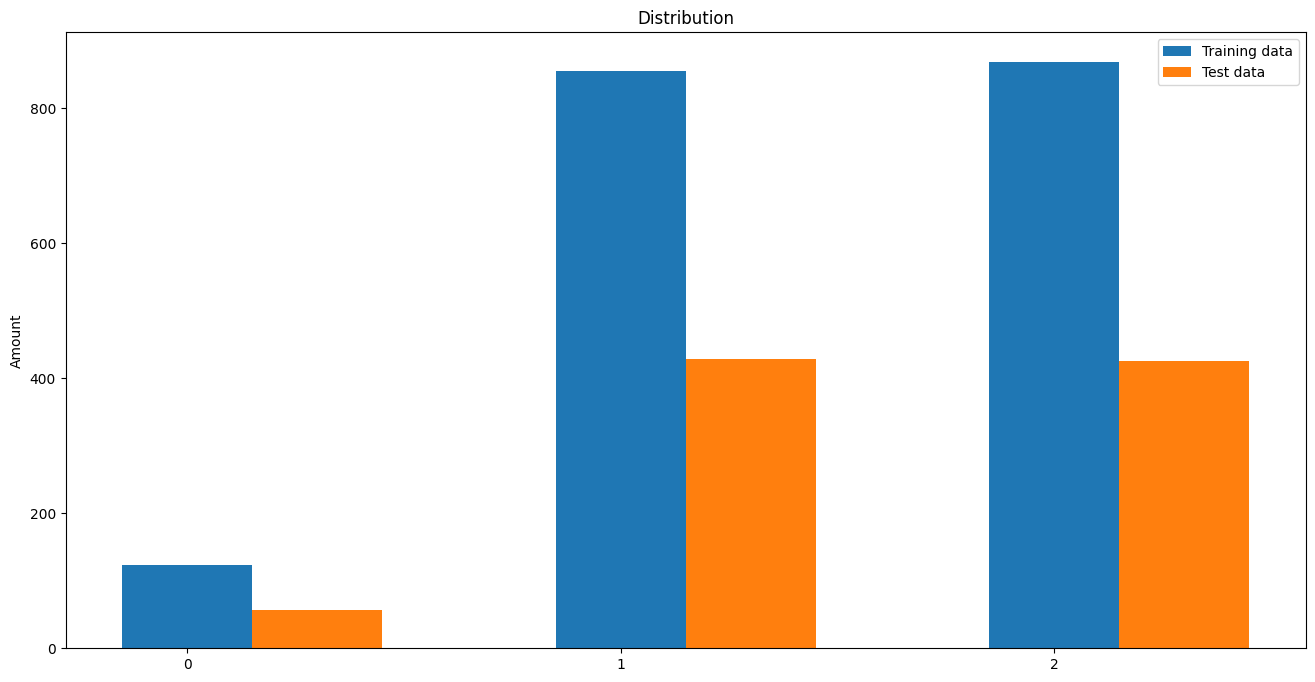


Example sequence from training set: [1 1 1 1 1 1 2 2 1 1 2 2 1 0 2] and its label: 1

Example sequence from test set: [2 1 1 2 2 1 2 1 1 1 2 1 1 2 1] and its label: 2


Gaussian Naive Bayes accuracy: 46.98%
Random forest classifier accuracy: 48.08%


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.2914 - loss: 1.1090 - val_accuracy: 0.4676 - val_loss: 1.0049
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4830 - loss: 0.9908 - val_accuracy: 0.4676 - val_loss: 0.9720
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4702 - loss: 0.9729 - val_accuracy: 0.4676 - val_loss: 0.9501
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4517 - loss: 0.9481 - val_accuracy: 0.4676 - val_loss: 0.9335
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4699 - loss: 0.9398 - val_accuracy: 0.4676 - val_loss: 0.9217
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4677 - loss: 0.9255 - val_accuracy: 0.4676 - val_loss

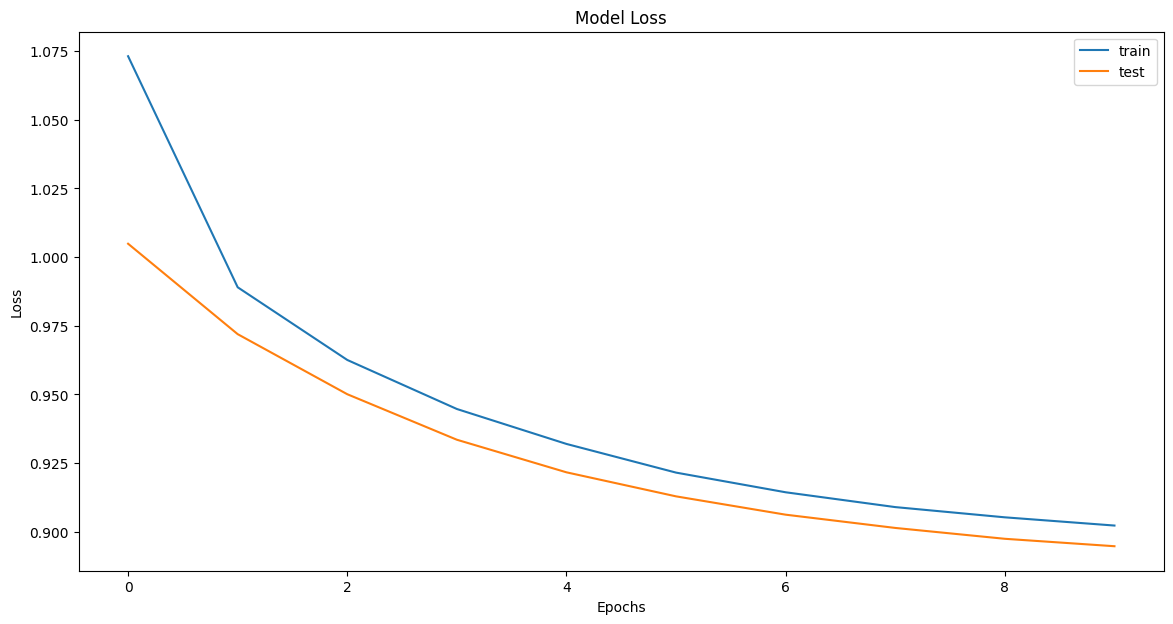

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Modal accuracy on test set: 46.76%


For threshold set to 0.40, correctness is: 46.76%
For threshold set to 0.45, correctness is: 46.76%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.4565 - loss: 1.0176 - val_accuracy: 0.4676 - val_loss: 0.9190
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4663 - loss: 0.9212 - val_accuracy: 0.4676 - val_loss: 0.9085
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4668 - loss: 0.9186 - val_accuracy: 0.4676 - val_loss: 0.9012
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4662 - loss: 0.9155 - val_accuracy: 0.4676 - val_loss: 0.8963
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

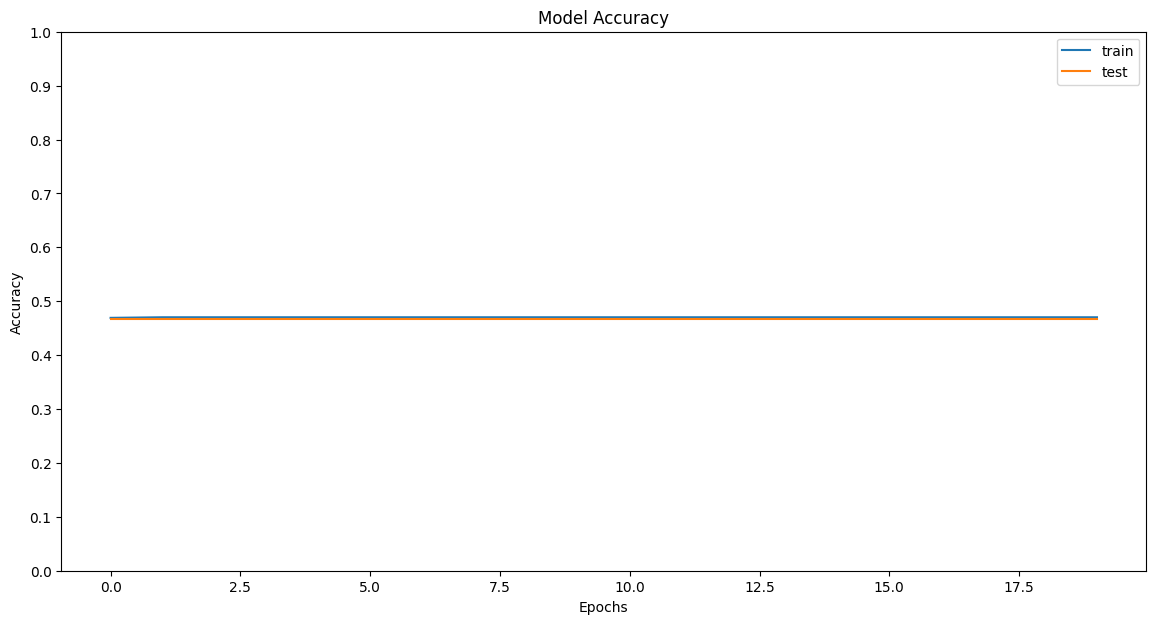

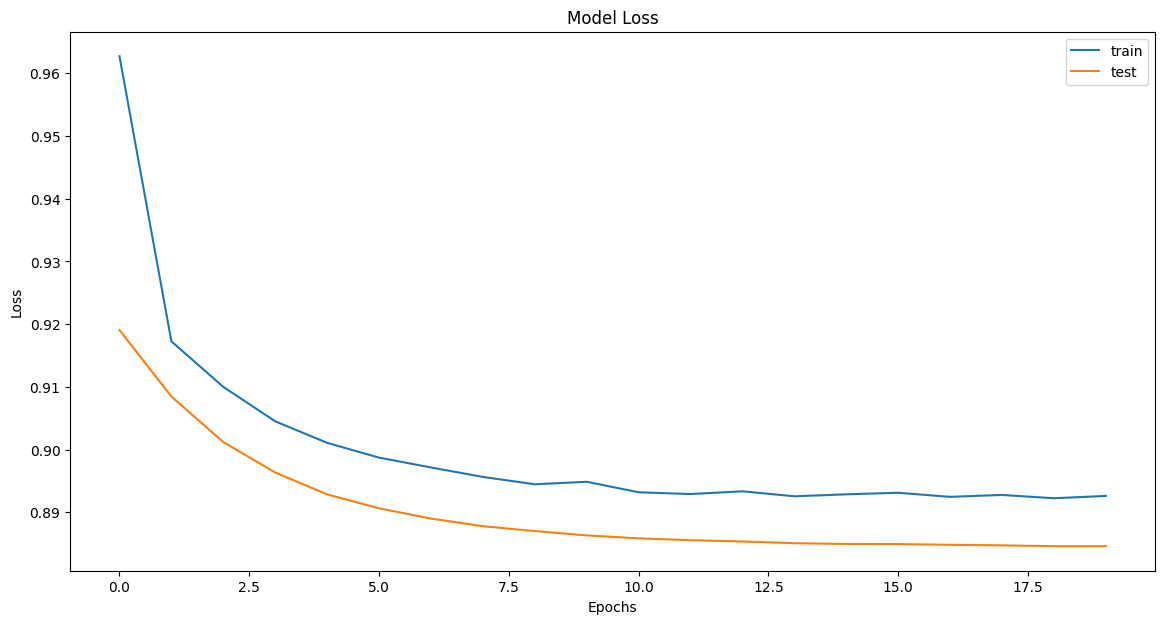

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Modal accuracy on test set: 46.76%


For threshold set to 0.40, correctness is: 46.76%
For threshold set to 0.45, correctness is: 46.76%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.4140 - loss: 1.0851 - val_accuracy: 0.4676 - val_loss: 1.0058
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4717 - loss: 0.9833 - val_accuracy: 0.4687 - val_loss: 0.9531
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4525 - loss: 0.9484 - val_accuracy: 0.4676 - val_loss: 0.9344
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4803 - loss: 0.9261 - val_accuracy: 0.4676 - val_loss: 0.9215
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Modal accuracy on test set: 48.85%


For threshold set to 0.40, correctness is: 48.85%
For threshold set to 0.45, correctness is: 48.85%
For threshold set to 0.50, correctness is: 48.68%
For threshold set to 0.55, correctness is: 48.49%
For threshold set to 0.60, correctness is: 49.71%
For threshold set to 0.65, correctness is: 48.63%
For threshold set to 0.70, correctness is: 47.17%
For threshold set to 0.75, correctness is: 44.19%
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(20,)




Example sequence from training set: [2 1 2 1 0 1 2 2 2 1 1 2 1 2 1 1 1 2 1 1] and its label: 1

Example sequence from test set: [2 1 2 1 1 2 2 1 1 0 0 2 0 2 2 2 2 2 2 2] and its label: 1


Gaussian Naive Bayes accuracy: 48.06%
Random forest classifier accuracy: 47.73%


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.4614 - loss: 1.0409 - val_accuracy: 0.4596 - val_loss: 0.9096
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4811 - loss: 0.9138 - val_accuracy: 0.4596 - val_loss: 0.9015
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4826 - loss: 0.9083 - val_accuracy: 0.4596 - val_loss: 0.8959
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4749 - loss: 0.9038 - val_accuracy: 0.4596 - val_loss: 0.8915
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4759 - loss: 0.8919 - val_accuracy: 0.4596 - val_loss: 0.8892
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4710 - loss: 0.8929 - val_accurac

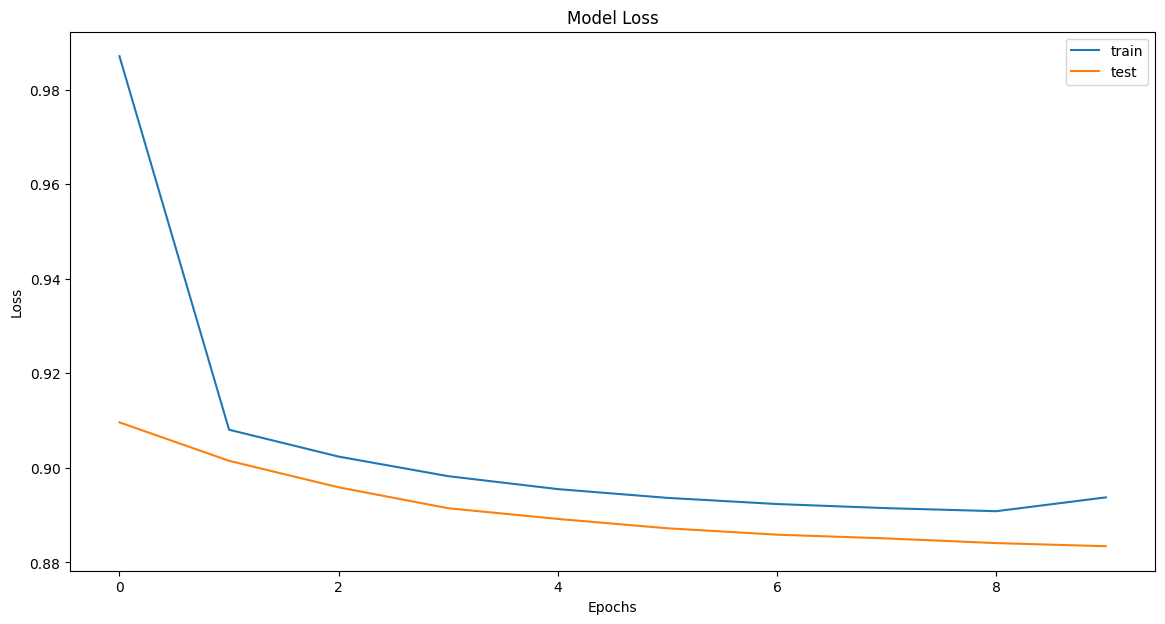

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Modal accuracy on test set: 45.96%


For threshold set to 0.40, correctness is: 45.96%
For threshold set to 0.45, correctness is: 45.96%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4540 - loss: 1.0281 - val_accuracy: 0.4596 - val_loss: 0.9186
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4916 - loss: 0.9104 - val_accuracy: 0.4596 - val_loss: 0.9077
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4943 - loss: 0.9015 - val_accuracy: 0.4596 - val_loss: 0.9002
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4954 - loss: 0.9056 - val_accuracy: 0.4596 - val_loss: 0.8953
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Modal accuracy on test set: 45.96%


For threshold set to 0.40, correctness is: 45.96%
For threshold set to 0.45, correctness is: 45.96%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.2895 - loss: 1.0860 - val_accuracy: 0.4773 - val_loss: 0.9985
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4518 - loss: 0.9922 - val_accuracy: 0.4773 - val_loss: 0.9691
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4726 - loss: 0.9695 - val_accuracy: 0.4596 - val_loss: 0.9530
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4678 - loss: 0.9617 - val_accuracy: 0.4773 - val_loss: 0.9336
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

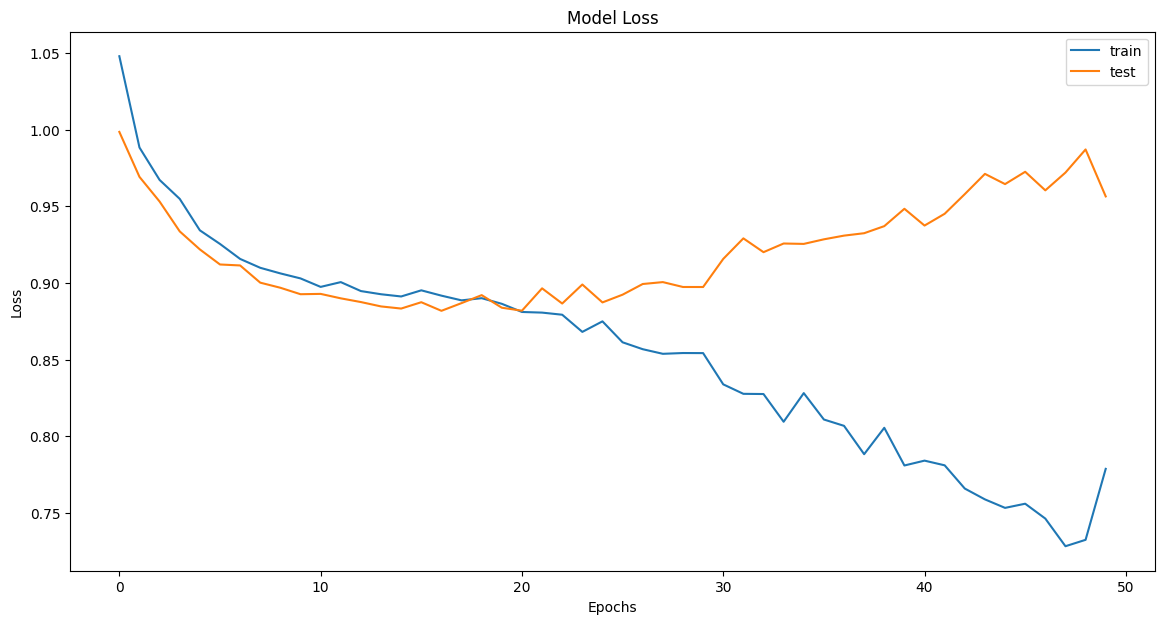

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Modal accuracy on test set: 49.39%


For threshold set to 0.40, correctness is: 49.39%
For threshold set to 0.45, correctness is: 49.77%
For threshold set to 0.50, correctness is: 49.81%
For threshold set to 0.55, correctness is: 50.79%
For threshold set to 0.60, correctness is: 49.83%
For threshold set to 0.65, correctness is: 51.85%
For threshold set to 0.70, correctness is: 52.35%
For threshold set to 0.75, correctness is: 53.10%
No data reaching 0.80 threshold
No data reaching 0.85 threshold



(40,)



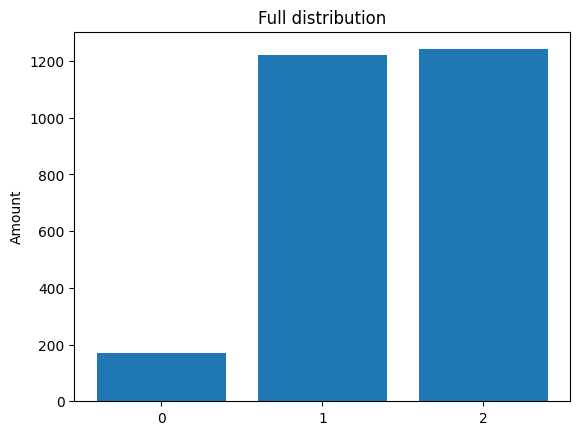

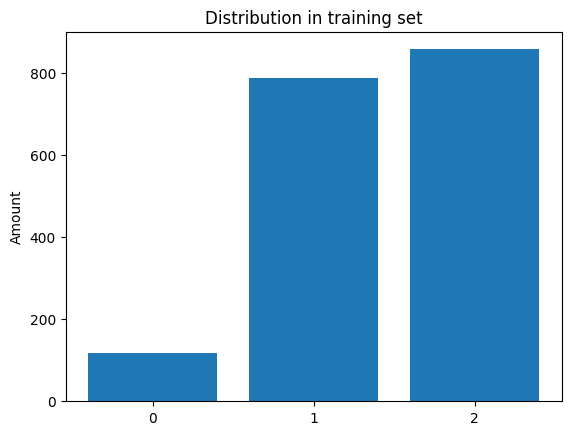

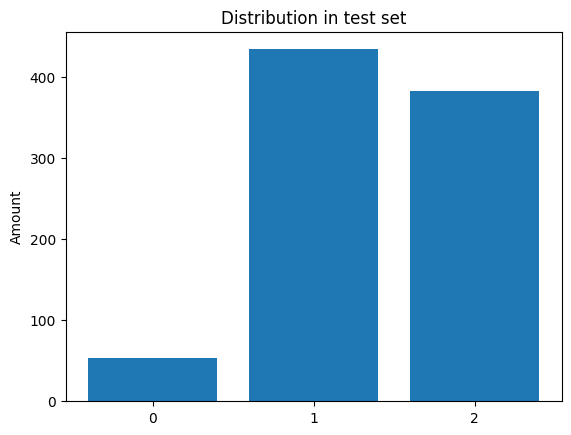

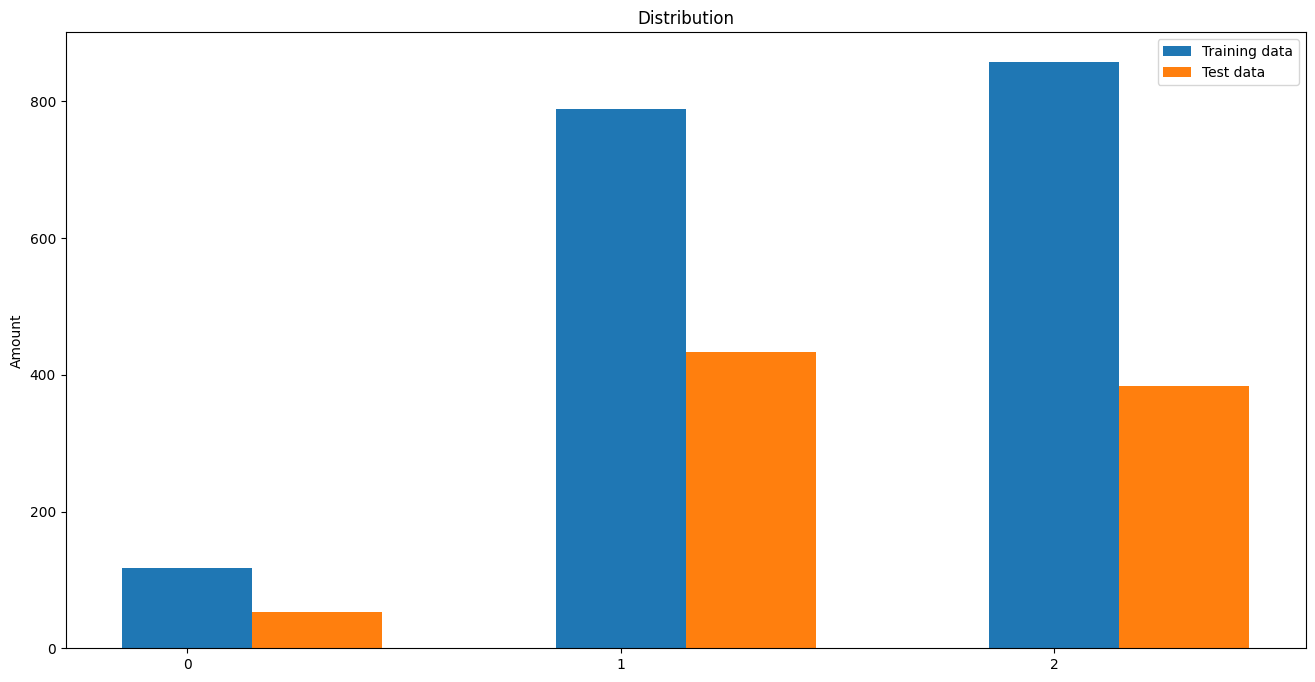


Example sequence from training set: [1 1 1 1 2 2 2 1 1 1 1 1 2 2 1 1 1 1 2 1 2 2 1 2 2 0 2 2 1 1 2 1 1 2 2 2 0
 1 1 2] and its label: 1

Example sequence from test set: [1 2 0 2 1 1 1 2 2 2 2 1 1 2 1 2 1 0 2 1 2 2 1 2 1 1 2 1 2 1 2 2 1 2 2 2 1
 2 1 2] and its label: 2


Gaussian Naive Bayes accuracy: 48.16%
Random forest classifier accuracy: 46.32%


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4767 - loss: 1.0295 - val_accuracy: 0.4989 - val_loss: 0.9221
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4673 - loss: 0.9216 - val_accuracy: 0.4989 - val_loss: 0.9102
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4625 - loss: 0.9191 - val_accuracy: 0.4989 - val_loss: 0.9024
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4466 - loss: 0.9246 - val_accuracy: 0.4402 - val_loss: 0.8972
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4947 - loss: 0.9073 - val_accuracy: 0.4402 - val_loss: 0.8929
Epoch 6/10
56/5

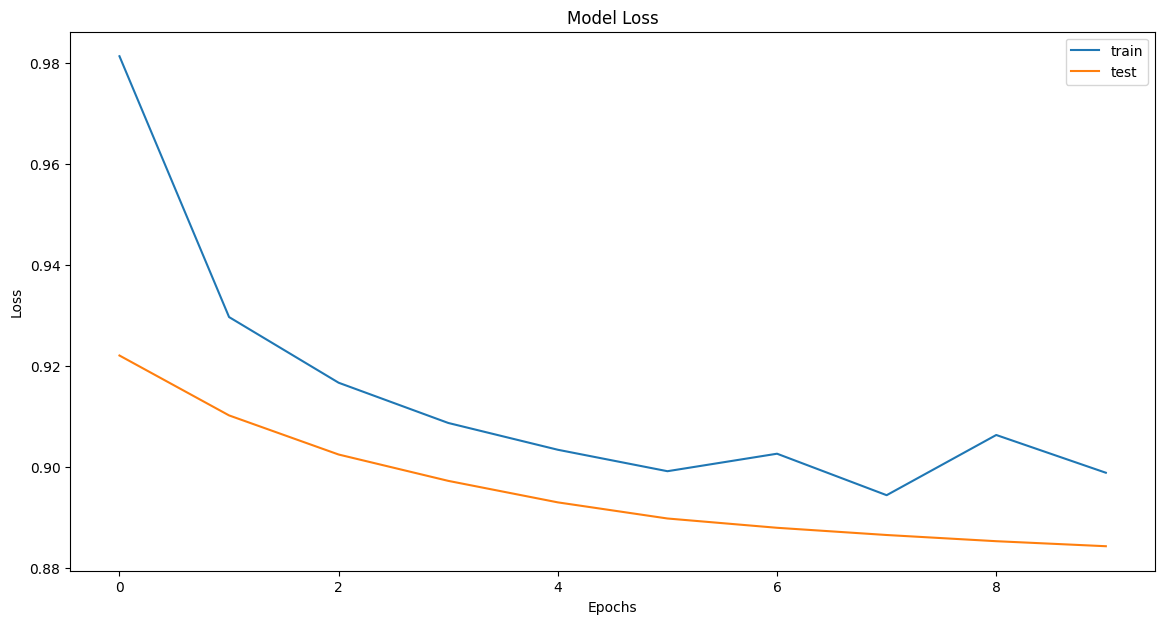

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Modal accuracy on test set: 44.02%


For threshold set to 0.40, correctness is: 44.02%
For threshold set to 0.45, correctness is: 44.02%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5039 - loss: 1.0006 - val_accuracy: 0.4402 - val_loss: 0.9279
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4848 - loss: 0.9381 - val_accuracy: 0.4402 - val_loss: 0.9153
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4918 - loss: 0.9203 - val_accuracy: 0.4402 - val_loss: 0.9065
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4798 - loss: 0.9128 - val_accuracy: 0.4402 - val_loss: 0.8996
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

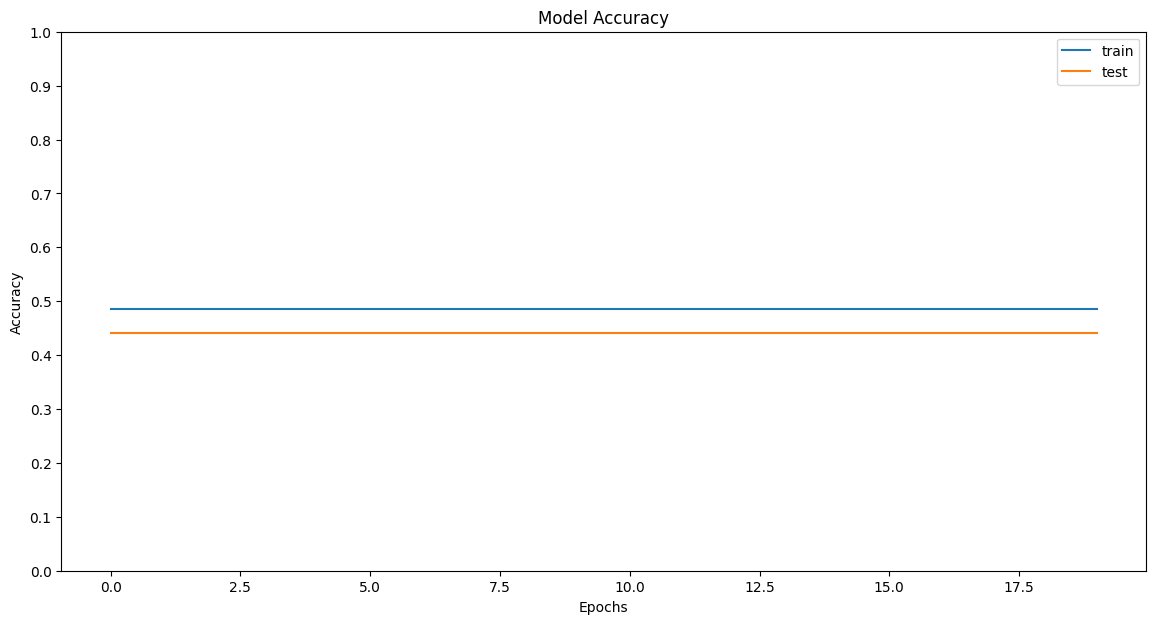

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Modal accuracy on test set: 44.02%


For threshold set to 0.40, correctness is: 44.02%
For threshold set to 0.45, correctness is: 44.02%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.3648 - loss: 1.0515 - val_accuracy: 0.4402 - val_loss: 0.9776
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4845 - loss: 0.9628 - val_accuracy: 0.4402 - val_loss: 0.9537
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4997 - loss: 0.9478 - val_accuracy: 0.4402 - val_loss: 0.9359
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4743 - loss: 0.9372 - val_accuracy: 0.4402 - val_loss: 0.9218
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

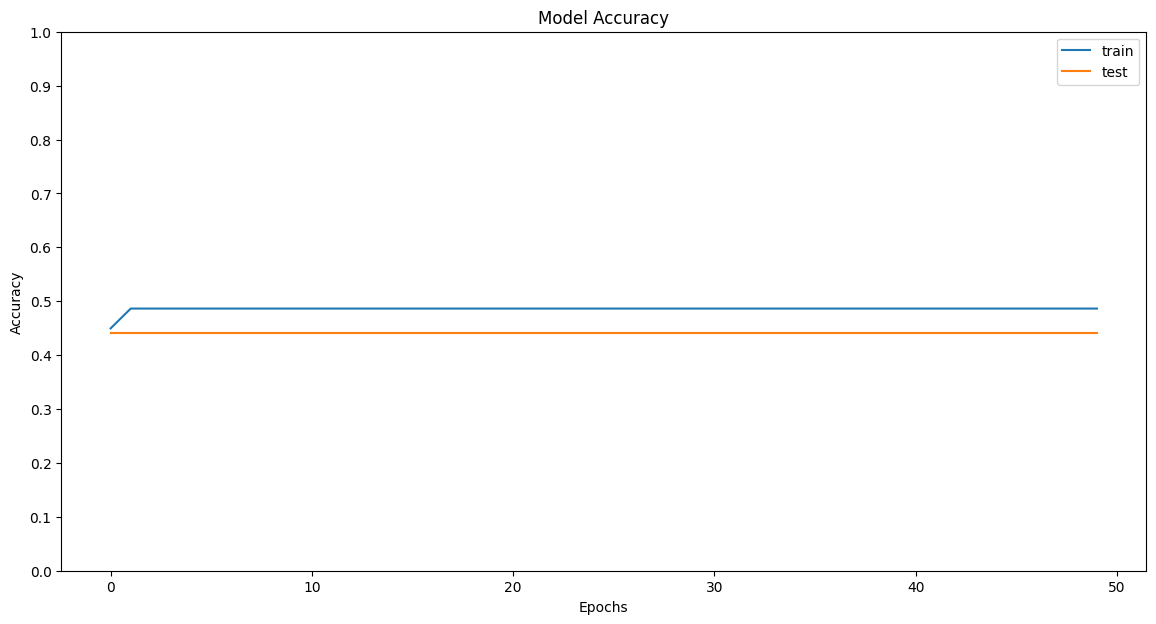

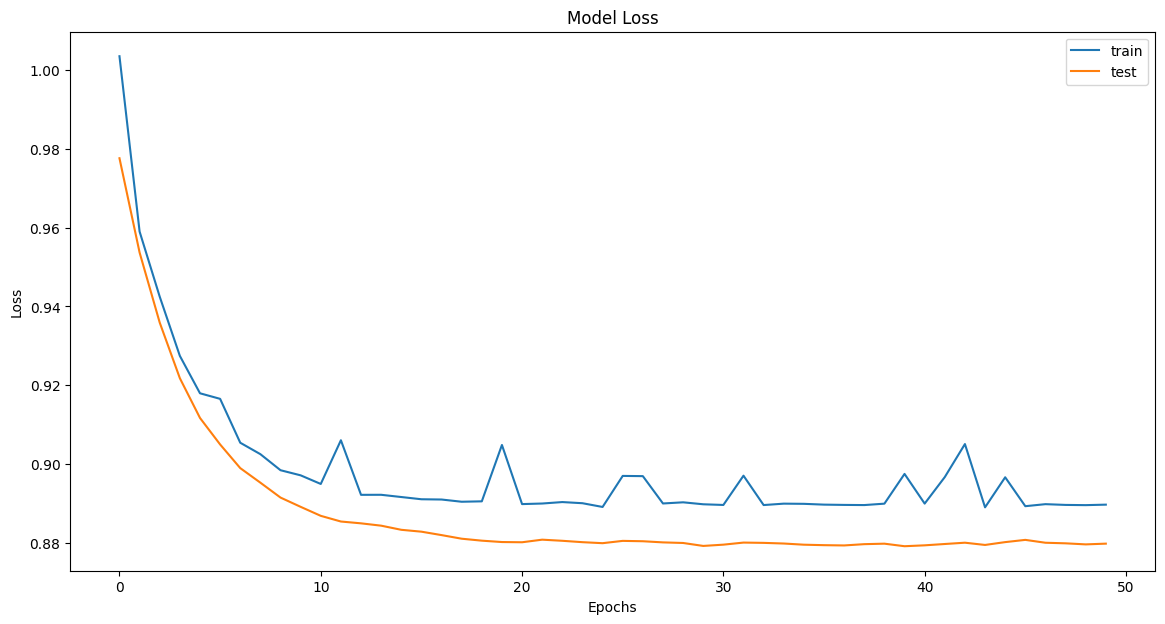

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Modal accuracy on test set: 44.02%


For threshold set to 0.40, correctness is: 44.02%
For threshold set to 0.45, correctness is: 44.02%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Top 3 results:
Chunk size: 20, Epoch: 50, Accuracy: 49.39%
Chunk size: 15, Epoch: 50, Accuracy: 48.85%
Chunk size: 5, Epoch: 10, Accuracy: 47.46%


In [19]:
CHUNK_SIZES_TO_TEST = [2,5,10,15,20,40]
EPOCHS_TO_TEST = [10,20,50]

results = []
for file in os.listdir("data"):
    if file.endswith(".csv"):
        print(f"\n====================\nData from file: {file}\n====================\n")
        colors = read_file(f"data/{file}")
        top_accuracy = analize_dataset(colors, CHUNK_SIZES_TO_TEST, EPOCHS_TO_TEST)
        results.append((*top_accuracy, file))

In [20]:
results.sort(key=lambda x: x[2], reverse=True)
print("Top 3 results:")
for i in range(min(3, len(results))):
    chunk_size, epoch, accuracy, file = results[i]
    print(f"File: {file}, Chunk size: {chunk_size}, Epoch: {epoch}, Accuracy: {accuracy * 100:.2f}%")

Top 3 results:
File: plgbet.csv, Chunk size: 20, Epoch: 50, Accuracy: 49.39%
File: csgofastcom.csv, Chunk size: 20, Epoch: 20, Accuracy: 48.18%
File: csgo500com.csv, Chunk size: 2, Epoch: 10, Accuracy: 46.00%
